# Importing Libraries

In [202]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from collections import defaultdict
from typing import List
import string

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Reading Dataset

In [15]:
df = pd.read_csv("./text_dataset.csv")
df.head()

,Letters,Target
0,ayy aSrysed ayn uo ouinbas 39 pInoys| 1 ft 100...,9
1,MGM/UA Communications Co. A5ONot Roxbury Dive ...,0
2,NaN,4
3,"ay CosTAN CoNFDENTAL WORK PRODUCT, JOT DEENGE,...",2
4,"Origa Mass290— From: Borgmann, Hoty Monday, Ja...",2


In [16]:
# counting the values for each class
df["Target"].value_counts()

Target
9    500
0    500
4    500
2    500
6    500
Name: count, dtype: int64

In [17]:
df.isnull().sum()

Letters    59
Target      0
dtype: int64

# Feature Engineering

In [18]:
# dropping NA Values
df.dropna(inplace=True,axis=0)
df.shape

(2441, 2)

In [20]:

def remove_punctuation(text):
    return ''.join([c for c in text if c not in string.punctuation])

def cleaning_data(data):
    data["Letters"] = data["Letters"].str.lower()
    data["Letters"] = data["Letters"].apply(remove_punctuation)
    return data

In [24]:
df_cleaned = cleaning_data(df)

In [25]:
df_cleaned.head()

,Letters,Target
0,ayy asrysed ayn uo ouinbas 39 pinoys 1 ft 1000...,9
1,mgmua communications co a5onot roxbury dive be...,0
3,ay costan confdental work product jot deenge o...,2
4,origa mass290— from borgmann hoty monday janua...,2
5,s68u leave smoking rules up to each busi 1s 13...,9


# Data Splitting

In [244]:
df_cleaned["Target"] =  df_cleaned["Target"].astype("category")


In [245]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2441 entries, 0 to 2499
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   Letters  2441 non-null   object  
 1   Target   2441 non-null   category
dtypes: category(1), object(1)
memory usage: 40.7+ KB


In [253]:
X = df_cleaned["Letters"]
y = df_cleaned["Target"]

In [254]:
y_mapped = y.map({
    0:0,
    2:1,
    4:2,
    6:3,
    9:4
})

In [255]:
X_train,X_test,y_train,y_test = train_test_split(X,y_mapped,test_size=0.2,random_state=42)
X_train.shape,X_test.shape

((1952,), (489,))

# Bag of Words

In [256]:
toNumeric = CountVectorizer()

In [257]:
sampleTrain_dtm = toNumeric.fit_transform(X_train)
sampleTrain_dtm

<1952x80849 sparse matrix of type '<class 'numpy.int64'>'
	with 304620 stored elements in Compressed Sparse Row format>

In [ ]:
# Let's convert sparse matrix to a dense matrix
sampleTrain_dtm.toarray()

In [259]:
sampleTest_dtm = toNumeric.transform(X_test)
sampleTest_dtm

<489x80849 sparse matrix of type '<class 'numpy.int64'>'
	with 63400 stored elements in Compressed Sparse Row format>

# TF-IDF

- BoW is performing better than TF-IDF so we will not use TF-IDF for this project

In [203]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [204]:
rf_classification = RandomForestClassifier()
rf_model = rf_classification.fit(X_train_tfidf, y_train)
y_pred_rf_class = rf_classification.predict(X_test_tfidf)
print(metrics.accuracy_score(y_test, y_pred_rf_class))
metrics.confusion_matrix(y_test, y_pred_rf_class)


0.754601226993865


array([[82,  3, 12,  2,  3],
       [ 6, 79,  7,  0,  2],
       [ 6,  3, 62,  0,  5],
       [ 0,  0, 12, 79,  8],
       [ 9,  2, 35,  5, 67]], dtype=int64)

In [205]:
xgb_classification = XGBClassifier()
xgb_model = xgb_classification.fit(X_train_tfidf, y_train)
y_pred_xgb_class = xgb_classification.predict(X_test_tfidf)
print(metrics.accuracy_score(y_test, y_pred_xgb_class))
metrics.confusion_matrix(y_test, y_pred_xgb_class)


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


0.8077709611451943


array([[82,  4, 10,  2,  4],
       [ 6, 79,  4,  3,  2],
       [ 0,  0, 60,  3, 13],
       [ 0,  0,  3, 87,  9],
       [ 1,  3, 20,  7, 87]], dtype=int64)

# Model Building ML

In [233]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [234]:
nb.fit(sampleTrain_dtm, y_train)

MultinomialNB()

In [235]:
y_pred_class = nb.predict(sampleTest_dtm)


In [236]:
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)


0.7137014314928425

In [237]:
metrics.confusion_matrix(y_test, y_pred_class)


array([[ 80,   3,   0,   6,  13],
       [ 26,  59,   0,   2,   7],
       [ 12,   7,  10,   2,  45],
       [  2,   0,   0,  89,   8],
       [  1,   3,   0,   3, 111]], dtype=int64)

In [238]:
decision_tree_classification = DecisionTreeClassifier(criterion = 'entropy',random_state = 10)
decision_tree = decision_tree_classification.fit(sampleTrain_dtm, y_train)

In [239]:
y_pred_dt_class = decision_tree_classification.predict(sampleTest_dtm)
metrics.accuracy_score(y_test, y_pred_dt_class)

0.7300613496932515

In [240]:
metrics.confusion_matrix(y_test, y_pred_dt_class)


array([[69,  7,  7,  5, 14],
       [ 9, 73,  9,  0,  3],
       [ 1,  1, 55,  0, 19],
       [ 3,  0,  3, 85,  8],
       [ 4,  2, 22, 15, 75]], dtype=int64)

In [241]:
rf_classification = RandomForestClassifier()
rf_model = rf_classification.fit(sampleTrain_dtm, y_train)
y_pred_rf_class = rf_classification.predict(sampleTest_dtm)
print(metrics.accuracy_score(y_test, y_pred_rf_class))
metrics.confusion_matrix(y_test, y_pred_rf_class)


0.7586912065439673


array([[79,  6, 11,  4,  2],
       [ 6, 81,  5,  1,  1],
       [ 9,  0, 63,  1,  3],
       [ 2,  0, 10, 79,  8],
       [ 6,  3, 34,  6, 69]], dtype=int64)

# XGBoost

In [260]:
xgb_classification = XGBClassifier()
xgb_model = xgb_classification.fit(sampleTrain_dtm, y_train)
y_pred_xgb_class = xgb_classification.predict(sampleTest_dtm)
print(metrics.accuracy_score(y_test, y_pred_xgb_class))
metrics.confusion_matrix(y_test, y_pred_xgb_class)


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


0.8302658486707567


array([[85,  2,  9,  3,  3],
       [ 3, 82,  5,  1,  3],
       [ 1,  0, 64,  2,  9],
       [ 0,  0,  4, 87,  8],
       [ 1,  2, 19,  8, 88]], dtype=int64)

In [261]:
print(metrics.classification_report(y_test, y_pred_xgb_class))

              precision    recall  f1-score   support

           0       0.94      0.83      0.89       102
           1       0.95      0.87      0.91        94
           2       0.63      0.84      0.72        76
           3       0.86      0.88      0.87        99
           4       0.79      0.75      0.77       118

    accuracy                           0.83       489
   macro avg       0.84      0.83      0.83       489
weighted avg       0.84      0.83      0.83       489



# Hyperparameter Tuning

- Since XGBoost is performing better than other ML algorithms we will start with tuning hyperparameters of XGBoost.


In [191]:
def random_search_cv(model_accuracies,range_epochs,X_train,y_train):
  xgb = XGBClassifier()
  param_grid={'max_depth': np.arange(1,400,50),
          'gamma': np.arange(1,9,3),
          'reg_alpha' :np.arange(1,400,20),
          'reg_lambda' : np.arange(0,5,1),
          'colsample_bytree' : np.arange(0,1,0.1),
          'min_child_weight' : np.arange(0,40,5),
          'n_estimators': np.arange(1,400,50),
          'learning_rate':np.arange(0,2,0.1)
          
      }


  for i in range(range_epochs):
    model = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    scoring="accuracy",
    verbose=10,
    n_iter=10,
    n_jobs=1,
    cv=10)

    model.fit(X_train,y_train)

    model_accuracies[model] = model.best_score_

In [192]:
model_accuracies = {}
range_epochs = 5
random_search_cv(model_accuracies,range_epochs,sampleTrain_dtm,y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 1/10; 1/10] START colsample_bytree=0.0, gamma=1, learning_rate=1.9000000000000001, max_depth=151, min_child_weight=0, n_estimators=301, reg_alpha=301, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/10; 1/10] END colsample_bytree=0.0, gamma=1, learning_rate=1.9000000000000001, max_depth=151, min_child_weight=0, n_estimators=301, reg_alpha=301, reg_lambda=2;, score=0.204 total time=   6.7s
[CV 2/10; 1/10] START colsample_bytree=0.0, gamma=1, learning_rate=1.9000000000000001, max_depth=151, min_child_weight=0, n_estimators=301, reg_alpha=301, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/10; 1/10] END colsample_bytree=0.0, gamma=1, learning_rate=1.9000000000000001, max_depth=151, min_child_weight=0, n_estimators=301, reg_alpha=301, reg_lambda=2;, score=0.204 total time=   5.2s
[CV 3/10; 1/10] START colsample_bytree=0.0, gamma=1, learning_rate=1.9000000000000001, max_depth=151, min_child_weight=0, n_estimators=301, reg_alpha=301, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/10; 1/10] END colsample_bytree=0.0, gamma=1, learning_rate=1.9000000000000001, max_depth=151, min_child_weight=0, n_estimators=301, reg_alpha=301, reg_lambda=2;, score=0.200 total time=   5.6s
[CV 4/10; 1/10] START colsample_bytree=0.0, gamma=1, learning_rate=1.9000000000000001, max_depth=151, min_child_weight=0, n_estimators=301, reg_alpha=301, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/10; 1/10] END colsample_bytree=0.0, gamma=1, learning_rate=1.9000000000000001, max_depth=151, min_child_weight=0, n_estimators=301, reg_alpha=301, reg_lambda=2;, score=0.200 total time=   5.8s
[CV 5/10; 1/10] START colsample_bytree=0.0, gamma=1, learning_rate=1.9000000000000001, max_depth=151, min_child_weight=0, n_estimators=301, reg_alpha=301, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/10; 1/10] END colsample_bytree=0.0, gamma=1, learning_rate=1.9000000000000001, max_depth=151, min_child_weight=0, n_estimators=301, reg_alpha=301, reg_lambda=2;, score=0.200 total time=   6.4s
[CV 6/10; 1/10] START colsample_bytree=0.0, gamma=1, learning_rate=1.9000000000000001, max_depth=151, min_child_weight=0, n_estimators=301, reg_alpha=301, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 6/10; 1/10] END colsample_bytree=0.0, gamma=1, learning_rate=1.9000000000000001, max_depth=151, min_child_weight=0, n_estimators=301, reg_alpha=301, reg_lambda=2;, score=0.205 total time=   7.1s
[CV 7/10; 1/10] START colsample_bytree=0.0, gamma=1, learning_rate=1.9000000000000001, max_depth=151, min_child_weight=0, n_estimators=301, reg_alpha=301, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 7/10; 1/10] END colsample_bytree=0.0, gamma=1, learning_rate=1.9000000000000001, max_depth=151, min_child_weight=0, n_estimators=301, reg_alpha=301, reg_lambda=2;, score=0.205 total time=   5.8s
[CV 8/10; 1/10] START colsample_bytree=0.0, gamma=1, learning_rate=1.9000000000000001, max_depth=151, min_child_weight=0, n_estimators=301, reg_alpha=301, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 8/10; 1/10] END colsample_bytree=0.0, gamma=1, learning_rate=1.9000000000000001, max_depth=151, min_child_weight=0, n_estimators=301, reg_alpha=301, reg_lambda=2;, score=0.205 total time=   6.2s
[CV 9/10; 1/10] START colsample_bytree=0.0, gamma=1, learning_rate=1.9000000000000001, max_depth=151, min_child_weight=0, n_estimators=301, reg_alpha=301, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 9/10; 1/10] END colsample_bytree=0.0, gamma=1, learning_rate=1.9000000000000001, max_depth=151, min_child_weight=0, n_estimators=301, reg_alpha=301, reg_lambda=2;, score=0.205 total time=   6.6s
[CV 10/10; 1/10] START colsample_bytree=0.0, gamma=1, learning_rate=1.9000000000000001, max_depth=151, min_child_weight=0, n_estimators=301, reg_alpha=301, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 10/10; 1/10] END colsample_bytree=0.0, gamma=1, learning_rate=1.9000000000000001, max_depth=151, min_child_weight=0, n_estimators=301, reg_alpha=301, reg_lambda=2;, score=0.205 total time=   6.5s
[CV 1/10; 2/10] START colsample_bytree=0.8, gamma=1, learning_rate=1.4000000000000001, max_depth=1, min_child_weight=25, n_estimators=351, reg_alpha=81, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/10; 2/10] END colsample_bytree=0.8, gamma=1, learning_rate=1.4000000000000001, max_depth=1, min_child_weight=25, n_estimators=351, reg_alpha=81, reg_lambda=4;, score=0.602 total time=  22.7s
[CV 2/10; 2/10] START colsample_bytree=0.8, gamma=1, learning_rate=1.4000000000000001, max_depth=1, min_child_weight=25, n_estimators=351, reg_alpha=81, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/10; 2/10] END colsample_bytree=0.8, gamma=1, learning_rate=1.4000000000000001, max_depth=1, min_child_weight=25, n_estimators=351, reg_alpha=81, reg_lambda=4;, score=0.566 total time=  23.5s
[CV 3/10; 2/10] START colsample_bytree=0.8, gamma=1, learning_rate=1.4000000000000001, max_depth=1, min_child_weight=25, n_estimators=351, reg_alpha=81, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/10; 2/10] END colsample_bytree=0.8, gamma=1, learning_rate=1.4000000000000001, max_depth=1, min_child_weight=25, n_estimators=351, reg_alpha=81, reg_lambda=4;, score=0.605 total time=  23.7s
[CV 4/10; 2/10] START colsample_bytree=0.8, gamma=1, learning_rate=1.4000000000000001, max_depth=1, min_child_weight=25, n_estimators=351, reg_alpha=81, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/10; 2/10] END colsample_bytree=0.8, gamma=1, learning_rate=1.4000000000000001, max_depth=1, min_child_weight=25, n_estimators=351, reg_alpha=81, reg_lambda=4;, score=0.621 total time=  23.8s
[CV 5/10; 2/10] START colsample_bytree=0.8, gamma=1, learning_rate=1.4000000000000001, max_depth=1, min_child_weight=25, n_estimators=351, reg_alpha=81, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/10; 2/10] END colsample_bytree=0.8, gamma=1, learning_rate=1.4000000000000001, max_depth=1, min_child_weight=25, n_estimators=351, reg_alpha=81, reg_lambda=4;, score=0.621 total time=  23.8s
[CV 6/10; 2/10] START colsample_bytree=0.8, gamma=1, learning_rate=1.4000000000000001, max_depth=1, min_child_weight=25, n_estimators=351, reg_alpha=81, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 6/10; 2/10] END colsample_bytree=0.8, gamma=1, learning_rate=1.4000000000000001, max_depth=1, min_child_weight=25, n_estimators=351, reg_alpha=81, reg_lambda=4;, score=0.626 total time=  23.7s
[CV 7/10; 2/10] START colsample_bytree=0.8, gamma=1, learning_rate=1.4000000000000001, max_depth=1, min_child_weight=25, n_estimators=351, reg_alpha=81, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 7/10; 2/10] END colsample_bytree=0.8, gamma=1, learning_rate=1.4000000000000001, max_depth=1, min_child_weight=25, n_estimators=351, reg_alpha=81, reg_lambda=4;, score=0.646 total time=  23.7s
[CV 8/10; 2/10] START colsample_bytree=0.8, gamma=1, learning_rate=1.4000000000000001, max_depth=1, min_child_weight=25, n_estimators=351, reg_alpha=81, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 8/10; 2/10] END colsample_bytree=0.8, gamma=1, learning_rate=1.4000000000000001, max_depth=1, min_child_weight=25, n_estimators=351, reg_alpha=81, reg_lambda=4;, score=0.667 total time=  23.8s
[CV 9/10; 2/10] START colsample_bytree=0.8, gamma=1, learning_rate=1.4000000000000001, max_depth=1, min_child_weight=25, n_estimators=351, reg_alpha=81, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 9/10; 2/10] END colsample_bytree=0.8, gamma=1, learning_rate=1.4000000000000001, max_depth=1, min_child_weight=25, n_estimators=351, reg_alpha=81, reg_lambda=4;, score=0.615 total time=  26.2s
[CV 10/10; 2/10] START colsample_bytree=0.8, gamma=1, learning_rate=1.4000000000000001, max_depth=1, min_child_weight=25, n_estimators=351, reg_alpha=81, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 10/10; 2/10] END colsample_bytree=0.8, gamma=1, learning_rate=1.4000000000000001, max_depth=1, min_child_weight=25, n_estimators=351, reg_alpha=81, reg_lambda=4;, score=0.662 total time=  24.1s
[CV 1/10; 3/10] START colsample_bytree=0.7000000000000001, gamma=7, learning_rate=1.6, max_depth=101, min_child_weight=5, n_estimators=151, reg_alpha=1, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/10; 3/10] END colsample_bytree=0.7000000000000001, gamma=7, learning_rate=1.6, max_depth=101, min_child_weight=5, n_estimators=151, reg_alpha=1, reg_lambda=4;, score=0.740 total time=  27.0s
[CV 2/10; 3/10] START colsample_bytree=0.7000000000000001, gamma=7, learning_rate=1.6, max_depth=101, min_child_weight=5, n_estimators=151, reg_alpha=1, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/10; 3/10] END colsample_bytree=0.7000000000000001, gamma=7, learning_rate=1.6, max_depth=101, min_child_weight=5, n_estimators=151, reg_alpha=1, reg_lambda=4;, score=0.724 total time=  29.2s
[CV 3/10; 3/10] START colsample_bytree=0.7000000000000001, gamma=7, learning_rate=1.6, max_depth=101, min_child_weight=5, n_estimators=151, reg_alpha=1, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/10; 3/10] END colsample_bytree=0.7000000000000001, gamma=7, learning_rate=1.6, max_depth=101, min_child_weight=5, n_estimators=151, reg_alpha=1, reg_lambda=4;, score=0.764 total time=  29.2s
[CV 4/10; 3/10] START colsample_bytree=0.7000000000000001, gamma=7, learning_rate=1.6, max_depth=101, min_child_weight=5, n_estimators=151, reg_alpha=1, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/10; 3/10] END colsample_bytree=0.7000000000000001, gamma=7, learning_rate=1.6, max_depth=101, min_child_weight=5, n_estimators=151, reg_alpha=1, reg_lambda=4;, score=0.785 total time=  29.1s
[CV 5/10; 3/10] START colsample_bytree=0.7000000000000001, gamma=7, learning_rate=1.6, max_depth=101, min_child_weight=5, n_estimators=151, reg_alpha=1, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/10; 3/10] END colsample_bytree=0.7000000000000001, gamma=7, learning_rate=1.6, max_depth=101, min_child_weight=5, n_estimators=151, reg_alpha=1, reg_lambda=4;, score=0.785 total time=  30.0s
[CV 6/10; 3/10] START colsample_bytree=0.7000000000000001, gamma=7, learning_rate=1.6, max_depth=101, min_child_weight=5, n_estimators=151, reg_alpha=1, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 6/10; 3/10] END colsample_bytree=0.7000000000000001, gamma=7, learning_rate=1.6, max_depth=101, min_child_weight=5, n_estimators=151, reg_alpha=1, reg_lambda=4;, score=0.754 total time=  32.8s
[CV 7/10; 3/10] START colsample_bytree=0.7000000000000001, gamma=7, learning_rate=1.6, max_depth=101, min_child_weight=5, n_estimators=151, reg_alpha=1, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 7/10; 3/10] END colsample_bytree=0.7000000000000001, gamma=7, learning_rate=1.6, max_depth=101, min_child_weight=5, n_estimators=151, reg_alpha=1, reg_lambda=4;, score=0.764 total time=  31.8s
[CV 8/10; 3/10] START colsample_bytree=0.7000000000000001, gamma=7, learning_rate=1.6, max_depth=101, min_child_weight=5, n_estimators=151, reg_alpha=1, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 8/10; 3/10] END colsample_bytree=0.7000000000000001, gamma=7, learning_rate=1.6, max_depth=101, min_child_weight=5, n_estimators=151, reg_alpha=1, reg_lambda=4;, score=0.779 total time=  31.3s
[CV 9/10; 3/10] START colsample_bytree=0.7000000000000001, gamma=7, learning_rate=1.6, max_depth=101, min_child_weight=5, n_estimators=151, reg_alpha=1, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 9/10; 3/10] END colsample_bytree=0.7000000000000001, gamma=7, learning_rate=1.6, max_depth=101, min_child_weight=5, n_estimators=151, reg_alpha=1, reg_lambda=4;, score=0.713 total time=  30.4s
[CV 10/10; 3/10] START colsample_bytree=0.7000000000000001, gamma=7, learning_rate=1.6, max_depth=101, min_child_weight=5, n_estimators=151, reg_alpha=1, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 10/10; 3/10] END colsample_bytree=0.7000000000000001, gamma=7, learning_rate=1.6, max_depth=101, min_child_weight=5, n_estimators=151, reg_alpha=1, reg_lambda=4;, score=0.785 total time=  29.9s
[CV 1/10; 4/10] START colsample_bytree=0.9, gamma=4, learning_rate=0.9, max_depth=1, min_child_weight=10, n_estimators=101, reg_alpha=101, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/10; 4/10] END colsample_bytree=0.9, gamma=4, learning_rate=0.9, max_depth=1, min_child_weight=10, n_estimators=101, reg_alpha=101, reg_lambda=1;, score=0.617 total time=   8.1s
[CV 2/10; 4/10] START colsample_bytree=0.9, gamma=4, learning_rate=0.9, max_depth=1, min_child_weight=10, n_estimators=101, reg_alpha=101, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/10; 4/10] END colsample_bytree=0.9, gamma=4, learning_rate=0.9, max_depth=1, min_child_weight=10, n_estimators=101, reg_alpha=101, reg_lambda=1;, score=0.566 total time=   7.6s
[CV 3/10; 4/10] START colsample_bytree=0.9, gamma=4, learning_rate=0.9, max_depth=1, min_child_weight=10, n_estimators=101, reg_alpha=101, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/10; 4/10] END colsample_bytree=0.9, gamma=4, learning_rate=0.9, max_depth=1, min_child_weight=10, n_estimators=101, reg_alpha=101, reg_lambda=1;, score=0.636 total time=   7.8s
[CV 4/10; 4/10] START colsample_bytree=0.9, gamma=4, learning_rate=0.9, max_depth=1, min_child_weight=10, n_estimators=101, reg_alpha=101, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/10; 4/10] END colsample_bytree=0.9, gamma=4, learning_rate=0.9, max_depth=1, min_child_weight=10, n_estimators=101, reg_alpha=101, reg_lambda=1;, score=0.656 total time=   7.7s
[CV 5/10; 4/10] START colsample_bytree=0.9, gamma=4, learning_rate=0.9, max_depth=1, min_child_weight=10, n_estimators=101, reg_alpha=101, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/10; 4/10] END colsample_bytree=0.9, gamma=4, learning_rate=0.9, max_depth=1, min_child_weight=10, n_estimators=101, reg_alpha=101, reg_lambda=1;, score=0.621 total time=   7.8s
[CV 6/10; 4/10] START colsample_bytree=0.9, gamma=4, learning_rate=0.9, max_depth=1, min_child_weight=10, n_estimators=101, reg_alpha=101, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 6/10; 4/10] END colsample_bytree=0.9, gamma=4, learning_rate=0.9, max_depth=1, min_child_weight=10, n_estimators=101, reg_alpha=101, reg_lambda=1;, score=0.621 total time=   8.0s
[CV 7/10; 4/10] START colsample_bytree=0.9, gamma=4, learning_rate=0.9, max_depth=1, min_child_weight=10, n_estimators=101, reg_alpha=101, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 7/10; 4/10] END colsample_bytree=0.9, gamma=4, learning_rate=0.9, max_depth=1, min_child_weight=10, n_estimators=101, reg_alpha=101, reg_lambda=1;, score=0.646 total time=   7.8s
[CV 8/10; 4/10] START colsample_bytree=0.9, gamma=4, learning_rate=0.9, max_depth=1, min_child_weight=10, n_estimators=101, reg_alpha=101, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 8/10; 4/10] END colsample_bytree=0.9, gamma=4, learning_rate=0.9, max_depth=1, min_child_weight=10, n_estimators=101, reg_alpha=101, reg_lambda=1;, score=0.662 total time=   7.8s
[CV 9/10; 4/10] START colsample_bytree=0.9, gamma=4, learning_rate=0.9, max_depth=1, min_child_weight=10, n_estimators=101, reg_alpha=101, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 9/10; 4/10] END colsample_bytree=0.9, gamma=4, learning_rate=0.9, max_depth=1, min_child_weight=10, n_estimators=101, reg_alpha=101, reg_lambda=1;, score=0.646 total time=   7.7s
[CV 10/10; 4/10] START colsample_bytree=0.9, gamma=4, learning_rate=0.9, max_depth=1, min_child_weight=10, n_estimators=101, reg_alpha=101, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 10/10; 4/10] END colsample_bytree=0.9, gamma=4, learning_rate=0.9, max_depth=1, min_child_weight=10, n_estimators=101, reg_alpha=101, reg_lambda=1;, score=0.672 total time=   7.7s
[CV 1/10; 5/10] START colsample_bytree=0.4, gamma=4, learning_rate=0.30000000000000004, max_depth=201, min_child_weight=35, n_estimators=251, reg_alpha=161, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/10; 5/10] END colsample_bytree=0.4, gamma=4, learning_rate=0.30000000000000004, max_depth=201, min_child_weight=35, n_estimators=251, reg_alpha=161, reg_lambda=0;, score=0.301 total time=  11.5s
[CV 2/10; 5/10] START colsample_bytree=0.4, gamma=4, learning_rate=0.30000000000000004, max_depth=201, min_child_weight=35, n_estimators=251, reg_alpha=161, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/10; 5/10] END colsample_bytree=0.4, gamma=4, learning_rate=0.30000000000000004, max_depth=201, min_child_weight=35, n_estimators=251, reg_alpha=161, reg_lambda=0;, score=0.327 total time=  11.9s
[CV 3/10; 5/10] START colsample_bytree=0.4, gamma=4, learning_rate=0.30000000000000004, max_depth=201, min_child_weight=35, n_estimators=251, reg_alpha=161, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/10; 5/10] END colsample_bytree=0.4, gamma=4, learning_rate=0.30000000000000004, max_depth=201, min_child_weight=35, n_estimators=251, reg_alpha=161, reg_lambda=0;, score=0.297 total time=  11.6s
[CV 4/10; 5/10] START colsample_bytree=0.4, gamma=4, learning_rate=0.30000000000000004, max_depth=201, min_child_weight=35, n_estimators=251, reg_alpha=161, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/10; 5/10] END colsample_bytree=0.4, gamma=4, learning_rate=0.30000000000000004, max_depth=201, min_child_weight=35, n_estimators=251, reg_alpha=161, reg_lambda=0;, score=0.323 total time=  11.5s
[CV 5/10; 5/10] START colsample_bytree=0.4, gamma=4, learning_rate=0.30000000000000004, max_depth=201, min_child_weight=35, n_estimators=251, reg_alpha=161, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/10; 5/10] END colsample_bytree=0.4, gamma=4, learning_rate=0.30000000000000004, max_depth=201, min_child_weight=35, n_estimators=251, reg_alpha=161, reg_lambda=0;, score=0.333 total time=  11.5s
[CV 6/10; 5/10] START colsample_bytree=0.4, gamma=4, learning_rate=0.30000000000000004, max_depth=201, min_child_weight=35, n_estimators=251, reg_alpha=161, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 6/10; 5/10] END colsample_bytree=0.4, gamma=4, learning_rate=0.30000000000000004, max_depth=201, min_child_weight=35, n_estimators=251, reg_alpha=161, reg_lambda=0;, score=0.333 total time=  11.7s
[CV 7/10; 5/10] START colsample_bytree=0.4, gamma=4, learning_rate=0.30000000000000004, max_depth=201, min_child_weight=35, n_estimators=251, reg_alpha=161, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 7/10; 5/10] END colsample_bytree=0.4, gamma=4, learning_rate=0.30000000000000004, max_depth=201, min_child_weight=35, n_estimators=251, reg_alpha=161, reg_lambda=0;, score=0.333 total time=  11.7s
[CV 8/10; 5/10] START colsample_bytree=0.4, gamma=4, learning_rate=0.30000000000000004, max_depth=201, min_child_weight=35, n_estimators=251, reg_alpha=161, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 8/10; 5/10] END colsample_bytree=0.4, gamma=4, learning_rate=0.30000000000000004, max_depth=201, min_child_weight=35, n_estimators=251, reg_alpha=161, reg_lambda=0;, score=0.349 total time=  11.5s
[CV 9/10; 5/10] START colsample_bytree=0.4, gamma=4, learning_rate=0.30000000000000004, max_depth=201, min_child_weight=35, n_estimators=251, reg_alpha=161, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 9/10; 5/10] END colsample_bytree=0.4, gamma=4, learning_rate=0.30000000000000004, max_depth=201, min_child_weight=35, n_estimators=251, reg_alpha=161, reg_lambda=0;, score=0.344 total time=  11.8s
[CV 10/10; 5/10] START colsample_bytree=0.4, gamma=4, learning_rate=0.30000000000000004, max_depth=201, min_child_weight=35, n_estimators=251, reg_alpha=161, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 10/10; 5/10] END colsample_bytree=0.4, gamma=4, learning_rate=0.30000000000000004, max_depth=201, min_child_weight=35, n_estimators=251, reg_alpha=161, reg_lambda=0;, score=0.328 total time=  11.5s
[CV 1/10; 6/10] START colsample_bytree=0.1, gamma=1, learning_rate=0.2, max_depth=251, min_child_weight=30, n_estimators=1, reg_alpha=21, reg_lambda=1
[CV 1/10; 6/10] END colsample_bytree=0.1, gamma=1, learning_rate=0.2, max_depth=251, min_child_weight=30, n_estimators=1, reg_alpha=21, reg_lambda=1;, score=0.556 total time=   0.0s
[CV 2/10; 6/10] START colsample_bytree=0.1, gamma=1, learning_rate=0.2, max_depth=251, min_child_weight=30, n_estimators=1, reg_alpha=21, reg_lambda=1
[CV 2/10; 6/10] END colsample_bytree=0.1, gamma=1, learning_rate=0.2, max_depth=251, min_child_weight=30, n_estimators=1, reg_alpha=21, reg_lambda=1;, score=0.561 total time=   0.0s
[CV 3/10; 6/10] START colsample_bytree=0.1, gamma=1, learning_rate=0.2, max_depth=251, min_child_weight=30, n_estimators=1, reg_alph

c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/10; 6/10] END colsample_bytree=0.1, gamma=1, learning_rate=0.2, max_depth=251, min_child_weight=30, n_estimators=1, reg_alpha=21, reg_lambda=1;, score=0.533 total time=   0.0s
[CV 4/10; 6/10] START colsample_bytree=0.1, gamma=1, learning_rate=0.2, max_depth=251, min_child_weight=30, n_estimators=1, reg_alpha=21, reg_lambda=1
[CV 4/10; 6/10] END colsample_bytree=0.1, gamma=1, learning_rate=0.2, max_depth=251, min_child_weight=30, n_estimators=1, reg_alpha=21, reg_lambda=1;, score=0.544 total time=   0.0s
[CV 5/10; 6/10] START colsample_bytree=0.1, gamma=1, learning_rate=0.2, max_depth=251, min_child_weight=30, n_estimators=1, reg_alpha=21, reg_lambda=1
[CV 5/10; 6/10] END colsample_bytree=0.1, gamma=1, learning_rate=0.2, max_depth=251, min_child_weight=30, n_estimators=1, reg_alpha=21, reg_lambda=1;, score=0.559 total time=   0.0s
[CV 6/10; 6/10] START colsample_bytree=0.1, gamma=1, learning_rate=0.2, max_depth=251, min_child_weight=30, n_estimators=1, reg_alpha=21, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 6/10; 6/10] END colsample_bytree=0.1, gamma=1, learning_rate=0.2, max_depth=251, min_child_weight=30, n_estimators=1, reg_alpha=21, reg_lambda=1;, score=0.585 total time=   0.0s
[CV 7/10; 6/10] START colsample_bytree=0.1, gamma=1, learning_rate=0.2, max_depth=251, min_child_weight=30, n_estimators=1, reg_alpha=21, reg_lambda=1
[CV 7/10; 6/10] END colsample_bytree=0.1, gamma=1, learning_rate=0.2, max_depth=251, min_child_weight=30, n_estimators=1, reg_alpha=21, reg_lambda=1;, score=0.600 total time=   0.0s
[CV 8/10; 6/10] START colsample_bytree=0.1, gamma=1, learning_rate=0.2, max_depth=251, min_child_weight=30, n_estimators=1, reg_alpha=21, reg_lambda=1
[CV 8/10; 6/10] END colsample_bytree=0.1, gamma=1, learning_rate=0.2, max_depth=251, min_child_weight=30, n_estimators=1, reg_alpha=21, reg_lambda=1;, score=0.544 total time=   0.0s
[CV 9/10; 6/10] START colsample_bytree=0.1, gamma=1, learning_rate=0.2, max_depth=251, min_child_weight=30, n_estimators=1, reg_alpha=21, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 9/10; 6/10] END colsample_bytree=0.1, gamma=1, learning_rate=0.2, max_depth=251, min_child_weight=30, n_estimators=1, reg_alpha=21, reg_lambda=1;, score=0.554 total time=   0.0s
[CV 10/10; 6/10] START colsample_bytree=0.1, gamma=1, learning_rate=0.2, max_depth=251, min_child_weight=30, n_estimators=1, reg_alpha=21, reg_lambda=1
[CV 10/10; 6/10] END colsample_bytree=0.1, gamma=1, learning_rate=0.2, max_depth=251, min_child_weight=30, n_estimators=1, reg_alpha=21, reg_lambda=1;, score=0.544 total time=   0.0s
[CV 1/10; 7/10] START colsample_bytree=0.4, gamma=1, learning_rate=0.2, max_depth=101, min_child_weight=30, n_estimators=251, reg_alpha=241, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/10; 7/10] END colsample_bytree=0.4, gamma=1, learning_rate=0.2, max_depth=101, min_child_weight=30, n_estimators=251, reg_alpha=241, reg_lambda=1;, score=0.204 total time=  11.1s
[CV 2/10; 7/10] START colsample_bytree=0.4, gamma=1, learning_rate=0.2, max_depth=101, min_child_weight=30, n_estimators=251, reg_alpha=241, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/10; 7/10] END colsample_bytree=0.4, gamma=1, learning_rate=0.2, max_depth=101, min_child_weight=30, n_estimators=251, reg_alpha=241, reg_lambda=1;, score=0.204 total time=  11.1s
[CV 3/10; 7/10] START colsample_bytree=0.4, gamma=1, learning_rate=0.2, max_depth=101, min_child_weight=30, n_estimators=251, reg_alpha=241, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/10; 7/10] END colsample_bytree=0.4, gamma=1, learning_rate=0.2, max_depth=101, min_child_weight=30, n_estimators=251, reg_alpha=241, reg_lambda=1;, score=0.200 total time=  11.1s
[CV 4/10; 7/10] START colsample_bytree=0.4, gamma=1, learning_rate=0.2, max_depth=101, min_child_weight=30, n_estimators=251, reg_alpha=241, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/10; 7/10] END colsample_bytree=0.4, gamma=1, learning_rate=0.2, max_depth=101, min_child_weight=30, n_estimators=251, reg_alpha=241, reg_lambda=1;, score=0.200 total time=  11.1s
[CV 5/10; 7/10] START colsample_bytree=0.4, gamma=1, learning_rate=0.2, max_depth=101, min_child_weight=30, n_estimators=251, reg_alpha=241, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/10; 7/10] END colsample_bytree=0.4, gamma=1, learning_rate=0.2, max_depth=101, min_child_weight=30, n_estimators=251, reg_alpha=241, reg_lambda=1;, score=0.200 total time=  11.2s
[CV 6/10; 7/10] START colsample_bytree=0.4, gamma=1, learning_rate=0.2, max_depth=101, min_child_weight=30, n_estimators=251, reg_alpha=241, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 6/10; 7/10] END colsample_bytree=0.4, gamma=1, learning_rate=0.2, max_depth=101, min_child_weight=30, n_estimators=251, reg_alpha=241, reg_lambda=1;, score=0.205 total time=  11.4s
[CV 7/10; 7/10] START colsample_bytree=0.4, gamma=1, learning_rate=0.2, max_depth=101, min_child_weight=30, n_estimators=251, reg_alpha=241, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 7/10; 7/10] END colsample_bytree=0.4, gamma=1, learning_rate=0.2, max_depth=101, min_child_weight=30, n_estimators=251, reg_alpha=241, reg_lambda=1;, score=0.205 total time=  11.3s
[CV 8/10; 7/10] START colsample_bytree=0.4, gamma=1, learning_rate=0.2, max_depth=101, min_child_weight=30, n_estimators=251, reg_alpha=241, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 8/10; 7/10] END colsample_bytree=0.4, gamma=1, learning_rate=0.2, max_depth=101, min_child_weight=30, n_estimators=251, reg_alpha=241, reg_lambda=1;, score=0.205 total time=  11.2s
[CV 9/10; 7/10] START colsample_bytree=0.4, gamma=1, learning_rate=0.2, max_depth=101, min_child_weight=30, n_estimators=251, reg_alpha=241, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 9/10; 7/10] END colsample_bytree=0.4, gamma=1, learning_rate=0.2, max_depth=101, min_child_weight=30, n_estimators=251, reg_alpha=241, reg_lambda=1;, score=0.205 total time=  11.2s
[CV 10/10; 7/10] START colsample_bytree=0.4, gamma=1, learning_rate=0.2, max_depth=101, min_child_weight=30, n_estimators=251, reg_alpha=241, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 10/10; 7/10] END colsample_bytree=0.4, gamma=1, learning_rate=0.2, max_depth=101, min_child_weight=30, n_estimators=251, reg_alpha=241, reg_lambda=1;, score=0.205 total time=  11.6s
[CV 1/10; 8/10] START colsample_bytree=0.4, gamma=4, learning_rate=1.6, max_depth=151, min_child_weight=35, n_estimators=351, reg_alpha=321, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/10; 8/10] END colsample_bytree=0.4, gamma=4, learning_rate=1.6, max_depth=151, min_child_weight=35, n_estimators=351, reg_alpha=321, reg_lambda=1;, score=0.204 total time=  15.7s
[CV 2/10; 8/10] START colsample_bytree=0.4, gamma=4, learning_rate=1.6, max_depth=151, min_child_weight=35, n_estimators=351, reg_alpha=321, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/10; 8/10] END colsample_bytree=0.4, gamma=4, learning_rate=1.6, max_depth=151, min_child_weight=35, n_estimators=351, reg_alpha=321, reg_lambda=1;, score=0.204 total time=  15.3s
[CV 3/10; 8/10] START colsample_bytree=0.4, gamma=4, learning_rate=1.6, max_depth=151, min_child_weight=35, n_estimators=351, reg_alpha=321, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/10; 8/10] END colsample_bytree=0.4, gamma=4, learning_rate=1.6, max_depth=151, min_child_weight=35, n_estimators=351, reg_alpha=321, reg_lambda=1;, score=0.200 total time=  15.4s
[CV 4/10; 8/10] START colsample_bytree=0.4, gamma=4, learning_rate=1.6, max_depth=151, min_child_weight=35, n_estimators=351, reg_alpha=321, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/10; 8/10] END colsample_bytree=0.4, gamma=4, learning_rate=1.6, max_depth=151, min_child_weight=35, n_estimators=351, reg_alpha=321, reg_lambda=1;, score=0.200 total time=  15.2s
[CV 5/10; 8/10] START colsample_bytree=0.4, gamma=4, learning_rate=1.6, max_depth=151, min_child_weight=35, n_estimators=351, reg_alpha=321, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/10; 8/10] END colsample_bytree=0.4, gamma=4, learning_rate=1.6, max_depth=151, min_child_weight=35, n_estimators=351, reg_alpha=321, reg_lambda=1;, score=0.200 total time=  15.2s
[CV 6/10; 8/10] START colsample_bytree=0.4, gamma=4, learning_rate=1.6, max_depth=151, min_child_weight=35, n_estimators=351, reg_alpha=321, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 6/10; 8/10] END colsample_bytree=0.4, gamma=4, learning_rate=1.6, max_depth=151, min_child_weight=35, n_estimators=351, reg_alpha=321, reg_lambda=1;, score=0.205 total time=  15.2s
[CV 7/10; 8/10] START colsample_bytree=0.4, gamma=4, learning_rate=1.6, max_depth=151, min_child_weight=35, n_estimators=351, reg_alpha=321, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 7/10; 8/10] END colsample_bytree=0.4, gamma=4, learning_rate=1.6, max_depth=151, min_child_weight=35, n_estimators=351, reg_alpha=321, reg_lambda=1;, score=0.205 total time=  15.2s
[CV 8/10; 8/10] START colsample_bytree=0.4, gamma=4, learning_rate=1.6, max_depth=151, min_child_weight=35, n_estimators=351, reg_alpha=321, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 8/10; 8/10] END colsample_bytree=0.4, gamma=4, learning_rate=1.6, max_depth=151, min_child_weight=35, n_estimators=351, reg_alpha=321, reg_lambda=1;, score=0.205 total time=  15.2s
[CV 9/10; 8/10] START colsample_bytree=0.4, gamma=4, learning_rate=1.6, max_depth=151, min_child_weight=35, n_estimators=351, reg_alpha=321, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 9/10; 8/10] END colsample_bytree=0.4, gamma=4, learning_rate=1.6, max_depth=151, min_child_weight=35, n_estimators=351, reg_alpha=321, reg_lambda=1;, score=0.205 total time=  15.3s
[CV 10/10; 8/10] START colsample_bytree=0.4, gamma=4, learning_rate=1.6, max_depth=151, min_child_weight=35, n_estimators=351, reg_alpha=321, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 10/10; 8/10] END colsample_bytree=0.4, gamma=4, learning_rate=1.6, max_depth=151, min_child_weight=35, n_estimators=351, reg_alpha=321, reg_lambda=1;, score=0.205 total time=  15.2s
[CV 1/10; 9/10] START colsample_bytree=0.7000000000000001, gamma=4, learning_rate=0.6000000000000001, max_depth=301, min_child_weight=10, n_estimators=301, reg_alpha=181, reg_lambda=3


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/10; 9/10] END colsample_bytree=0.7000000000000001, gamma=4, learning_rate=0.6000000000000001, max_depth=301, min_child_weight=10, n_estimators=301, reg_alpha=181, reg_lambda=3;, score=0.204 total time=  19.9s
[CV 2/10; 9/10] START colsample_bytree=0.7000000000000001, gamma=4, learning_rate=0.6000000000000001, max_depth=301, min_child_weight=10, n_estimators=301, reg_alpha=181, reg_lambda=3


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/10; 9/10] END colsample_bytree=0.7000000000000001, gamma=4, learning_rate=0.6000000000000001, max_depth=301, min_child_weight=10, n_estimators=301, reg_alpha=181, reg_lambda=3;, score=0.204 total time=  20.2s
[CV 3/10; 9/10] START colsample_bytree=0.7000000000000001, gamma=4, learning_rate=0.6000000000000001, max_depth=301, min_child_weight=10, n_estimators=301, reg_alpha=181, reg_lambda=3


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/10; 9/10] END colsample_bytree=0.7000000000000001, gamma=4, learning_rate=0.6000000000000001, max_depth=301, min_child_weight=10, n_estimators=301, reg_alpha=181, reg_lambda=3;, score=0.200 total time=  20.1s
[CV 4/10; 9/10] START colsample_bytree=0.7000000000000001, gamma=4, learning_rate=0.6000000000000001, max_depth=301, min_child_weight=10, n_estimators=301, reg_alpha=181, reg_lambda=3


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/10; 9/10] END colsample_bytree=0.7000000000000001, gamma=4, learning_rate=0.6000000000000001, max_depth=301, min_child_weight=10, n_estimators=301, reg_alpha=181, reg_lambda=3;, score=0.200 total time=  20.0s
[CV 5/10; 9/10] START colsample_bytree=0.7000000000000001, gamma=4, learning_rate=0.6000000000000001, max_depth=301, min_child_weight=10, n_estimators=301, reg_alpha=181, reg_lambda=3


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/10; 9/10] END colsample_bytree=0.7000000000000001, gamma=4, learning_rate=0.6000000000000001, max_depth=301, min_child_weight=10, n_estimators=301, reg_alpha=181, reg_lambda=3;, score=0.200 total time=  19.9s
[CV 6/10; 9/10] START colsample_bytree=0.7000000000000001, gamma=4, learning_rate=0.6000000000000001, max_depth=301, min_child_weight=10, n_estimators=301, reg_alpha=181, reg_lambda=3


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 6/10; 9/10] END colsample_bytree=0.7000000000000001, gamma=4, learning_rate=0.6000000000000001, max_depth=301, min_child_weight=10, n_estimators=301, reg_alpha=181, reg_lambda=3;, score=0.205 total time=  20.0s
[CV 7/10; 9/10] START colsample_bytree=0.7000000000000001, gamma=4, learning_rate=0.6000000000000001, max_depth=301, min_child_weight=10, n_estimators=301, reg_alpha=181, reg_lambda=3


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 7/10; 9/10] END colsample_bytree=0.7000000000000001, gamma=4, learning_rate=0.6000000000000001, max_depth=301, min_child_weight=10, n_estimators=301, reg_alpha=181, reg_lambda=3;, score=0.205 total time=  19.9s
[CV 8/10; 9/10] START colsample_bytree=0.7000000000000001, gamma=4, learning_rate=0.6000000000000001, max_depth=301, min_child_weight=10, n_estimators=301, reg_alpha=181, reg_lambda=3


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 8/10; 9/10] END colsample_bytree=0.7000000000000001, gamma=4, learning_rate=0.6000000000000001, max_depth=301, min_child_weight=10, n_estimators=301, reg_alpha=181, reg_lambda=3;, score=0.205 total time=  19.9s
[CV 9/10; 9/10] START colsample_bytree=0.7000000000000001, gamma=4, learning_rate=0.6000000000000001, max_depth=301, min_child_weight=10, n_estimators=301, reg_alpha=181, reg_lambda=3


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 9/10; 9/10] END colsample_bytree=0.7000000000000001, gamma=4, learning_rate=0.6000000000000001, max_depth=301, min_child_weight=10, n_estimators=301, reg_alpha=181, reg_lambda=3;, score=0.205 total time=  20.3s
[CV 10/10; 9/10] START colsample_bytree=0.7000000000000001, gamma=4, learning_rate=0.6000000000000001, max_depth=301, min_child_weight=10, n_estimators=301, reg_alpha=181, reg_lambda=3


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 10/10; 9/10] END colsample_bytree=0.7000000000000001, gamma=4, learning_rate=0.6000000000000001, max_depth=301, min_child_weight=10, n_estimators=301, reg_alpha=181, reg_lambda=3;, score=0.205 total time=  19.9s
[CV 1/10; 10/10] START colsample_bytree=0.7000000000000001, gamma=7, learning_rate=0.4, max_depth=1, min_child_weight=30, n_estimators=201, reg_alpha=161, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/10; 10/10] END colsample_bytree=0.7000000000000001, gamma=7, learning_rate=0.4, max_depth=1, min_child_weight=30, n_estimators=201, reg_alpha=161, reg_lambda=1;, score=0.306 total time=  12.4s
[CV 2/10; 10/10] START colsample_bytree=0.7000000000000001, gamma=7, learning_rate=0.4, max_depth=1, min_child_weight=30, n_estimators=201, reg_alpha=161, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/10; 10/10] END colsample_bytree=0.7000000000000001, gamma=7, learning_rate=0.4, max_depth=1, min_child_weight=30, n_estimators=201, reg_alpha=161, reg_lambda=1;, score=0.337 total time=  12.3s
[CV 3/10; 10/10] START colsample_bytree=0.7000000000000001, gamma=7, learning_rate=0.4, max_depth=1, min_child_weight=30, n_estimators=201, reg_alpha=161, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/10; 10/10] END colsample_bytree=0.7000000000000001, gamma=7, learning_rate=0.4, max_depth=1, min_child_weight=30, n_estimators=201, reg_alpha=161, reg_lambda=1;, score=0.323 total time=  12.6s
[CV 4/10; 10/10] START colsample_bytree=0.7000000000000001, gamma=7, learning_rate=0.4, max_depth=1, min_child_weight=30, n_estimators=201, reg_alpha=161, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/10; 10/10] END colsample_bytree=0.7000000000000001, gamma=7, learning_rate=0.4, max_depth=1, min_child_weight=30, n_estimators=201, reg_alpha=161, reg_lambda=1;, score=0.318 total time=  12.3s
[CV 5/10; 10/10] START colsample_bytree=0.7000000000000001, gamma=7, learning_rate=0.4, max_depth=1, min_child_weight=30, n_estimators=201, reg_alpha=161, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/10; 10/10] END colsample_bytree=0.7000000000000001, gamma=7, learning_rate=0.4, max_depth=1, min_child_weight=30, n_estimators=201, reg_alpha=161, reg_lambda=1;, score=0.313 total time=  12.3s
[CV 6/10; 10/10] START colsample_bytree=0.7000000000000001, gamma=7, learning_rate=0.4, max_depth=1, min_child_weight=30, n_estimators=201, reg_alpha=161, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 6/10; 10/10] END colsample_bytree=0.7000000000000001, gamma=7, learning_rate=0.4, max_depth=1, min_child_weight=30, n_estimators=201, reg_alpha=161, reg_lambda=1;, score=0.333 total time=  12.4s
[CV 7/10; 10/10] START colsample_bytree=0.7000000000000001, gamma=7, learning_rate=0.4, max_depth=1, min_child_weight=30, n_estimators=201, reg_alpha=161, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 7/10; 10/10] END colsample_bytree=0.7000000000000001, gamma=7, learning_rate=0.4, max_depth=1, min_child_weight=30, n_estimators=201, reg_alpha=161, reg_lambda=1;, score=0.344 total time=  12.4s
[CV 8/10; 10/10] START colsample_bytree=0.7000000000000001, gamma=7, learning_rate=0.4, max_depth=1, min_child_weight=30, n_estimators=201, reg_alpha=161, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 8/10; 10/10] END colsample_bytree=0.7000000000000001, gamma=7, learning_rate=0.4, max_depth=1, min_child_weight=30, n_estimators=201, reg_alpha=161, reg_lambda=1;, score=0.333 total time=  12.5s
[CV 9/10; 10/10] START colsample_bytree=0.7000000000000001, gamma=7, learning_rate=0.4, max_depth=1, min_child_weight=30, n_estimators=201, reg_alpha=161, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 9/10; 10/10] END colsample_bytree=0.7000000000000001, gamma=7, learning_rate=0.4, max_depth=1, min_child_weight=30, n_estimators=201, reg_alpha=161, reg_lambda=1;, score=0.344 total time=  12.3s
[CV 10/10; 10/10] START colsample_bytree=0.7000000000000001, gamma=7, learning_rate=0.4, max_depth=1, min_child_weight=30, n_estimators=201, reg_alpha=161, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 10/10; 10/10] END colsample_bytree=0.7000000000000001, gamma=7, learning_rate=0.4, max_depth=1, min_child_weight=30, n_estimators=201, reg_alpha=161, reg_lambda=1;, score=0.333 total time=  12.5s


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 1/10; 1/10] START colsample_bytree=0.6000000000000001, gamma=7, learning_rate=1.0, max_depth=151, min_child_weight=35, n_estimators=201, reg_alpha=141, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/10; 1/10] END colsample_bytree=0.6000000000000001, gamma=7, learning_rate=1.0, max_depth=151, min_child_weight=35, n_estimators=201, reg_alpha=141, reg_lambda=1;, score=0.429 total time=  13.2s
[CV 2/10; 1/10] START colsample_bytree=0.6000000000000001, gamma=7, learning_rate=1.0, max_depth=151, min_child_weight=35, n_estimators=201, reg_alpha=141, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/10; 1/10] END colsample_bytree=0.6000000000000001, gamma=7, learning_rate=1.0, max_depth=151, min_child_weight=35, n_estimators=201, reg_alpha=141, reg_lambda=1;, score=0.413 total time=  13.0s
[CV 3/10; 1/10] START colsample_bytree=0.6000000000000001, gamma=7, learning_rate=1.0, max_depth=151, min_child_weight=35, n_estimators=201, reg_alpha=141, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/10; 1/10] END colsample_bytree=0.6000000000000001, gamma=7, learning_rate=1.0, max_depth=151, min_child_weight=35, n_estimators=201, reg_alpha=141, reg_lambda=1;, score=0.426 total time=  13.3s
[CV 4/10; 1/10] START colsample_bytree=0.6000000000000001, gamma=7, learning_rate=1.0, max_depth=151, min_child_weight=35, n_estimators=201, reg_alpha=141, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/10; 1/10] END colsample_bytree=0.6000000000000001, gamma=7, learning_rate=1.0, max_depth=151, min_child_weight=35, n_estimators=201, reg_alpha=141, reg_lambda=1;, score=0.426 total time=  12.9s
[CV 5/10; 1/10] START colsample_bytree=0.6000000000000001, gamma=7, learning_rate=1.0, max_depth=151, min_child_weight=35, n_estimators=201, reg_alpha=141, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/10; 1/10] END colsample_bytree=0.6000000000000001, gamma=7, learning_rate=1.0, max_depth=151, min_child_weight=35, n_estimators=201, reg_alpha=141, reg_lambda=1;, score=0.426 total time=  14.7s
[CV 6/10; 1/10] START colsample_bytree=0.6000000000000001, gamma=7, learning_rate=1.0, max_depth=151, min_child_weight=35, n_estimators=201, reg_alpha=141, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 6/10; 1/10] END colsample_bytree=0.6000000000000001, gamma=7, learning_rate=1.0, max_depth=151, min_child_weight=35, n_estimators=201, reg_alpha=141, reg_lambda=1;, score=0.436 total time=  14.2s
[CV 7/10; 1/10] START colsample_bytree=0.6000000000000001, gamma=7, learning_rate=1.0, max_depth=151, min_child_weight=35, n_estimators=201, reg_alpha=141, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 7/10; 1/10] END colsample_bytree=0.6000000000000001, gamma=7, learning_rate=1.0, max_depth=151, min_child_weight=35, n_estimators=201, reg_alpha=141, reg_lambda=1;, score=0.462 total time=  15.4s
[CV 8/10; 1/10] START colsample_bytree=0.6000000000000001, gamma=7, learning_rate=1.0, max_depth=151, min_child_weight=35, n_estimators=201, reg_alpha=141, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 8/10; 1/10] END colsample_bytree=0.6000000000000001, gamma=7, learning_rate=1.0, max_depth=151, min_child_weight=35, n_estimators=201, reg_alpha=141, reg_lambda=1;, score=0.446 total time=  14.1s
[CV 9/10; 1/10] START colsample_bytree=0.6000000000000001, gamma=7, learning_rate=1.0, max_depth=151, min_child_weight=35, n_estimators=201, reg_alpha=141, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 9/10; 1/10] END colsample_bytree=0.6000000000000001, gamma=7, learning_rate=1.0, max_depth=151, min_child_weight=35, n_estimators=201, reg_alpha=141, reg_lambda=1;, score=0.431 total time=  14.0s
[CV 10/10; 1/10] START colsample_bytree=0.6000000000000001, gamma=7, learning_rate=1.0, max_depth=151, min_child_weight=35, n_estimators=201, reg_alpha=141, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 10/10; 1/10] END colsample_bytree=0.6000000000000001, gamma=7, learning_rate=1.0, max_depth=151, min_child_weight=35, n_estimators=201, reg_alpha=141, reg_lambda=1;, score=0.431 total time=  13.6s
[CV 1/10; 2/10] START colsample_bytree=0.2, gamma=7, learning_rate=0.6000000000000001, max_depth=351, min_child_weight=25, n_estimators=1, reg_alpha=241, reg_lambda=1
[CV 1/10; 2/10] END colsample_bytree=0.2, gamma=7, learning_rate=0.6000000000000001, max_depth=351, min_child_weight=25, n_estimators=1, reg_alpha=241, reg_lambda=1;, score=0.204 total time=   0.0s
[CV 2/10; 2/10] START colsample_bytree=0.2, gamma=7, learning_rate=0.6000000000000001, max_depth=351, min_child_weight=25, n_estimators=1, reg_alpha=241, reg_lambda=1
[CV 2/10; 2/10] END colsample_bytree=0.2, gamma=7, learning_rate=0.6000000000000001, max_depth=351, min_child_weight=25, n_estimators=1, reg_alpha=241, reg_lambda=1;, score=0.204 total time=   0.0s
[CV 3/10; 2/10] START colsample_bytree=0.2, gamma=7, learning_rate=0.

c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/10; 2/10] END colsample_bytree=0.2, gamma=7, learning_rate=0.6000000000000001, max_depth=351, min_child_weight=25, n_estimators=1, reg_alpha=241, reg_lambda=1;, score=0.200 total time=   0.0s
[CV 4/10; 2/10] START colsample_bytree=0.2, gamma=7, learning_rate=0.6000000000000001, max_depth=351, min_child_weight=25, n_estimators=1, reg_alpha=241, reg_lambda=1
[CV 4/10; 2/10] END colsample_bytree=0.2, gamma=7, learning_rate=0.6000000000000001, max_depth=351, min_child_weight=25, n_estimators=1, reg_alpha=241, reg_lambda=1;, score=0.200 total time=   0.0s
[CV 5/10; 2/10] START colsample_bytree=0.2, gamma=7, learning_rate=0.6000000000000001, max_depth=351, min_child_weight=25, n_estimators=1, reg_alpha=241, reg_lambda=1
[CV 5/10; 2/10] END colsample_bytree=0.2, gamma=7, learning_rate=0.6000000000000001, max_depth=351, min_child_weight=25, n_estimators=1, reg_alpha=241, reg_lambda=1;, score=0.200 total time=   0.0s
[CV 6/10; 2/10] START colsample_bytree=0.2, gamma=7, learning_rate=0.600

c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 6/10; 2/10] END colsample_bytree=0.2, gamma=7, learning_rate=0.6000000000000001, max_depth=351, min_child_weight=25, n_estimators=1, reg_alpha=241, reg_lambda=1;, score=0.205 total time=   0.0s
[CV 7/10; 2/10] START colsample_bytree=0.2, gamma=7, learning_rate=0.6000000000000001, max_depth=351, min_child_weight=25, n_estimators=1, reg_alpha=241, reg_lambda=1
[CV 7/10; 2/10] END colsample_bytree=0.2, gamma=7, learning_rate=0.6000000000000001, max_depth=351, min_child_weight=25, n_estimators=1, reg_alpha=241, reg_lambda=1;, score=0.205 total time=   0.0s
[CV 8/10; 2/10] START colsample_bytree=0.2, gamma=7, learning_rate=0.6000000000000001, max_depth=351, min_child_weight=25, n_estimators=1, reg_alpha=241, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 8/10; 2/10] END colsample_bytree=0.2, gamma=7, learning_rate=0.6000000000000001, max_depth=351, min_child_weight=25, n_estimators=1, reg_alpha=241, reg_lambda=1;, score=0.205 total time=   0.0s
[CV 9/10; 2/10] START colsample_bytree=0.2, gamma=7, learning_rate=0.6000000000000001, max_depth=351, min_child_weight=25, n_estimators=1, reg_alpha=241, reg_lambda=1
[CV 9/10; 2/10] END colsample_bytree=0.2, gamma=7, learning_rate=0.6000000000000001, max_depth=351, min_child_weight=25, n_estimators=1, reg_alpha=241, reg_lambda=1;, score=0.205 total time=   0.0s
[CV 10/10; 2/10] START colsample_bytree=0.2, gamma=7, learning_rate=0.6000000000000001, max_depth=351, min_child_weight=25, n_estimators=1, reg_alpha=241, reg_lambda=1
[CV 10/10; 2/10] END colsample_bytree=0.2, gamma=7, learning_rate=0.6000000000000001, max_depth=351, min_child_weight=25, n_estimators=1, reg_alpha=241, reg_lambda=1;, score=0.205 total time=   0.0s
[CV 1/10; 3/10] START colsample_bytree=0.8, gamma=4, learning_rate=1.7

c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/10; 3/10] END colsample_bytree=0.8, gamma=4, learning_rate=1.7000000000000002, max_depth=151, min_child_weight=20, n_estimators=101, reg_alpha=141, reg_lambda=2;, score=0.454 total time=   9.7s
[CV 2/10; 3/10] START colsample_bytree=0.8, gamma=4, learning_rate=1.7000000000000002, max_depth=151, min_child_weight=20, n_estimators=101, reg_alpha=141, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/10; 3/10] END colsample_bytree=0.8, gamma=4, learning_rate=1.7000000000000002, max_depth=151, min_child_weight=20, n_estimators=101, reg_alpha=141, reg_lambda=2;, score=0.423 total time=   9.8s
[CV 3/10; 3/10] START colsample_bytree=0.8, gamma=4, learning_rate=1.7000000000000002, max_depth=151, min_child_weight=20, n_estimators=101, reg_alpha=141, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/10; 3/10] END colsample_bytree=0.8, gamma=4, learning_rate=1.7000000000000002, max_depth=151, min_child_weight=20, n_estimators=101, reg_alpha=141, reg_lambda=2;, score=0.456 total time=   8.7s
[CV 4/10; 3/10] START colsample_bytree=0.8, gamma=4, learning_rate=1.7000000000000002, max_depth=151, min_child_weight=20, n_estimators=101, reg_alpha=141, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/10; 3/10] END colsample_bytree=0.8, gamma=4, learning_rate=1.7000000000000002, max_depth=151, min_child_weight=20, n_estimators=101, reg_alpha=141, reg_lambda=2;, score=0.426 total time=   8.8s
[CV 5/10; 3/10] START colsample_bytree=0.8, gamma=4, learning_rate=1.7000000000000002, max_depth=151, min_child_weight=20, n_estimators=101, reg_alpha=141, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/10; 3/10] END colsample_bytree=0.8, gamma=4, learning_rate=1.7000000000000002, max_depth=151, min_child_weight=20, n_estimators=101, reg_alpha=141, reg_lambda=2;, score=0.426 total time=   8.7s
[CV 6/10; 3/10] START colsample_bytree=0.8, gamma=4, learning_rate=1.7000000000000002, max_depth=151, min_child_weight=20, n_estimators=101, reg_alpha=141, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 6/10; 3/10] END colsample_bytree=0.8, gamma=4, learning_rate=1.7000000000000002, max_depth=151, min_child_weight=20, n_estimators=101, reg_alpha=141, reg_lambda=2;, score=0.446 total time=   9.1s
[CV 7/10; 3/10] START colsample_bytree=0.8, gamma=4, learning_rate=1.7000000000000002, max_depth=151, min_child_weight=20, n_estimators=101, reg_alpha=141, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 7/10; 3/10] END colsample_bytree=0.8, gamma=4, learning_rate=1.7000000000000002, max_depth=151, min_child_weight=20, n_estimators=101, reg_alpha=141, reg_lambda=2;, score=0.446 total time=   8.6s
[CV 8/10; 3/10] START colsample_bytree=0.8, gamma=4, learning_rate=1.7000000000000002, max_depth=151, min_child_weight=20, n_estimators=101, reg_alpha=141, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 8/10; 3/10] END colsample_bytree=0.8, gamma=4, learning_rate=1.7000000000000002, max_depth=151, min_child_weight=20, n_estimators=101, reg_alpha=141, reg_lambda=2;, score=0.451 total time=   9.4s
[CV 9/10; 3/10] START colsample_bytree=0.8, gamma=4, learning_rate=1.7000000000000002, max_depth=151, min_child_weight=20, n_estimators=101, reg_alpha=141, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 9/10; 3/10] END colsample_bytree=0.8, gamma=4, learning_rate=1.7000000000000002, max_depth=151, min_child_weight=20, n_estimators=101, reg_alpha=141, reg_lambda=2;, score=0.431 total time=  13.4s
[CV 10/10; 3/10] START colsample_bytree=0.8, gamma=4, learning_rate=1.7000000000000002, max_depth=151, min_child_weight=20, n_estimators=101, reg_alpha=141, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 10/10; 3/10] END colsample_bytree=0.8, gamma=4, learning_rate=1.7000000000000002, max_depth=151, min_child_weight=20, n_estimators=101, reg_alpha=141, reg_lambda=2;, score=0.431 total time=  10.6s
[CV 1/10; 4/10] START colsample_bytree=0.30000000000000004, gamma=1, learning_rate=0.8, max_depth=301, min_child_weight=20, n_estimators=351, reg_alpha=161, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/10; 4/10] END colsample_bytree=0.30000000000000004, gamma=1, learning_rate=0.8, max_depth=301, min_child_weight=20, n_estimators=351, reg_alpha=161, reg_lambda=2;, score=0.418 total time=  15.9s
[CV 2/10; 4/10] START colsample_bytree=0.30000000000000004, gamma=1, learning_rate=0.8, max_depth=301, min_child_weight=20, n_estimators=351, reg_alpha=161, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/10; 4/10] END colsample_bytree=0.30000000000000004, gamma=1, learning_rate=0.8, max_depth=301, min_child_weight=20, n_estimators=351, reg_alpha=161, reg_lambda=2;, score=0.423 total time=  14.0s
[CV 3/10; 4/10] START colsample_bytree=0.30000000000000004, gamma=1, learning_rate=0.8, max_depth=301, min_child_weight=20, n_estimators=351, reg_alpha=161, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/10; 4/10] END colsample_bytree=0.30000000000000004, gamma=1, learning_rate=0.8, max_depth=301, min_child_weight=20, n_estimators=351, reg_alpha=161, reg_lambda=2;, score=0.395 total time=  13.9s
[CV 4/10; 4/10] START colsample_bytree=0.30000000000000004, gamma=1, learning_rate=0.8, max_depth=301, min_child_weight=20, n_estimators=351, reg_alpha=161, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/10; 4/10] END colsample_bytree=0.30000000000000004, gamma=1, learning_rate=0.8, max_depth=301, min_child_weight=20, n_estimators=351, reg_alpha=161, reg_lambda=2;, score=0.446 total time=  13.8s
[CV 5/10; 4/10] START colsample_bytree=0.30000000000000004, gamma=1, learning_rate=0.8, max_depth=301, min_child_weight=20, n_estimators=351, reg_alpha=161, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/10; 4/10] END colsample_bytree=0.30000000000000004, gamma=1, learning_rate=0.8, max_depth=301, min_child_weight=20, n_estimators=351, reg_alpha=161, reg_lambda=2;, score=0.451 total time=  14.9s
[CV 6/10; 4/10] START colsample_bytree=0.30000000000000004, gamma=1, learning_rate=0.8, max_depth=301, min_child_weight=20, n_estimators=351, reg_alpha=161, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 6/10; 4/10] END colsample_bytree=0.30000000000000004, gamma=1, learning_rate=0.8, max_depth=301, min_child_weight=20, n_estimators=351, reg_alpha=161, reg_lambda=2;, score=0.456 total time=  13.9s
[CV 7/10; 4/10] START colsample_bytree=0.30000000000000004, gamma=1, learning_rate=0.8, max_depth=301, min_child_weight=20, n_estimators=351, reg_alpha=161, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 7/10; 4/10] END colsample_bytree=0.30000000000000004, gamma=1, learning_rate=0.8, max_depth=301, min_child_weight=20, n_estimators=351, reg_alpha=161, reg_lambda=2;, score=0.441 total time=  13.8s
[CV 8/10; 4/10] START colsample_bytree=0.30000000000000004, gamma=1, learning_rate=0.8, max_depth=301, min_child_weight=20, n_estimators=351, reg_alpha=161, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 8/10; 4/10] END colsample_bytree=0.30000000000000004, gamma=1, learning_rate=0.8, max_depth=301, min_child_weight=20, n_estimators=351, reg_alpha=161, reg_lambda=2;, score=0.451 total time=  13.3s
[CV 9/10; 4/10] START colsample_bytree=0.30000000000000004, gamma=1, learning_rate=0.8, max_depth=301, min_child_weight=20, n_estimators=351, reg_alpha=161, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 9/10; 4/10] END colsample_bytree=0.30000000000000004, gamma=1, learning_rate=0.8, max_depth=301, min_child_weight=20, n_estimators=351, reg_alpha=161, reg_lambda=2;, score=0.436 total time=  13.7s
[CV 10/10; 4/10] START colsample_bytree=0.30000000000000004, gamma=1, learning_rate=0.8, max_depth=301, min_child_weight=20, n_estimators=351, reg_alpha=161, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 10/10; 4/10] END colsample_bytree=0.30000000000000004, gamma=1, learning_rate=0.8, max_depth=301, min_child_weight=20, n_estimators=351, reg_alpha=161, reg_lambda=2;, score=0.426 total time=  13.8s
[CV 1/10; 5/10] START colsample_bytree=0.30000000000000004, gamma=7, learning_rate=1.0, max_depth=101, min_child_weight=20, n_estimators=101, reg_alpha=101, reg_lambda=3


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/10; 5/10] END colsample_bytree=0.30000000000000004, gamma=7, learning_rate=1.0, max_depth=101, min_child_weight=20, n_estimators=101, reg_alpha=101, reg_lambda=3;, score=0.633 total time=   4.3s
[CV 2/10; 5/10] START colsample_bytree=0.30000000000000004, gamma=7, learning_rate=1.0, max_depth=101, min_child_weight=20, n_estimators=101, reg_alpha=101, reg_lambda=3


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/10; 5/10] END colsample_bytree=0.30000000000000004, gamma=7, learning_rate=1.0, max_depth=101, min_child_weight=20, n_estimators=101, reg_alpha=101, reg_lambda=3;, score=0.617 total time=   4.3s
[CV 3/10; 5/10] START colsample_bytree=0.30000000000000004, gamma=7, learning_rate=1.0, max_depth=101, min_child_weight=20, n_estimators=101, reg_alpha=101, reg_lambda=3


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/10; 5/10] END colsample_bytree=0.30000000000000004, gamma=7, learning_rate=1.0, max_depth=101, min_child_weight=20, n_estimators=101, reg_alpha=101, reg_lambda=3;, score=0.641 total time=   4.5s
[CV 4/10; 5/10] START colsample_bytree=0.30000000000000004, gamma=7, learning_rate=1.0, max_depth=101, min_child_weight=20, n_estimators=101, reg_alpha=101, reg_lambda=3


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/10; 5/10] END colsample_bytree=0.30000000000000004, gamma=7, learning_rate=1.0, max_depth=101, min_child_weight=20, n_estimators=101, reg_alpha=101, reg_lambda=3;, score=0.636 total time=   4.5s
[CV 5/10; 5/10] START colsample_bytree=0.30000000000000004, gamma=7, learning_rate=1.0, max_depth=101, min_child_weight=20, n_estimators=101, reg_alpha=101, reg_lambda=3


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/10; 5/10] END colsample_bytree=0.30000000000000004, gamma=7, learning_rate=1.0, max_depth=101, min_child_weight=20, n_estimators=101, reg_alpha=101, reg_lambda=3;, score=0.651 total time=   5.1s
[CV 6/10; 5/10] START colsample_bytree=0.30000000000000004, gamma=7, learning_rate=1.0, max_depth=101, min_child_weight=20, n_estimators=101, reg_alpha=101, reg_lambda=3


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 6/10; 5/10] END colsample_bytree=0.30000000000000004, gamma=7, learning_rate=1.0, max_depth=101, min_child_weight=20, n_estimators=101, reg_alpha=101, reg_lambda=3;, score=0.626 total time=   4.5s
[CV 7/10; 5/10] START colsample_bytree=0.30000000000000004, gamma=7, learning_rate=1.0, max_depth=101, min_child_weight=20, n_estimators=101, reg_alpha=101, reg_lambda=3


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 7/10; 5/10] END colsample_bytree=0.30000000000000004, gamma=7, learning_rate=1.0, max_depth=101, min_child_weight=20, n_estimators=101, reg_alpha=101, reg_lambda=3;, score=0.662 total time=   4.6s
[CV 8/10; 5/10] START colsample_bytree=0.30000000000000004, gamma=7, learning_rate=1.0, max_depth=101, min_child_weight=20, n_estimators=101, reg_alpha=101, reg_lambda=3


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 8/10; 5/10] END colsample_bytree=0.30000000000000004, gamma=7, learning_rate=1.0, max_depth=101, min_child_weight=20, n_estimators=101, reg_alpha=101, reg_lambda=3;, score=0.692 total time=   4.6s
[CV 9/10; 5/10] START colsample_bytree=0.30000000000000004, gamma=7, learning_rate=1.0, max_depth=101, min_child_weight=20, n_estimators=101, reg_alpha=101, reg_lambda=3


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 9/10; 5/10] END colsample_bytree=0.30000000000000004, gamma=7, learning_rate=1.0, max_depth=101, min_child_weight=20, n_estimators=101, reg_alpha=101, reg_lambda=3;, score=0.672 total time=   4.7s
[CV 10/10; 5/10] START colsample_bytree=0.30000000000000004, gamma=7, learning_rate=1.0, max_depth=101, min_child_weight=20, n_estimators=101, reg_alpha=101, reg_lambda=3


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 10/10; 5/10] END colsample_bytree=0.30000000000000004, gamma=7, learning_rate=1.0, max_depth=101, min_child_weight=20, n_estimators=101, reg_alpha=101, reg_lambda=3;, score=0.667 total time=   4.6s
[CV 1/10; 6/10] START colsample_bytree=0.30000000000000004, gamma=7, learning_rate=1.3, max_depth=351, min_child_weight=15, n_estimators=1, reg_alpha=141, reg_lambda=0
[CV 1/10; 6/10] END colsample_bytree=0.30000000000000004, gamma=7, learning_rate=1.3, max_depth=351, min_child_weight=15, n_estimators=1, reg_alpha=141, reg_lambda=0;, score=0.342 total time=   0.0s
[CV 2/10; 6/10] START colsample_bytree=0.30000000000000004, gamma=7, learning_rate=1.3, max_depth=351, min_child_weight=15, n_estimators=1, reg_alpha=141, reg_lambda=0
[CV 2/10; 6/10] END colsample_bytree=0.30000000000000004, gamma=7, learning_rate=1.3, max_depth=351, min_child_weight=15, n_estimators=1, reg_alpha=141, reg_lambda=0;, score=0.321 total time=   0.0s
[CV 3/10; 6/10] START colsample_bytree=0.30000000000000004, gamm

c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/10; 6/10] END colsample_bytree=0.30000000000000004, gamma=7, learning_rate=1.3, max_depth=351, min_child_weight=15, n_estimators=1, reg_alpha=141, reg_lambda=0;, score=0.338 total time=   0.0s
[CV 4/10; 6/10] START colsample_bytree=0.30000000000000004, gamma=7, learning_rate=1.3, max_depth=351, min_child_weight=15, n_estimators=1, reg_alpha=141, reg_lambda=0
[CV 4/10; 6/10] END colsample_bytree=0.30000000000000004, gamma=7, learning_rate=1.3, max_depth=351, min_child_weight=15, n_estimators=1, reg_alpha=141, reg_lambda=0;, score=0.349 total time=   0.0s
[CV 5/10; 6/10] START colsample_bytree=0.30000000000000004, gamma=7, learning_rate=1.3, max_depth=351, min_child_weight=15, n_estimators=1, reg_alpha=141, reg_lambda=0
[CV 5/10; 6/10] END colsample_bytree=0.30000000000000004, gamma=7, learning_rate=1.3, max_depth=351, min_child_weight=15, n_estimators=1, reg_alpha=141, reg_lambda=0;, score=0.318 total time=   0.0s
[CV 6/10; 6/10] START colsample_bytree=0.30000000000000004, gamma=7

c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 6/10; 6/10] END colsample_bytree=0.30000000000000004, gamma=7, learning_rate=1.3, max_depth=351, min_child_weight=15, n_estimators=1, reg_alpha=141, reg_lambda=0;, score=0.349 total time=   0.0s
[CV 7/10; 6/10] START colsample_bytree=0.30000000000000004, gamma=7, learning_rate=1.3, max_depth=351, min_child_weight=15, n_estimators=1, reg_alpha=141, reg_lambda=0
[CV 7/10; 6/10] END colsample_bytree=0.30000000000000004, gamma=7, learning_rate=1.3, max_depth=351, min_child_weight=15, n_estimators=1, reg_alpha=141, reg_lambda=0;, score=0.349 total time=   0.0s
[CV 8/10; 6/10] START colsample_bytree=0.30000000000000004, gamma=7, learning_rate=1.3, max_depth=351, min_child_weight=15, n_estimators=1, reg_alpha=141, reg_lambda=0
[CV 8/10; 6/10] END colsample_bytree=0.30000000000000004, gamma=7, learning_rate=1.3, max_depth=351, min_child_weight=15, n_estimators=1, reg_alpha=141, reg_lambda=0;, score=0.369 total time=   0.0s
[CV 9/10; 6/10] START colsample_bytree=0.30000000000000004, gamma=7

c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 9/10; 6/10] END colsample_bytree=0.30000000000000004, gamma=7, learning_rate=1.3, max_depth=351, min_child_weight=15, n_estimators=1, reg_alpha=141, reg_lambda=0;, score=0.344 total time=   0.0s
[CV 10/10; 6/10] START colsample_bytree=0.30000000000000004, gamma=7, learning_rate=1.3, max_depth=351, min_child_weight=15, n_estimators=1, reg_alpha=141, reg_lambda=0
[CV 10/10; 6/10] END colsample_bytree=0.30000000000000004, gamma=7, learning_rate=1.3, max_depth=351, min_child_weight=15, n_estimators=1, reg_alpha=141, reg_lambda=0;, score=0.333 total time=   0.0s
[CV 1/10; 7/10] START colsample_bytree=0.0, gamma=4, learning_rate=1.0, max_depth=351, min_child_weight=35, n_estimators=201, reg_alpha=141, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/10; 7/10] END colsample_bytree=0.0, gamma=4, learning_rate=1.0, max_depth=351, min_child_weight=35, n_estimators=201, reg_alpha=141, reg_lambda=0;, score=0.204 total time=   4.4s
[CV 2/10; 7/10] START colsample_bytree=0.0, gamma=4, learning_rate=1.0, max_depth=351, min_child_weight=35, n_estimators=201, reg_alpha=141, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/10; 7/10] END colsample_bytree=0.0, gamma=4, learning_rate=1.0, max_depth=351, min_child_weight=35, n_estimators=201, reg_alpha=141, reg_lambda=0;, score=0.204 total time=   4.1s
[CV 3/10; 7/10] START colsample_bytree=0.0, gamma=4, learning_rate=1.0, max_depth=351, min_child_weight=35, n_estimators=201, reg_alpha=141, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/10; 7/10] END colsample_bytree=0.0, gamma=4, learning_rate=1.0, max_depth=351, min_child_weight=35, n_estimators=201, reg_alpha=141, reg_lambda=0;, score=0.200 total time=   4.2s
[CV 4/10; 7/10] START colsample_bytree=0.0, gamma=4, learning_rate=1.0, max_depth=351, min_child_weight=35, n_estimators=201, reg_alpha=141, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/10; 7/10] END colsample_bytree=0.0, gamma=4, learning_rate=1.0, max_depth=351, min_child_weight=35, n_estimators=201, reg_alpha=141, reg_lambda=0;, score=0.200 total time=   4.2s
[CV 5/10; 7/10] START colsample_bytree=0.0, gamma=4, learning_rate=1.0, max_depth=351, min_child_weight=35, n_estimators=201, reg_alpha=141, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/10; 7/10] END colsample_bytree=0.0, gamma=4, learning_rate=1.0, max_depth=351, min_child_weight=35, n_estimators=201, reg_alpha=141, reg_lambda=0;, score=0.200 total time=   4.4s
[CV 6/10; 7/10] START colsample_bytree=0.0, gamma=4, learning_rate=1.0, max_depth=351, min_child_weight=35, n_estimators=201, reg_alpha=141, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 6/10; 7/10] END colsample_bytree=0.0, gamma=4, learning_rate=1.0, max_depth=351, min_child_weight=35, n_estimators=201, reg_alpha=141, reg_lambda=0;, score=0.205 total time=   4.1s
[CV 7/10; 7/10] START colsample_bytree=0.0, gamma=4, learning_rate=1.0, max_depth=351, min_child_weight=35, n_estimators=201, reg_alpha=141, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 7/10; 7/10] END colsample_bytree=0.0, gamma=4, learning_rate=1.0, max_depth=351, min_child_weight=35, n_estimators=201, reg_alpha=141, reg_lambda=0;, score=0.205 total time=   4.1s
[CV 8/10; 7/10] START colsample_bytree=0.0, gamma=4, learning_rate=1.0, max_depth=351, min_child_weight=35, n_estimators=201, reg_alpha=141, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 8/10; 7/10] END colsample_bytree=0.0, gamma=4, learning_rate=1.0, max_depth=351, min_child_weight=35, n_estimators=201, reg_alpha=141, reg_lambda=0;, score=0.205 total time=   4.6s
[CV 9/10; 7/10] START colsample_bytree=0.0, gamma=4, learning_rate=1.0, max_depth=351, min_child_weight=35, n_estimators=201, reg_alpha=141, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 9/10; 7/10] END colsample_bytree=0.0, gamma=4, learning_rate=1.0, max_depth=351, min_child_weight=35, n_estimators=201, reg_alpha=141, reg_lambda=0;, score=0.205 total time=   4.7s
[CV 10/10; 7/10] START colsample_bytree=0.0, gamma=4, learning_rate=1.0, max_depth=351, min_child_weight=35, n_estimators=201, reg_alpha=141, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 10/10; 7/10] END colsample_bytree=0.0, gamma=4, learning_rate=1.0, max_depth=351, min_child_weight=35, n_estimators=201, reg_alpha=141, reg_lambda=0;, score=0.205 total time=   4.1s
[CV 1/10; 8/10] START colsample_bytree=0.9, gamma=4, learning_rate=1.1, max_depth=301, min_child_weight=30, n_estimators=251, reg_alpha=241, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/10; 8/10] END colsample_bytree=0.9, gamma=4, learning_rate=1.1, max_depth=301, min_child_weight=30, n_estimators=251, reg_alpha=241, reg_lambda=4;, score=0.204 total time=  19.4s
[CV 2/10; 8/10] START colsample_bytree=0.9, gamma=4, learning_rate=1.1, max_depth=301, min_child_weight=30, n_estimators=251, reg_alpha=241, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/10; 8/10] END colsample_bytree=0.9, gamma=4, learning_rate=1.1, max_depth=301, min_child_weight=30, n_estimators=251, reg_alpha=241, reg_lambda=4;, score=0.204 total time=  18.5s
[CV 3/10; 8/10] START colsample_bytree=0.9, gamma=4, learning_rate=1.1, max_depth=301, min_child_weight=30, n_estimators=251, reg_alpha=241, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/10; 8/10] END colsample_bytree=0.9, gamma=4, learning_rate=1.1, max_depth=301, min_child_weight=30, n_estimators=251, reg_alpha=241, reg_lambda=4;, score=0.200 total time=  18.7s
[CV 4/10; 8/10] START colsample_bytree=0.9, gamma=4, learning_rate=1.1, max_depth=301, min_child_weight=30, n_estimators=251, reg_alpha=241, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/10; 8/10] END colsample_bytree=0.9, gamma=4, learning_rate=1.1, max_depth=301, min_child_weight=30, n_estimators=251, reg_alpha=241, reg_lambda=4;, score=0.200 total time=  18.9s
[CV 5/10; 8/10] START colsample_bytree=0.9, gamma=4, learning_rate=1.1, max_depth=301, min_child_weight=30, n_estimators=251, reg_alpha=241, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/10; 8/10] END colsample_bytree=0.9, gamma=4, learning_rate=1.1, max_depth=301, min_child_weight=30, n_estimators=251, reg_alpha=241, reg_lambda=4;, score=0.200 total time=  19.1s
[CV 6/10; 8/10] START colsample_bytree=0.9, gamma=4, learning_rate=1.1, max_depth=301, min_child_weight=30, n_estimators=251, reg_alpha=241, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 6/10; 8/10] END colsample_bytree=0.9, gamma=4, learning_rate=1.1, max_depth=301, min_child_weight=30, n_estimators=251, reg_alpha=241, reg_lambda=4;, score=0.205 total time=  18.6s
[CV 7/10; 8/10] START colsample_bytree=0.9, gamma=4, learning_rate=1.1, max_depth=301, min_child_weight=30, n_estimators=251, reg_alpha=241, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 7/10; 8/10] END colsample_bytree=0.9, gamma=4, learning_rate=1.1, max_depth=301, min_child_weight=30, n_estimators=251, reg_alpha=241, reg_lambda=4;, score=0.205 total time=  18.8s
[CV 8/10; 8/10] START colsample_bytree=0.9, gamma=4, learning_rate=1.1, max_depth=301, min_child_weight=30, n_estimators=251, reg_alpha=241, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 8/10; 8/10] END colsample_bytree=0.9, gamma=4, learning_rate=1.1, max_depth=301, min_child_weight=30, n_estimators=251, reg_alpha=241, reg_lambda=4;, score=0.205 total time=  18.6s
[CV 9/10; 8/10] START colsample_bytree=0.9, gamma=4, learning_rate=1.1, max_depth=301, min_child_weight=30, n_estimators=251, reg_alpha=241, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 9/10; 8/10] END colsample_bytree=0.9, gamma=4, learning_rate=1.1, max_depth=301, min_child_weight=30, n_estimators=251, reg_alpha=241, reg_lambda=4;, score=0.205 total time=  18.6s
[CV 10/10; 8/10] START colsample_bytree=0.9, gamma=4, learning_rate=1.1, max_depth=301, min_child_weight=30, n_estimators=251, reg_alpha=241, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 10/10; 8/10] END colsample_bytree=0.9, gamma=4, learning_rate=1.1, max_depth=301, min_child_weight=30, n_estimators=251, reg_alpha=241, reg_lambda=4;, score=0.205 total time=  18.6s
[CV 1/10; 9/10] START colsample_bytree=0.0, gamma=1, learning_rate=0.6000000000000001, max_depth=301, min_child_weight=35, n_estimators=251, reg_alpha=21, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/10; 9/10] END colsample_bytree=0.0, gamma=1, learning_rate=0.6000000000000001, max_depth=301, min_child_weight=35, n_estimators=251, reg_alpha=21, reg_lambda=4;, score=0.199 total time=   5.1s
[CV 2/10; 9/10] START colsample_bytree=0.0, gamma=1, learning_rate=0.6000000000000001, max_depth=301, min_child_weight=35, n_estimators=251, reg_alpha=21, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/10; 9/10] END colsample_bytree=0.0, gamma=1, learning_rate=0.6000000000000001, max_depth=301, min_child_weight=35, n_estimators=251, reg_alpha=21, reg_lambda=4;, score=0.194 total time=   5.5s
[CV 3/10; 9/10] START colsample_bytree=0.0, gamma=1, learning_rate=0.6000000000000001, max_depth=301, min_child_weight=35, n_estimators=251, reg_alpha=21, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/10; 9/10] END colsample_bytree=0.0, gamma=1, learning_rate=0.6000000000000001, max_depth=301, min_child_weight=35, n_estimators=251, reg_alpha=21, reg_lambda=4;, score=0.205 total time=   5.2s
[CV 4/10; 9/10] START colsample_bytree=0.0, gamma=1, learning_rate=0.6000000000000001, max_depth=301, min_child_weight=35, n_estimators=251, reg_alpha=21, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/10; 9/10] END colsample_bytree=0.0, gamma=1, learning_rate=0.6000000000000001, max_depth=301, min_child_weight=35, n_estimators=251, reg_alpha=21, reg_lambda=4;, score=0.246 total time=   5.1s
[CV 5/10; 9/10] START colsample_bytree=0.0, gamma=1, learning_rate=0.6000000000000001, max_depth=301, min_child_weight=35, n_estimators=251, reg_alpha=21, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/10; 9/10] END colsample_bytree=0.0, gamma=1, learning_rate=0.6000000000000001, max_depth=301, min_child_weight=35, n_estimators=251, reg_alpha=21, reg_lambda=4;, score=0.185 total time=   5.4s
[CV 6/10; 9/10] START colsample_bytree=0.0, gamma=1, learning_rate=0.6000000000000001, max_depth=301, min_child_weight=35, n_estimators=251, reg_alpha=21, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 6/10; 9/10] END colsample_bytree=0.0, gamma=1, learning_rate=0.6000000000000001, max_depth=301, min_child_weight=35, n_estimators=251, reg_alpha=21, reg_lambda=4;, score=0.210 total time=   5.3s
[CV 7/10; 9/10] START colsample_bytree=0.0, gamma=1, learning_rate=0.6000000000000001, max_depth=301, min_child_weight=35, n_estimators=251, reg_alpha=21, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 7/10; 9/10] END colsample_bytree=0.0, gamma=1, learning_rate=0.6000000000000001, max_depth=301, min_child_weight=35, n_estimators=251, reg_alpha=21, reg_lambda=4;, score=0.210 total time=   5.1s
[CV 8/10; 9/10] START colsample_bytree=0.0, gamma=1, learning_rate=0.6000000000000001, max_depth=301, min_child_weight=35, n_estimators=251, reg_alpha=21, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 8/10; 9/10] END colsample_bytree=0.0, gamma=1, learning_rate=0.6000000000000001, max_depth=301, min_child_weight=35, n_estimators=251, reg_alpha=21, reg_lambda=4;, score=0.205 total time=   5.1s
[CV 9/10; 9/10] START colsample_bytree=0.0, gamma=1, learning_rate=0.6000000000000001, max_depth=301, min_child_weight=35, n_estimators=251, reg_alpha=21, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 9/10; 9/10] END colsample_bytree=0.0, gamma=1, learning_rate=0.6000000000000001, max_depth=301, min_child_weight=35, n_estimators=251, reg_alpha=21, reg_lambda=4;, score=0.226 total time=   5.1s
[CV 10/10; 9/10] START colsample_bytree=0.0, gamma=1, learning_rate=0.6000000000000001, max_depth=301, min_child_weight=35, n_estimators=251, reg_alpha=21, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 10/10; 9/10] END colsample_bytree=0.0, gamma=1, learning_rate=0.6000000000000001, max_depth=301, min_child_weight=35, n_estimators=251, reg_alpha=21, reg_lambda=4;, score=0.195 total time=   5.1s
[CV 1/10; 10/10] START colsample_bytree=0.8, gamma=1, learning_rate=0.30000000000000004, max_depth=101, min_child_weight=35, n_estimators=301, reg_alpha=361, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/10; 10/10] END colsample_bytree=0.8, gamma=1, learning_rate=0.30000000000000004, max_depth=101, min_child_weight=35, n_estimators=301, reg_alpha=361, reg_lambda=2;, score=0.204 total time=  20.7s
[CV 2/10; 10/10] START colsample_bytree=0.8, gamma=1, learning_rate=0.30000000000000004, max_depth=101, min_child_weight=35, n_estimators=301, reg_alpha=361, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/10; 10/10] END colsample_bytree=0.8, gamma=1, learning_rate=0.30000000000000004, max_depth=101, min_child_weight=35, n_estimators=301, reg_alpha=361, reg_lambda=2;, score=0.204 total time=  20.7s
[CV 3/10; 10/10] START colsample_bytree=0.8, gamma=1, learning_rate=0.30000000000000004, max_depth=101, min_child_weight=35, n_estimators=301, reg_alpha=361, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/10; 10/10] END colsample_bytree=0.8, gamma=1, learning_rate=0.30000000000000004, max_depth=101, min_child_weight=35, n_estimators=301, reg_alpha=361, reg_lambda=2;, score=0.200 total time=  20.5s
[CV 4/10; 10/10] START colsample_bytree=0.8, gamma=1, learning_rate=0.30000000000000004, max_depth=101, min_child_weight=35, n_estimators=301, reg_alpha=361, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/10; 10/10] END colsample_bytree=0.8, gamma=1, learning_rate=0.30000000000000004, max_depth=101, min_child_weight=35, n_estimators=301, reg_alpha=361, reg_lambda=2;, score=0.200 total time=  20.1s
[CV 5/10; 10/10] START colsample_bytree=0.8, gamma=1, learning_rate=0.30000000000000004, max_depth=101, min_child_weight=35, n_estimators=301, reg_alpha=361, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/10; 10/10] END colsample_bytree=0.8, gamma=1, learning_rate=0.30000000000000004, max_depth=101, min_child_weight=35, n_estimators=301, reg_alpha=361, reg_lambda=2;, score=0.200 total time=  20.0s
[CV 6/10; 10/10] START colsample_bytree=0.8, gamma=1, learning_rate=0.30000000000000004, max_depth=101, min_child_weight=35, n_estimators=301, reg_alpha=361, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 6/10; 10/10] END colsample_bytree=0.8, gamma=1, learning_rate=0.30000000000000004, max_depth=101, min_child_weight=35, n_estimators=301, reg_alpha=361, reg_lambda=2;, score=0.205 total time=  20.6s
[CV 7/10; 10/10] START colsample_bytree=0.8, gamma=1, learning_rate=0.30000000000000004, max_depth=101, min_child_weight=35, n_estimators=301, reg_alpha=361, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 7/10; 10/10] END colsample_bytree=0.8, gamma=1, learning_rate=0.30000000000000004, max_depth=101, min_child_weight=35, n_estimators=301, reg_alpha=361, reg_lambda=2;, score=0.205 total time=  20.2s
[CV 8/10; 10/10] START colsample_bytree=0.8, gamma=1, learning_rate=0.30000000000000004, max_depth=101, min_child_weight=35, n_estimators=301, reg_alpha=361, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 8/10; 10/10] END colsample_bytree=0.8, gamma=1, learning_rate=0.30000000000000004, max_depth=101, min_child_weight=35, n_estimators=301, reg_alpha=361, reg_lambda=2;, score=0.205 total time=  20.6s
[CV 9/10; 10/10] START colsample_bytree=0.8, gamma=1, learning_rate=0.30000000000000004, max_depth=101, min_child_weight=35, n_estimators=301, reg_alpha=361, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 9/10; 10/10] END colsample_bytree=0.8, gamma=1, learning_rate=0.30000000000000004, max_depth=101, min_child_weight=35, n_estimators=301, reg_alpha=361, reg_lambda=2;, score=0.205 total time=  20.4s
[CV 10/10; 10/10] START colsample_bytree=0.8, gamma=1, learning_rate=0.30000000000000004, max_depth=101, min_child_weight=35, n_estimators=301, reg_alpha=361, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 10/10; 10/10] END colsample_bytree=0.8, gamma=1, learning_rate=0.30000000000000004, max_depth=101, min_child_weight=35, n_estimators=301, reg_alpha=361, reg_lambda=2;, score=0.205 total time=  22.3s


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 1/10; 1/10] START colsample_bytree=0.5, gamma=7, learning_rate=1.1, max_depth=1, min_child_weight=0, n_estimators=201, reg_alpha=81, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/10; 1/10] END colsample_bytree=0.5, gamma=7, learning_rate=1.1, max_depth=1, min_child_weight=0, n_estimators=201, reg_alpha=81, reg_lambda=1;, score=0.622 total time=  11.8s
[CV 2/10; 1/10] START colsample_bytree=0.5, gamma=7, learning_rate=1.1, max_depth=1, min_child_weight=0, n_estimators=201, reg_alpha=81, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/10; 1/10] END colsample_bytree=0.5, gamma=7, learning_rate=1.1, max_depth=1, min_child_weight=0, n_estimators=201, reg_alpha=81, reg_lambda=1;, score=0.566 total time=  10.5s
[CV 3/10; 1/10] START colsample_bytree=0.5, gamma=7, learning_rate=1.1, max_depth=1, min_child_weight=0, n_estimators=201, reg_alpha=81, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/10; 1/10] END colsample_bytree=0.5, gamma=7, learning_rate=1.1, max_depth=1, min_child_weight=0, n_estimators=201, reg_alpha=81, reg_lambda=1;, score=0.626 total time=  10.7s
[CV 4/10; 1/10] START colsample_bytree=0.5, gamma=7, learning_rate=1.1, max_depth=1, min_child_weight=0, n_estimators=201, reg_alpha=81, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/10; 1/10] END colsample_bytree=0.5, gamma=7, learning_rate=1.1, max_depth=1, min_child_weight=0, n_estimators=201, reg_alpha=81, reg_lambda=1;, score=0.626 total time=  10.9s
[CV 5/10; 1/10] START colsample_bytree=0.5, gamma=7, learning_rate=1.1, max_depth=1, min_child_weight=0, n_estimators=201, reg_alpha=81, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/10; 1/10] END colsample_bytree=0.5, gamma=7, learning_rate=1.1, max_depth=1, min_child_weight=0, n_estimators=201, reg_alpha=81, reg_lambda=1;, score=0.626 total time=  10.2s
[CV 6/10; 1/10] START colsample_bytree=0.5, gamma=7, learning_rate=1.1, max_depth=1, min_child_weight=0, n_estimators=201, reg_alpha=81, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 6/10; 1/10] END colsample_bytree=0.5, gamma=7, learning_rate=1.1, max_depth=1, min_child_weight=0, n_estimators=201, reg_alpha=81, reg_lambda=1;, score=0.626 total time=  11.1s
[CV 7/10; 1/10] START colsample_bytree=0.5, gamma=7, learning_rate=1.1, max_depth=1, min_child_weight=0, n_estimators=201, reg_alpha=81, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 7/10; 1/10] END colsample_bytree=0.5, gamma=7, learning_rate=1.1, max_depth=1, min_child_weight=0, n_estimators=201, reg_alpha=81, reg_lambda=1;, score=0.662 total time=  10.8s
[CV 8/10; 1/10] START colsample_bytree=0.5, gamma=7, learning_rate=1.1, max_depth=1, min_child_weight=0, n_estimators=201, reg_alpha=81, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 8/10; 1/10] END colsample_bytree=0.5, gamma=7, learning_rate=1.1, max_depth=1, min_child_weight=0, n_estimators=201, reg_alpha=81, reg_lambda=1;, score=0.662 total time=  10.4s
[CV 9/10; 1/10] START colsample_bytree=0.5, gamma=7, learning_rate=1.1, max_depth=1, min_child_weight=0, n_estimators=201, reg_alpha=81, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 9/10; 1/10] END colsample_bytree=0.5, gamma=7, learning_rate=1.1, max_depth=1, min_child_weight=0, n_estimators=201, reg_alpha=81, reg_lambda=1;, score=0.636 total time=  10.5s
[CV 10/10; 1/10] START colsample_bytree=0.5, gamma=7, learning_rate=1.1, max_depth=1, min_child_weight=0, n_estimators=201, reg_alpha=81, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 10/10; 1/10] END colsample_bytree=0.5, gamma=7, learning_rate=1.1, max_depth=1, min_child_weight=0, n_estimators=201, reg_alpha=81, reg_lambda=1;, score=0.667 total time=  10.7s
[CV 1/10; 2/10] START colsample_bytree=0.9, gamma=1, learning_rate=0.7000000000000001, max_depth=1, min_child_weight=15, n_estimators=301, reg_alpha=81, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/10; 2/10] END colsample_bytree=0.9, gamma=1, learning_rate=0.7000000000000001, max_depth=1, min_child_weight=15, n_estimators=301, reg_alpha=81, reg_lambda=1;, score=0.622 total time=  24.7s
[CV 2/10; 2/10] START colsample_bytree=0.9, gamma=1, learning_rate=0.7000000000000001, max_depth=1, min_child_weight=15, n_estimators=301, reg_alpha=81, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/10; 2/10] END colsample_bytree=0.9, gamma=1, learning_rate=0.7000000000000001, max_depth=1, min_child_weight=15, n_estimators=301, reg_alpha=81, reg_lambda=1;, score=0.592 total time=  22.5s
[CV 3/10; 2/10] START colsample_bytree=0.9, gamma=1, learning_rate=0.7000000000000001, max_depth=1, min_child_weight=15, n_estimators=301, reg_alpha=81, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/10; 2/10] END colsample_bytree=0.9, gamma=1, learning_rate=0.7000000000000001, max_depth=1, min_child_weight=15, n_estimators=301, reg_alpha=81, reg_lambda=1;, score=0.651 total time=  25.8s
[CV 4/10; 2/10] START colsample_bytree=0.9, gamma=1, learning_rate=0.7000000000000001, max_depth=1, min_child_weight=15, n_estimators=301, reg_alpha=81, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/10; 2/10] END colsample_bytree=0.9, gamma=1, learning_rate=0.7000000000000001, max_depth=1, min_child_weight=15, n_estimators=301, reg_alpha=81, reg_lambda=1;, score=0.646 total time=  31.1s
[CV 5/10; 2/10] START colsample_bytree=0.9, gamma=1, learning_rate=0.7000000000000001, max_depth=1, min_child_weight=15, n_estimators=301, reg_alpha=81, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/10; 2/10] END colsample_bytree=0.9, gamma=1, learning_rate=0.7000000000000001, max_depth=1, min_child_weight=15, n_estimators=301, reg_alpha=81, reg_lambda=1;, score=0.641 total time=  30.7s
[CV 6/10; 2/10] START colsample_bytree=0.9, gamma=1, learning_rate=0.7000000000000001, max_depth=1, min_child_weight=15, n_estimators=301, reg_alpha=81, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 6/10; 2/10] END colsample_bytree=0.9, gamma=1, learning_rate=0.7000000000000001, max_depth=1, min_child_weight=15, n_estimators=301, reg_alpha=81, reg_lambda=1;, score=0.631 total time=  24.1s
[CV 7/10; 2/10] START colsample_bytree=0.9, gamma=1, learning_rate=0.7000000000000001, max_depth=1, min_child_weight=15, n_estimators=301, reg_alpha=81, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 7/10; 2/10] END colsample_bytree=0.9, gamma=1, learning_rate=0.7000000000000001, max_depth=1, min_child_weight=15, n_estimators=301, reg_alpha=81, reg_lambda=1;, score=0.667 total time=  21.7s
[CV 8/10; 2/10] START colsample_bytree=0.9, gamma=1, learning_rate=0.7000000000000001, max_depth=1, min_child_weight=15, n_estimators=301, reg_alpha=81, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 8/10; 2/10] END colsample_bytree=0.9, gamma=1, learning_rate=0.7000000000000001, max_depth=1, min_child_weight=15, n_estimators=301, reg_alpha=81, reg_lambda=1;, score=0.662 total time=  20.9s
[CV 9/10; 2/10] START colsample_bytree=0.9, gamma=1, learning_rate=0.7000000000000001, max_depth=1, min_child_weight=15, n_estimators=301, reg_alpha=81, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 9/10; 2/10] END colsample_bytree=0.9, gamma=1, learning_rate=0.7000000000000001, max_depth=1, min_child_weight=15, n_estimators=301, reg_alpha=81, reg_lambda=1;, score=0.656 total time=  20.5s
[CV 10/10; 2/10] START colsample_bytree=0.9, gamma=1, learning_rate=0.7000000000000001, max_depth=1, min_child_weight=15, n_estimators=301, reg_alpha=81, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 10/10; 2/10] END colsample_bytree=0.9, gamma=1, learning_rate=0.7000000000000001, max_depth=1, min_child_weight=15, n_estimators=301, reg_alpha=81, reg_lambda=1;, score=0.662 total time=  20.4s
[CV 1/10; 3/10] START colsample_bytree=0.4, gamma=4, learning_rate=0.2, max_depth=251, min_child_weight=15, n_estimators=51, reg_alpha=161, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/10; 3/10] END colsample_bytree=0.4, gamma=4, learning_rate=0.2, max_depth=251, min_child_weight=15, n_estimators=51, reg_alpha=161, reg_lambda=1;, score=0.301 total time=   2.2s
[CV 2/10; 3/10] START colsample_bytree=0.4, gamma=4, learning_rate=0.2, max_depth=251, min_child_weight=15, n_estimators=51, reg_alpha=161, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/10; 3/10] END colsample_bytree=0.4, gamma=4, learning_rate=0.2, max_depth=251, min_child_weight=15, n_estimators=51, reg_alpha=161, reg_lambda=1;, score=0.321 total time=   2.2s
[CV 3/10; 3/10] START colsample_bytree=0.4, gamma=4, learning_rate=0.2, max_depth=251, min_child_weight=15, n_estimators=51, reg_alpha=161, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/10; 3/10] END colsample_bytree=0.4, gamma=4, learning_rate=0.2, max_depth=251, min_child_weight=15, n_estimators=51, reg_alpha=161, reg_lambda=1;, score=0.297 total time=   2.2s
[CV 4/10; 3/10] START colsample_bytree=0.4, gamma=4, learning_rate=0.2, max_depth=251, min_child_weight=15, n_estimators=51, reg_alpha=161, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/10; 3/10] END colsample_bytree=0.4, gamma=4, learning_rate=0.2, max_depth=251, min_child_weight=15, n_estimators=51, reg_alpha=161, reg_lambda=1;, score=0.323 total time=   2.4s
[CV 5/10; 3/10] START colsample_bytree=0.4, gamma=4, learning_rate=0.2, max_depth=251, min_child_weight=15, n_estimators=51, reg_alpha=161, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/10; 3/10] END colsample_bytree=0.4, gamma=4, learning_rate=0.2, max_depth=251, min_child_weight=15, n_estimators=51, reg_alpha=161, reg_lambda=1;, score=0.323 total time=   2.1s
[CV 6/10; 3/10] START colsample_bytree=0.4, gamma=4, learning_rate=0.2, max_depth=251, min_child_weight=15, n_estimators=51, reg_alpha=161, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 6/10; 3/10] END colsample_bytree=0.4, gamma=4, learning_rate=0.2, max_depth=251, min_child_weight=15, n_estimators=51, reg_alpha=161, reg_lambda=1;, score=0.333 total time=   2.2s
[CV 7/10; 3/10] START colsample_bytree=0.4, gamma=4, learning_rate=0.2, max_depth=251, min_child_weight=15, n_estimators=51, reg_alpha=161, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 7/10; 3/10] END colsample_bytree=0.4, gamma=4, learning_rate=0.2, max_depth=251, min_child_weight=15, n_estimators=51, reg_alpha=161, reg_lambda=1;, score=0.333 total time=   2.2s
[CV 8/10; 3/10] START colsample_bytree=0.4, gamma=4, learning_rate=0.2, max_depth=251, min_child_weight=15, n_estimators=51, reg_alpha=161, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 8/10; 3/10] END colsample_bytree=0.4, gamma=4, learning_rate=0.2, max_depth=251, min_child_weight=15, n_estimators=51, reg_alpha=161, reg_lambda=1;, score=0.349 total time=   2.2s
[CV 9/10; 3/10] START colsample_bytree=0.4, gamma=4, learning_rate=0.2, max_depth=251, min_child_weight=15, n_estimators=51, reg_alpha=161, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 9/10; 3/10] END colsample_bytree=0.4, gamma=4, learning_rate=0.2, max_depth=251, min_child_weight=15, n_estimators=51, reg_alpha=161, reg_lambda=1;, score=0.344 total time=   2.2s
[CV 10/10; 3/10] START colsample_bytree=0.4, gamma=4, learning_rate=0.2, max_depth=251, min_child_weight=15, n_estimators=51, reg_alpha=161, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 10/10; 3/10] END colsample_bytree=0.4, gamma=4, learning_rate=0.2, max_depth=251, min_child_weight=15, n_estimators=51, reg_alpha=161, reg_lambda=1;, score=0.328 total time=   2.3s
[CV 1/10; 4/10] START colsample_bytree=0.2, gamma=1, learning_rate=0.9, max_depth=201, min_child_weight=0, n_estimators=1, reg_alpha=261, reg_lambda=1
[CV 1/10; 4/10] END colsample_bytree=0.2, gamma=1, learning_rate=0.9, max_depth=201, min_child_weight=0, n_estimators=1, reg_alpha=261, reg_lambda=1;, score=0.204 total time=   0.0s
[CV 2/10; 4/10] START colsample_bytree=0.2, gamma=1, learning_rate=0.9, max_depth=201, min_child_weight=0, n_estimators=1, reg_alpha=261, reg_lambda=1
[CV 2/10; 4/10] END colsample_bytree=0.2, gamma=1, learning_rate=0.9, max_depth=201, min_child_weight=0, n_estimators=1, reg_alpha=261, reg_lambda=1;, score=0.204 total time=   0.0s
[CV 3/10; 4/10] START colsample_bytree=0.2, gamma=1, learning_rate=0.9, max_depth=201, min_child_weight=0, n_estimators=1, reg_alpha=261, reg_lambda=

c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a

[CV 4/10; 4/10] END colsample_bytree=0.2, gamma=1, learning_rate=0.9, max_depth=201, min_child_weight=0, n_estimators=1, reg_alpha=261, reg_lambda=1;, score=0.200 total time=   0.0s
[CV 5/10; 4/10] START colsample_bytree=0.2, gamma=1, learning_rate=0.9, max_depth=201, min_child_weight=0, n_estimators=1, reg_alpha=261, reg_lambda=1
[CV 5/10; 4/10] END colsample_bytree=0.2, gamma=1, learning_rate=0.9, max_depth=201, min_child_weight=0, n_estimators=1, reg_alpha=261, reg_lambda=1;, score=0.200 total time=   0.0s
[CV 6/10; 4/10] START colsample_bytree=0.2, gamma=1, learning_rate=0.9, max_depth=201, min_child_weight=0, n_estimators=1, reg_alpha=261, reg_lambda=1
[CV 6/10; 4/10] END colsample_bytree=0.2, gamma=1, learning_rate=0.9, max_depth=201, min_child_weight=0, n_estimators=1, reg_alpha=261, reg_lambda=1;, score=0.205 total time=   0.0s
[CV 7/10; 4/10] START colsample_bytree=0.2, gamma=1, learning_rate=0.9, max_depth=201, min_child_weight=0, n_estimators=1, reg_alpha=261, reg_lambda=1
[

c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 8/10; 4/10] END colsample_bytree=0.2, gamma=1, learning_rate=0.9, max_depth=201, min_child_weight=0, n_estimators=1, reg_alpha=261, reg_lambda=1;, score=0.205 total time=   0.0s
[CV 9/10; 4/10] START colsample_bytree=0.2, gamma=1, learning_rate=0.9, max_depth=201, min_child_weight=0, n_estimators=1, reg_alpha=261, reg_lambda=1
[CV 9/10; 4/10] END colsample_bytree=0.2, gamma=1, learning_rate=0.9, max_depth=201, min_child_weight=0, n_estimators=1, reg_alpha=261, reg_lambda=1;, score=0.205 total time=   0.0s
[CV 10/10; 4/10] START colsample_bytree=0.2, gamma=1, learning_rate=0.9, max_depth=201, min_child_weight=0, n_estimators=1, reg_alpha=261, reg_lambda=1
[CV 10/10; 4/10] END colsample_bytree=0.2, gamma=1, learning_rate=0.9, max_depth=201, min_child_weight=0, n_estimators=1, reg_alpha=261, reg_lambda=1;, score=0.205 total time=   0.0s
[CV 1/10; 5/10] START colsample_bytree=0.6000000000000001, gamma=1, learning_rate=1.3, max_depth=101, min_child_weight=0, n_estimators=51, reg_alpha=6

c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/10; 5/10] END colsample_bytree=0.6000000000000001, gamma=1, learning_rate=1.3, max_depth=101, min_child_weight=0, n_estimators=51, reg_alpha=61, reg_lambda=1;, score=0.668 total time=  17.1s
[CV 3/10; 5/10] START colsample_bytree=0.6000000000000001, gamma=1, learning_rate=1.3, max_depth=101, min_child_weight=0, n_estimators=51, reg_alpha=61, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/10; 5/10] END colsample_bytree=0.6000000000000001, gamma=1, learning_rate=1.3, max_depth=101, min_child_weight=0, n_estimators=51, reg_alpha=61, reg_lambda=1;, score=0.728 total time=  25.1s
[CV 4/10; 5/10] START colsample_bytree=0.6000000000000001, gamma=1, learning_rate=1.3, max_depth=101, min_child_weight=0, n_estimators=51, reg_alpha=61, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/10; 5/10] END colsample_bytree=0.6000000000000001, gamma=1, learning_rate=1.3, max_depth=101, min_child_weight=0, n_estimators=51, reg_alpha=61, reg_lambda=1;, score=0.790 total time=  13.1s
[CV 5/10; 5/10] START colsample_bytree=0.6000000000000001, gamma=1, learning_rate=1.3, max_depth=101, min_child_weight=0, n_estimators=51, reg_alpha=61, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/10; 5/10] END colsample_bytree=0.6000000000000001, gamma=1, learning_rate=1.3, max_depth=101, min_child_weight=0, n_estimators=51, reg_alpha=61, reg_lambda=1;, score=0.718 total time=  14.3s
[CV 6/10; 5/10] START colsample_bytree=0.6000000000000001, gamma=1, learning_rate=1.3, max_depth=101, min_child_weight=0, n_estimators=51, reg_alpha=61, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 6/10; 5/10] END colsample_bytree=0.6000000000000001, gamma=1, learning_rate=1.3, max_depth=101, min_child_weight=0, n_estimators=51, reg_alpha=61, reg_lambda=1;, score=0.744 total time=  16.8s
[CV 7/10; 5/10] START colsample_bytree=0.6000000000000001, gamma=1, learning_rate=1.3, max_depth=101, min_child_weight=0, n_estimators=51, reg_alpha=61, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 7/10; 5/10] END colsample_bytree=0.6000000000000001, gamma=1, learning_rate=1.3, max_depth=101, min_child_weight=0, n_estimators=51, reg_alpha=61, reg_lambda=1;, score=0.718 total time=  10.3s
[CV 8/10; 5/10] START colsample_bytree=0.6000000000000001, gamma=1, learning_rate=1.3, max_depth=101, min_child_weight=0, n_estimators=51, reg_alpha=61, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 8/10; 5/10] END colsample_bytree=0.6000000000000001, gamma=1, learning_rate=1.3, max_depth=101, min_child_weight=0, n_estimators=51, reg_alpha=61, reg_lambda=1;, score=0.759 total time=  16.8s
[CV 9/10; 5/10] START colsample_bytree=0.6000000000000001, gamma=1, learning_rate=1.3, max_depth=101, min_child_weight=0, n_estimators=51, reg_alpha=61, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 9/10; 5/10] END colsample_bytree=0.6000000000000001, gamma=1, learning_rate=1.3, max_depth=101, min_child_weight=0, n_estimators=51, reg_alpha=61, reg_lambda=1;, score=0.703 total time=  13.6s
[CV 10/10; 5/10] START colsample_bytree=0.6000000000000001, gamma=1, learning_rate=1.3, max_depth=101, min_child_weight=0, n_estimators=51, reg_alpha=61, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 10/10; 5/10] END colsample_bytree=0.6000000000000001, gamma=1, learning_rate=1.3, max_depth=101, min_child_weight=0, n_estimators=51, reg_alpha=61, reg_lambda=1;, score=0.744 total time=  16.7s
[CV 1/10; 6/10] START colsample_bytree=0.4, gamma=7, learning_rate=0.6000000000000001, max_depth=1, min_child_weight=15, n_estimators=251, reg_alpha=141, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/10; 6/10] END colsample_bytree=0.4, gamma=7, learning_rate=0.6000000000000001, max_depth=1, min_child_weight=15, n_estimators=251, reg_alpha=141, reg_lambda=4;, score=0.418 total time=  10.1s
[CV 2/10; 6/10] START colsample_bytree=0.4, gamma=7, learning_rate=0.6000000000000001, max_depth=1, min_child_weight=15, n_estimators=251, reg_alpha=141, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/10; 6/10] END colsample_bytree=0.4, gamma=7, learning_rate=0.6000000000000001, max_depth=1, min_child_weight=15, n_estimators=251, reg_alpha=141, reg_lambda=4;, score=0.418 total time=  10.0s
[CV 3/10; 6/10] START colsample_bytree=0.4, gamma=7, learning_rate=0.6000000000000001, max_depth=1, min_child_weight=15, n_estimators=251, reg_alpha=141, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/10; 6/10] END colsample_bytree=0.4, gamma=7, learning_rate=0.6000000000000001, max_depth=1, min_child_weight=15, n_estimators=251, reg_alpha=141, reg_lambda=4;, score=0.421 total time=  10.0s
[CV 4/10; 6/10] START colsample_bytree=0.4, gamma=7, learning_rate=0.6000000000000001, max_depth=1, min_child_weight=15, n_estimators=251, reg_alpha=141, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/10; 6/10] END colsample_bytree=0.4, gamma=7, learning_rate=0.6000000000000001, max_depth=1, min_child_weight=15, n_estimators=251, reg_alpha=141, reg_lambda=4;, score=0.431 total time=   9.8s
[CV 5/10; 6/10] START colsample_bytree=0.4, gamma=7, learning_rate=0.6000000000000001, max_depth=1, min_child_weight=15, n_estimators=251, reg_alpha=141, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/10; 6/10] END colsample_bytree=0.4, gamma=7, learning_rate=0.6000000000000001, max_depth=1, min_child_weight=15, n_estimators=251, reg_alpha=141, reg_lambda=4;, score=0.313 total time=   9.8s
[CV 6/10; 6/10] START colsample_bytree=0.4, gamma=7, learning_rate=0.6000000000000001, max_depth=1, min_child_weight=15, n_estimators=251, reg_alpha=141, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 6/10; 6/10] END colsample_bytree=0.4, gamma=7, learning_rate=0.6000000000000001, max_depth=1, min_child_weight=15, n_estimators=251, reg_alpha=141, reg_lambda=4;, score=0.436 total time=   9.7s
[CV 7/10; 6/10] START colsample_bytree=0.4, gamma=7, learning_rate=0.6000000000000001, max_depth=1, min_child_weight=15, n_estimators=251, reg_alpha=141, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 7/10; 6/10] END colsample_bytree=0.4, gamma=7, learning_rate=0.6000000000000001, max_depth=1, min_child_weight=15, n_estimators=251, reg_alpha=141, reg_lambda=4;, score=0.456 total time=   9.6s
[CV 8/10; 6/10] START colsample_bytree=0.4, gamma=7, learning_rate=0.6000000000000001, max_depth=1, min_child_weight=15, n_estimators=251, reg_alpha=141, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 8/10; 6/10] END colsample_bytree=0.4, gamma=7, learning_rate=0.6000000000000001, max_depth=1, min_child_weight=15, n_estimators=251, reg_alpha=141, reg_lambda=4;, score=0.441 total time=   9.6s
[CV 9/10; 6/10] START colsample_bytree=0.4, gamma=7, learning_rate=0.6000000000000001, max_depth=1, min_child_weight=15, n_estimators=251, reg_alpha=141, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 9/10; 6/10] END colsample_bytree=0.4, gamma=7, learning_rate=0.6000000000000001, max_depth=1, min_child_weight=15, n_estimators=251, reg_alpha=141, reg_lambda=4;, score=0.441 total time=   9.9s
[CV 10/10; 6/10] START colsample_bytree=0.4, gamma=7, learning_rate=0.6000000000000001, max_depth=1, min_child_weight=15, n_estimators=251, reg_alpha=141, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 10/10; 6/10] END colsample_bytree=0.4, gamma=7, learning_rate=0.6000000000000001, max_depth=1, min_child_weight=15, n_estimators=251, reg_alpha=141, reg_lambda=4;, score=0.431 total time=  12.0s
[CV 1/10; 7/10] START colsample_bytree=0.1, gamma=4, learning_rate=1.3, max_depth=201, min_child_weight=15, n_estimators=1, reg_alpha=381, reg_lambda=0
[CV 1/10; 7/10] END colsample_bytree=0.1, gamma=4, learning_rate=1.3, max_depth=201, min_child_weight=15, n_estimators=1, reg_alpha=381, reg_lambda=0;, score=0.204 total time=   0.0s
[CV 2/10; 7/10] START colsample_bytree=0.1, gamma=4, learning_rate=1.3, max_depth=201, min_child_weight=15, n_estimators=1, reg_alpha=381, reg_lambda=0
[CV 2/10; 7/10] END colsample_bytree=0.1, gamma=4, learning_rate=1.3, max_depth=201, min_child_weight=15, n_estimators=1, reg_alpha=381, reg_lambda=0;, score=0.204 total time=   0.0s
[CV 3/10; 7/10] START colsample_bytree=0.1, gamma=4, learning_rate=1.3, max_depth=201, min_child_weight=15, n_estimators=1, reg_alp

c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/10; 7/10] END colsample_bytree=0.1, gamma=4, learning_rate=1.3, max_depth=201, min_child_weight=15, n_estimators=1, reg_alpha=381, reg_lambda=0;, score=0.200 total time=   0.0s
[CV 4/10; 7/10] START colsample_bytree=0.1, gamma=4, learning_rate=1.3, max_depth=201, min_child_weight=15, n_estimators=1, reg_alpha=381, reg_lambda=0
[CV 4/10; 7/10] END colsample_bytree=0.1, gamma=4, learning_rate=1.3, max_depth=201, min_child_weight=15, n_estimators=1, reg_alpha=381, reg_lambda=0;, score=0.200 total time=   0.0s
[CV 5/10; 7/10] START colsample_bytree=0.1, gamma=4, learning_rate=1.3, max_depth=201, min_child_weight=15, n_estimators=1, reg_alpha=381, reg_lambda=0
[CV 5/10; 7/10] END colsample_bytree=0.1, gamma=4, learning_rate=1.3, max_depth=201, min_child_weight=15, n_estimators=1, reg_alpha=381, reg_lambda=0;, score=0.200 total time=   0.0s
[CV 6/10; 7/10] START colsample_bytree=0.1, gamma=4, learning_rate=1.3, max_depth=201, min_child_weight=15, n_estimators=1, reg_alpha=381, reg_lamb

c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 6/10; 7/10] END colsample_bytree=0.1, gamma=4, learning_rate=1.3, max_depth=201, min_child_weight=15, n_estimators=1, reg_alpha=381, reg_lambda=0;, score=0.205 total time=   0.0s
[CV 7/10; 7/10] START colsample_bytree=0.1, gamma=4, learning_rate=1.3, max_depth=201, min_child_weight=15, n_estimators=1, reg_alpha=381, reg_lambda=0
[CV 7/10; 7/10] END colsample_bytree=0.1, gamma=4, learning_rate=1.3, max_depth=201, min_child_weight=15, n_estimators=1, reg_alpha=381, reg_lambda=0;, score=0.205 total time=   0.0s
[CV 8/10; 7/10] START colsample_bytree=0.1, gamma=4, learning_rate=1.3, max_depth=201, min_child_weight=15, n_estimators=1, reg_alpha=381, reg_lambda=0
[CV 8/10; 7/10] END colsample_bytree=0.1, gamma=4, learning_rate=1.3, max_depth=201, min_child_weight=15, n_estimators=1, reg_alpha=381, reg_lambda=0;, score=0.205 total time=   0.0s
[CV 9/10; 7/10] START colsample_bytree=0.1, gamma=4, learning_rate=1.3, max_depth=201, min_child_weight=15, n_estimators=1, reg_alpha=381, reg_lamb

c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 9/10; 7/10] END colsample_bytree=0.1, gamma=4, learning_rate=1.3, max_depth=201, min_child_weight=15, n_estimators=1, reg_alpha=381, reg_lambda=0;, score=0.205 total time=   0.0s
[CV 10/10; 7/10] START colsample_bytree=0.1, gamma=4, learning_rate=1.3, max_depth=201, min_child_weight=15, n_estimators=1, reg_alpha=381, reg_lambda=0
[CV 10/10; 7/10] END colsample_bytree=0.1, gamma=4, learning_rate=1.3, max_depth=201, min_child_weight=15, n_estimators=1, reg_alpha=381, reg_lambda=0;, score=0.205 total time=   0.0s
[CV 1/10; 8/10] START colsample_bytree=0.0, gamma=7, learning_rate=0.8, max_depth=151, min_child_weight=25, n_estimators=251, reg_alpha=101, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/10; 8/10] END colsample_bytree=0.0, gamma=7, learning_rate=0.8, max_depth=151, min_child_weight=25, n_estimators=251, reg_alpha=101, reg_lambda=1;, score=0.204 total time=   5.1s
[CV 2/10; 8/10] START colsample_bytree=0.0, gamma=7, learning_rate=0.8, max_depth=151, min_child_weight=25, n_estimators=251, reg_alpha=101, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/10; 8/10] END colsample_bytree=0.0, gamma=7, learning_rate=0.8, max_depth=151, min_child_weight=25, n_estimators=251, reg_alpha=101, reg_lambda=1;, score=0.204 total time=   4.6s
[CV 3/10; 8/10] START colsample_bytree=0.0, gamma=7, learning_rate=0.8, max_depth=151, min_child_weight=25, n_estimators=251, reg_alpha=101, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/10; 8/10] END colsample_bytree=0.0, gamma=7, learning_rate=0.8, max_depth=151, min_child_weight=25, n_estimators=251, reg_alpha=101, reg_lambda=1;, score=0.200 total time=   4.7s
[CV 4/10; 8/10] START colsample_bytree=0.0, gamma=7, learning_rate=0.8, max_depth=151, min_child_weight=25, n_estimators=251, reg_alpha=101, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/10; 8/10] END colsample_bytree=0.0, gamma=7, learning_rate=0.8, max_depth=151, min_child_weight=25, n_estimators=251, reg_alpha=101, reg_lambda=1;, score=0.200 total time=   4.8s
[CV 5/10; 8/10] START colsample_bytree=0.0, gamma=7, learning_rate=0.8, max_depth=151, min_child_weight=25, n_estimators=251, reg_alpha=101, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/10; 8/10] END colsample_bytree=0.0, gamma=7, learning_rate=0.8, max_depth=151, min_child_weight=25, n_estimators=251, reg_alpha=101, reg_lambda=1;, score=0.200 total time=   4.7s
[CV 6/10; 8/10] START colsample_bytree=0.0, gamma=7, learning_rate=0.8, max_depth=151, min_child_weight=25, n_estimators=251, reg_alpha=101, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 6/10; 8/10] END colsample_bytree=0.0, gamma=7, learning_rate=0.8, max_depth=151, min_child_weight=25, n_estimators=251, reg_alpha=101, reg_lambda=1;, score=0.205 total time=   4.7s
[CV 7/10; 8/10] START colsample_bytree=0.0, gamma=7, learning_rate=0.8, max_depth=151, min_child_weight=25, n_estimators=251, reg_alpha=101, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 7/10; 8/10] END colsample_bytree=0.0, gamma=7, learning_rate=0.8, max_depth=151, min_child_weight=25, n_estimators=251, reg_alpha=101, reg_lambda=1;, score=0.205 total time=   4.7s
[CV 8/10; 8/10] START colsample_bytree=0.0, gamma=7, learning_rate=0.8, max_depth=151, min_child_weight=25, n_estimators=251, reg_alpha=101, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 8/10; 8/10] END colsample_bytree=0.0, gamma=7, learning_rate=0.8, max_depth=151, min_child_weight=25, n_estimators=251, reg_alpha=101, reg_lambda=1;, score=0.205 total time=   4.8s
[CV 9/10; 8/10] START colsample_bytree=0.0, gamma=7, learning_rate=0.8, max_depth=151, min_child_weight=25, n_estimators=251, reg_alpha=101, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 9/10; 8/10] END colsample_bytree=0.0, gamma=7, learning_rate=0.8, max_depth=151, min_child_weight=25, n_estimators=251, reg_alpha=101, reg_lambda=1;, score=0.205 total time=   4.6s
[CV 10/10; 8/10] START colsample_bytree=0.0, gamma=7, learning_rate=0.8, max_depth=151, min_child_weight=25, n_estimators=251, reg_alpha=101, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 10/10; 8/10] END colsample_bytree=0.0, gamma=7, learning_rate=0.8, max_depth=151, min_child_weight=25, n_estimators=251, reg_alpha=101, reg_lambda=1;, score=0.205 total time=   4.7s
[CV 1/10; 9/10] START colsample_bytree=0.0, gamma=4, learning_rate=1.9000000000000001, max_depth=101, min_child_weight=5, n_estimators=251, reg_alpha=321, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/10; 9/10] END colsample_bytree=0.0, gamma=4, learning_rate=1.9000000000000001, max_depth=101, min_child_weight=5, n_estimators=251, reg_alpha=321, reg_lambda=0;, score=0.204 total time=   4.8s
[CV 2/10; 9/10] START colsample_bytree=0.0, gamma=4, learning_rate=1.9000000000000001, max_depth=101, min_child_weight=5, n_estimators=251, reg_alpha=321, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/10; 9/10] END colsample_bytree=0.0, gamma=4, learning_rate=1.9000000000000001, max_depth=101, min_child_weight=5, n_estimators=251, reg_alpha=321, reg_lambda=0;, score=0.204 total time=   5.8s
[CV 3/10; 9/10] START colsample_bytree=0.0, gamma=4, learning_rate=1.9000000000000001, max_depth=101, min_child_weight=5, n_estimators=251, reg_alpha=321, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/10; 9/10] END colsample_bytree=0.0, gamma=4, learning_rate=1.9000000000000001, max_depth=101, min_child_weight=5, n_estimators=251, reg_alpha=321, reg_lambda=0;, score=0.200 total time=   5.6s
[CV 4/10; 9/10] START colsample_bytree=0.0, gamma=4, learning_rate=1.9000000000000001, max_depth=101, min_child_weight=5, n_estimators=251, reg_alpha=321, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/10; 9/10] END colsample_bytree=0.0, gamma=4, learning_rate=1.9000000000000001, max_depth=101, min_child_weight=5, n_estimators=251, reg_alpha=321, reg_lambda=0;, score=0.200 total time=   5.2s
[CV 5/10; 9/10] START colsample_bytree=0.0, gamma=4, learning_rate=1.9000000000000001, max_depth=101, min_child_weight=5, n_estimators=251, reg_alpha=321, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/10; 9/10] END colsample_bytree=0.0, gamma=4, learning_rate=1.9000000000000001, max_depth=101, min_child_weight=5, n_estimators=251, reg_alpha=321, reg_lambda=0;, score=0.200 total time=   5.9s
[CV 6/10; 9/10] START colsample_bytree=0.0, gamma=4, learning_rate=1.9000000000000001, max_depth=101, min_child_weight=5, n_estimators=251, reg_alpha=321, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 6/10; 9/10] END colsample_bytree=0.0, gamma=4, learning_rate=1.9000000000000001, max_depth=101, min_child_weight=5, n_estimators=251, reg_alpha=321, reg_lambda=0;, score=0.205 total time=   5.3s
[CV 7/10; 9/10] START colsample_bytree=0.0, gamma=4, learning_rate=1.9000000000000001, max_depth=101, min_child_weight=5, n_estimators=251, reg_alpha=321, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 7/10; 9/10] END colsample_bytree=0.0, gamma=4, learning_rate=1.9000000000000001, max_depth=101, min_child_weight=5, n_estimators=251, reg_alpha=321, reg_lambda=0;, score=0.205 total time=   6.4s
[CV 8/10; 9/10] START colsample_bytree=0.0, gamma=4, learning_rate=1.9000000000000001, max_depth=101, min_child_weight=5, n_estimators=251, reg_alpha=321, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 8/10; 9/10] END colsample_bytree=0.0, gamma=4, learning_rate=1.9000000000000001, max_depth=101, min_child_weight=5, n_estimators=251, reg_alpha=321, reg_lambda=0;, score=0.205 total time=   6.5s
[CV 9/10; 9/10] START colsample_bytree=0.0, gamma=4, learning_rate=1.9000000000000001, max_depth=101, min_child_weight=5, n_estimators=251, reg_alpha=321, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 9/10; 9/10] END colsample_bytree=0.0, gamma=4, learning_rate=1.9000000000000001, max_depth=101, min_child_weight=5, n_estimators=251, reg_alpha=321, reg_lambda=0;, score=0.205 total time=   5.5s
[CV 10/10; 9/10] START colsample_bytree=0.0, gamma=4, learning_rate=1.9000000000000001, max_depth=101, min_child_weight=5, n_estimators=251, reg_alpha=321, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 10/10; 9/10] END colsample_bytree=0.0, gamma=4, learning_rate=1.9000000000000001, max_depth=101, min_child_weight=5, n_estimators=251, reg_alpha=321, reg_lambda=0;, score=0.205 total time=   5.9s
[CV 1/10; 10/10] START colsample_bytree=0.7000000000000001, gamma=1, learning_rate=1.6, max_depth=351, min_child_weight=10, n_estimators=301, reg_alpha=161, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/10; 10/10] END colsample_bytree=0.7000000000000001, gamma=1, learning_rate=1.6, max_depth=351, min_child_weight=10, n_estimators=301, reg_alpha=161, reg_lambda=1;, score=0.449 total time=  22.3s
[CV 2/10; 10/10] START colsample_bytree=0.7000000000000001, gamma=1, learning_rate=1.6, max_depth=351, min_child_weight=10, n_estimators=301, reg_alpha=161, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/10; 10/10] END colsample_bytree=0.7000000000000001, gamma=1, learning_rate=1.6, max_depth=351, min_child_weight=10, n_estimators=301, reg_alpha=161, reg_lambda=1;, score=0.434 total time=  21.6s
[CV 3/10; 10/10] START colsample_bytree=0.7000000000000001, gamma=1, learning_rate=1.6, max_depth=351, min_child_weight=10, n_estimators=301, reg_alpha=161, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/10; 10/10] END colsample_bytree=0.7000000000000001, gamma=1, learning_rate=1.6, max_depth=351, min_child_weight=10, n_estimators=301, reg_alpha=161, reg_lambda=1;, score=0.451 total time=  19.5s
[CV 4/10; 10/10] START colsample_bytree=0.7000000000000001, gamma=1, learning_rate=1.6, max_depth=351, min_child_weight=10, n_estimators=301, reg_alpha=161, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/10; 10/10] END colsample_bytree=0.7000000000000001, gamma=1, learning_rate=1.6, max_depth=351, min_child_weight=10, n_estimators=301, reg_alpha=161, reg_lambda=1;, score=0.456 total time=  21.8s
[CV 5/10; 10/10] START colsample_bytree=0.7000000000000001, gamma=1, learning_rate=1.6, max_depth=351, min_child_weight=10, n_estimators=301, reg_alpha=161, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/10; 10/10] END colsample_bytree=0.7000000000000001, gamma=1, learning_rate=1.6, max_depth=351, min_child_weight=10, n_estimators=301, reg_alpha=161, reg_lambda=1;, score=0.426 total time=  24.7s
[CV 6/10; 10/10] START colsample_bytree=0.7000000000000001, gamma=1, learning_rate=1.6, max_depth=351, min_child_weight=10, n_estimators=301, reg_alpha=161, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 6/10; 10/10] END colsample_bytree=0.7000000000000001, gamma=1, learning_rate=1.6, max_depth=351, min_child_weight=10, n_estimators=301, reg_alpha=161, reg_lambda=1;, score=0.446 total time=  21.3s
[CV 7/10; 10/10] START colsample_bytree=0.7000000000000001, gamma=1, learning_rate=1.6, max_depth=351, min_child_weight=10, n_estimators=301, reg_alpha=161, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 7/10; 10/10] END colsample_bytree=0.7000000000000001, gamma=1, learning_rate=1.6, max_depth=351, min_child_weight=10, n_estimators=301, reg_alpha=161, reg_lambda=1;, score=0.467 total time=  19.5s
[CV 8/10; 10/10] START colsample_bytree=0.7000000000000001, gamma=1, learning_rate=1.6, max_depth=351, min_child_weight=10, n_estimators=301, reg_alpha=161, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 8/10; 10/10] END colsample_bytree=0.7000000000000001, gamma=1, learning_rate=1.6, max_depth=351, min_child_weight=10, n_estimators=301, reg_alpha=161, reg_lambda=1;, score=0.462 total time=  19.6s
[CV 9/10; 10/10] START colsample_bytree=0.7000000000000001, gamma=1, learning_rate=1.6, max_depth=351, min_child_weight=10, n_estimators=301, reg_alpha=161, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 9/10; 10/10] END colsample_bytree=0.7000000000000001, gamma=1, learning_rate=1.6, max_depth=351, min_child_weight=10, n_estimators=301, reg_alpha=161, reg_lambda=1;, score=0.446 total time=  20.9s
[CV 10/10; 10/10] START colsample_bytree=0.7000000000000001, gamma=1, learning_rate=1.6, max_depth=351, min_child_weight=10, n_estimators=301, reg_alpha=161, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 10/10; 10/10] END colsample_bytree=0.7000000000000001, gamma=1, learning_rate=1.6, max_depth=351, min_child_weight=10, n_estimators=301, reg_alpha=161, reg_lambda=1;, score=0.441 total time=  19.3s


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 1/10; 1/10] START colsample_bytree=0.6000000000000001, gamma=1, learning_rate=1.3, max_depth=301, min_child_weight=5, n_estimators=151, reg_alpha=221, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/10; 1/10] END colsample_bytree=0.6000000000000001, gamma=1, learning_rate=1.3, max_depth=301, min_child_weight=5, n_estimators=151, reg_alpha=221, reg_lambda=0;, score=0.204 total time=   8.0s
[CV 2/10; 1/10] START colsample_bytree=0.6000000000000001, gamma=1, learning_rate=1.3, max_depth=301, min_child_weight=5, n_estimators=151, reg_alpha=221, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/10; 1/10] END colsample_bytree=0.6000000000000001, gamma=1, learning_rate=1.3, max_depth=301, min_child_weight=5, n_estimators=151, reg_alpha=221, reg_lambda=0;, score=0.204 total time=   8.1s
[CV 3/10; 1/10] START colsample_bytree=0.6000000000000001, gamma=1, learning_rate=1.3, max_depth=301, min_child_weight=5, n_estimators=151, reg_alpha=221, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/10; 1/10] END colsample_bytree=0.6000000000000001, gamma=1, learning_rate=1.3, max_depth=301, min_child_weight=5, n_estimators=151, reg_alpha=221, reg_lambda=0;, score=0.200 total time=   8.0s
[CV 4/10; 1/10] START colsample_bytree=0.6000000000000001, gamma=1, learning_rate=1.3, max_depth=301, min_child_weight=5, n_estimators=151, reg_alpha=221, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/10; 1/10] END colsample_bytree=0.6000000000000001, gamma=1, learning_rate=1.3, max_depth=301, min_child_weight=5, n_estimators=151, reg_alpha=221, reg_lambda=0;, score=0.200 total time=   7.9s
[CV 5/10; 1/10] START colsample_bytree=0.6000000000000001, gamma=1, learning_rate=1.3, max_depth=301, min_child_weight=5, n_estimators=151, reg_alpha=221, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/10; 1/10] END colsample_bytree=0.6000000000000001, gamma=1, learning_rate=1.3, max_depth=301, min_child_weight=5, n_estimators=151, reg_alpha=221, reg_lambda=0;, score=0.200 total time=   8.1s
[CV 6/10; 1/10] START colsample_bytree=0.6000000000000001, gamma=1, learning_rate=1.3, max_depth=301, min_child_weight=5, n_estimators=151, reg_alpha=221, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 6/10; 1/10] END colsample_bytree=0.6000000000000001, gamma=1, learning_rate=1.3, max_depth=301, min_child_weight=5, n_estimators=151, reg_alpha=221, reg_lambda=0;, score=0.205 total time=   7.9s
[CV 7/10; 1/10] START colsample_bytree=0.6000000000000001, gamma=1, learning_rate=1.3, max_depth=301, min_child_weight=5, n_estimators=151, reg_alpha=221, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 7/10; 1/10] END colsample_bytree=0.6000000000000001, gamma=1, learning_rate=1.3, max_depth=301, min_child_weight=5, n_estimators=151, reg_alpha=221, reg_lambda=0;, score=0.205 total time=  10.0s
[CV 8/10; 1/10] START colsample_bytree=0.6000000000000001, gamma=1, learning_rate=1.3, max_depth=301, min_child_weight=5, n_estimators=151, reg_alpha=221, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 8/10; 1/10] END colsample_bytree=0.6000000000000001, gamma=1, learning_rate=1.3, max_depth=301, min_child_weight=5, n_estimators=151, reg_alpha=221, reg_lambda=0;, score=0.205 total time=   8.1s
[CV 9/10; 1/10] START colsample_bytree=0.6000000000000001, gamma=1, learning_rate=1.3, max_depth=301, min_child_weight=5, n_estimators=151, reg_alpha=221, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 9/10; 1/10] END colsample_bytree=0.6000000000000001, gamma=1, learning_rate=1.3, max_depth=301, min_child_weight=5, n_estimators=151, reg_alpha=221, reg_lambda=0;, score=0.205 total time=   7.9s
[CV 10/10; 1/10] START colsample_bytree=0.6000000000000001, gamma=1, learning_rate=1.3, max_depth=301, min_child_weight=5, n_estimators=151, reg_alpha=221, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 10/10; 1/10] END colsample_bytree=0.6000000000000001, gamma=1, learning_rate=1.3, max_depth=301, min_child_weight=5, n_estimators=151, reg_alpha=221, reg_lambda=0;, score=0.205 total time=   8.0s
[CV 1/10; 2/10] START colsample_bytree=0.0, gamma=7, learning_rate=0.9, max_depth=51, min_child_weight=5, n_estimators=251, reg_alpha=121, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/10; 2/10] END colsample_bytree=0.0, gamma=7, learning_rate=0.9, max_depth=51, min_child_weight=5, n_estimators=251, reg_alpha=121, reg_lambda=2;, score=0.204 total time=   5.0s
[CV 2/10; 2/10] START colsample_bytree=0.0, gamma=7, learning_rate=0.9, max_depth=51, min_child_weight=5, n_estimators=251, reg_alpha=121, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/10; 2/10] END colsample_bytree=0.0, gamma=7, learning_rate=0.9, max_depth=51, min_child_weight=5, n_estimators=251, reg_alpha=121, reg_lambda=2;, score=0.204 total time=   4.7s
[CV 3/10; 2/10] START colsample_bytree=0.0, gamma=7, learning_rate=0.9, max_depth=51, min_child_weight=5, n_estimators=251, reg_alpha=121, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/10; 2/10] END colsample_bytree=0.0, gamma=7, learning_rate=0.9, max_depth=51, min_child_weight=5, n_estimators=251, reg_alpha=121, reg_lambda=2;, score=0.200 total time=   5.2s
[CV 4/10; 2/10] START colsample_bytree=0.0, gamma=7, learning_rate=0.9, max_depth=51, min_child_weight=5, n_estimators=251, reg_alpha=121, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/10; 2/10] END colsample_bytree=0.0, gamma=7, learning_rate=0.9, max_depth=51, min_child_weight=5, n_estimators=251, reg_alpha=121, reg_lambda=2;, score=0.200 total time=   4.8s
[CV 5/10; 2/10] START colsample_bytree=0.0, gamma=7, learning_rate=0.9, max_depth=51, min_child_weight=5, n_estimators=251, reg_alpha=121, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/10; 2/10] END colsample_bytree=0.0, gamma=7, learning_rate=0.9, max_depth=51, min_child_weight=5, n_estimators=251, reg_alpha=121, reg_lambda=2;, score=0.200 total time=   4.9s
[CV 6/10; 2/10] START colsample_bytree=0.0, gamma=7, learning_rate=0.9, max_depth=51, min_child_weight=5, n_estimators=251, reg_alpha=121, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 6/10; 2/10] END colsample_bytree=0.0, gamma=7, learning_rate=0.9, max_depth=51, min_child_weight=5, n_estimators=251, reg_alpha=121, reg_lambda=2;, score=0.205 total time=   4.9s
[CV 7/10; 2/10] START colsample_bytree=0.0, gamma=7, learning_rate=0.9, max_depth=51, min_child_weight=5, n_estimators=251, reg_alpha=121, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 7/10; 2/10] END colsample_bytree=0.0, gamma=7, learning_rate=0.9, max_depth=51, min_child_weight=5, n_estimators=251, reg_alpha=121, reg_lambda=2;, score=0.205 total time=   4.8s
[CV 8/10; 2/10] START colsample_bytree=0.0, gamma=7, learning_rate=0.9, max_depth=51, min_child_weight=5, n_estimators=251, reg_alpha=121, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 8/10; 2/10] END colsample_bytree=0.0, gamma=7, learning_rate=0.9, max_depth=51, min_child_weight=5, n_estimators=251, reg_alpha=121, reg_lambda=2;, score=0.205 total time=   4.7s
[CV 9/10; 2/10] START colsample_bytree=0.0, gamma=7, learning_rate=0.9, max_depth=51, min_child_weight=5, n_estimators=251, reg_alpha=121, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 9/10; 2/10] END colsample_bytree=0.0, gamma=7, learning_rate=0.9, max_depth=51, min_child_weight=5, n_estimators=251, reg_alpha=121, reg_lambda=2;, score=0.205 total time=   4.9s
[CV 10/10; 2/10] START colsample_bytree=0.0, gamma=7, learning_rate=0.9, max_depth=51, min_child_weight=5, n_estimators=251, reg_alpha=121, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 10/10; 2/10] END colsample_bytree=0.0, gamma=7, learning_rate=0.9, max_depth=51, min_child_weight=5, n_estimators=251, reg_alpha=121, reg_lambda=2;, score=0.205 total time=   4.7s
[CV 1/10; 3/10] START colsample_bytree=0.6000000000000001, gamma=4, learning_rate=1.0, max_depth=351, min_child_weight=35, n_estimators=1, reg_alpha=161, reg_lambda=3
[CV 1/10; 3/10] END colsample_bytree=0.6000000000000001, gamma=4, learning_rate=1.0, max_depth=351, min_child_weight=35, n_estimators=1, reg_alpha=161, reg_lambda=3;, score=0.306 total time=   0.0s
[CV 2/10; 3/10] START colsample_bytree=0.6000000000000001, gamma=4, learning_rate=1.0, max_depth=351, min_child_weight=35, n_estimators=1, reg_alpha=161, reg_lambda=3
[CV 2/10; 3/10] END colsample_bytree=0.6000000000000001, gamma=4, learning_rate=1.0, max_depth=351, min_child_weight=35, n_estimators=1, reg_alpha=161, reg_lambda=3;, score=0.337 total time=   0.0s
[CV 3/10; 3/10] START colsample_bytree=0.6000000000000001, gamma=4, learning_rate=1.0,

c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a

[CV 3/10; 3/10] END colsample_bytree=0.6000000000000001, gamma=4, learning_rate=1.0, max_depth=351, min_child_weight=35, n_estimators=1, reg_alpha=161, reg_lambda=3;, score=0.323 total time=   0.0s
[CV 4/10; 3/10] START colsample_bytree=0.6000000000000001, gamma=4, learning_rate=1.0, max_depth=351, min_child_weight=35, n_estimators=1, reg_alpha=161, reg_lambda=3
[CV 4/10; 3/10] END colsample_bytree=0.6000000000000001, gamma=4, learning_rate=1.0, max_depth=351, min_child_weight=35, n_estimators=1, reg_alpha=161, reg_lambda=3;, score=0.318 total time=   0.0s
[CV 5/10; 3/10] START colsample_bytree=0.6000000000000001, gamma=4, learning_rate=1.0, max_depth=351, min_child_weight=35, n_estimators=1, reg_alpha=161, reg_lambda=3
[CV 5/10; 3/10] END colsample_bytree=0.6000000000000001, gamma=4, learning_rate=1.0, max_depth=351, min_child_weight=35, n_estimators=1, reg_alpha=161, reg_lambda=3;, score=0.313 total time=   0.0s
[CV 6/10; 3/10] START colsample_bytree=0.6000000000000001, gamma=4, lear

c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 6/10; 3/10] END colsample_bytree=0.6000000000000001, gamma=4, learning_rate=1.0, max_depth=351, min_child_weight=35, n_estimators=1, reg_alpha=161, reg_lambda=3;, score=0.333 total time=   0.0s
[CV 7/10; 3/10] START colsample_bytree=0.6000000000000001, gamma=4, learning_rate=1.0, max_depth=351, min_child_weight=35, n_estimators=1, reg_alpha=161, reg_lambda=3
[CV 7/10; 3/10] END colsample_bytree=0.6000000000000001, gamma=4, learning_rate=1.0, max_depth=351, min_child_weight=35, n_estimators=1, reg_alpha=161, reg_lambda=3;, score=0.344 total time=   0.0s
[CV 8/10; 3/10] START colsample_bytree=0.6000000000000001, gamma=4, learning_rate=1.0, max_depth=351, min_child_weight=35, n_estimators=1, reg_alpha=161, reg_lambda=3


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 8/10; 3/10] END colsample_bytree=0.6000000000000001, gamma=4, learning_rate=1.0, max_depth=351, min_child_weight=35, n_estimators=1, reg_alpha=161, reg_lambda=3;, score=0.333 total time=   0.0s
[CV 9/10; 3/10] START colsample_bytree=0.6000000000000001, gamma=4, learning_rate=1.0, max_depth=351, min_child_weight=35, n_estimators=1, reg_alpha=161, reg_lambda=3
[CV 9/10; 3/10] END colsample_bytree=0.6000000000000001, gamma=4, learning_rate=1.0, max_depth=351, min_child_weight=35, n_estimators=1, reg_alpha=161, reg_lambda=3;, score=0.344 total time=   0.0s
[CV 10/10; 3/10] START colsample_bytree=0.6000000000000001, gamma=4, learning_rate=1.0, max_depth=351, min_child_weight=35, n_estimators=1, reg_alpha=161, reg_lambda=3
[CV 10/10; 3/10] END colsample_bytree=0.6000000000000001, gamma=4, learning_rate=1.0, max_depth=351, min_child_weight=35, n_estimators=1, reg_alpha=161, reg_lambda=3;, score=0.333 total time=   0.0s
[CV 1/10; 4/10] START colsample_bytree=0.30000000000000004, gamma=1, l

c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/10; 4/10] END colsample_bytree=0.30000000000000004, gamma=1, learning_rate=1.8, max_depth=301, min_child_weight=10, n_estimators=351, reg_alpha=161, reg_lambda=2;, score=0.439 total time=  12.5s
[CV 2/10; 4/10] START colsample_bytree=0.30000000000000004, gamma=1, learning_rate=1.8, max_depth=301, min_child_weight=10, n_estimators=351, reg_alpha=161, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/10; 4/10] END colsample_bytree=0.30000000000000004, gamma=1, learning_rate=1.8, max_depth=301, min_child_weight=10, n_estimators=351, reg_alpha=161, reg_lambda=2;, score=0.439 total time=  12.8s
[CV 3/10; 4/10] START colsample_bytree=0.30000000000000004, gamma=1, learning_rate=1.8, max_depth=301, min_child_weight=10, n_estimators=351, reg_alpha=161, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/10; 4/10] END colsample_bytree=0.30000000000000004, gamma=1, learning_rate=1.8, max_depth=301, min_child_weight=10, n_estimators=351, reg_alpha=161, reg_lambda=2;, score=0.431 total time=  12.6s
[CV 4/10; 4/10] START colsample_bytree=0.30000000000000004, gamma=1, learning_rate=1.8, max_depth=301, min_child_weight=10, n_estimators=351, reg_alpha=161, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/10; 4/10] END colsample_bytree=0.30000000000000004, gamma=1, learning_rate=1.8, max_depth=301, min_child_weight=10, n_estimators=351, reg_alpha=161, reg_lambda=2;, score=0.467 total time=  12.7s
[CV 5/10; 4/10] START colsample_bytree=0.30000000000000004, gamma=1, learning_rate=1.8, max_depth=301, min_child_weight=10, n_estimators=351, reg_alpha=161, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/10; 4/10] END colsample_bytree=0.30000000000000004, gamma=1, learning_rate=1.8, max_depth=301, min_child_weight=10, n_estimators=351, reg_alpha=161, reg_lambda=2;, score=0.451 total time=  12.6s
[CV 6/10; 4/10] START colsample_bytree=0.30000000000000004, gamma=1, learning_rate=1.8, max_depth=301, min_child_weight=10, n_estimators=351, reg_alpha=161, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 6/10; 4/10] END colsample_bytree=0.30000000000000004, gamma=1, learning_rate=1.8, max_depth=301, min_child_weight=10, n_estimators=351, reg_alpha=161, reg_lambda=2;, score=0.456 total time=  12.7s
[CV 7/10; 4/10] START colsample_bytree=0.30000000000000004, gamma=1, learning_rate=1.8, max_depth=301, min_child_weight=10, n_estimators=351, reg_alpha=161, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 7/10; 4/10] END colsample_bytree=0.30000000000000004, gamma=1, learning_rate=1.8, max_depth=301, min_child_weight=10, n_estimators=351, reg_alpha=161, reg_lambda=2;, score=0.467 total time=  12.8s
[CV 8/10; 4/10] START colsample_bytree=0.30000000000000004, gamma=1, learning_rate=1.8, max_depth=301, min_child_weight=10, n_estimators=351, reg_alpha=161, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 8/10; 4/10] END colsample_bytree=0.30000000000000004, gamma=1, learning_rate=1.8, max_depth=301, min_child_weight=10, n_estimators=351, reg_alpha=161, reg_lambda=2;, score=0.477 total time=  12.8s
[CV 9/10; 4/10] START colsample_bytree=0.30000000000000004, gamma=1, learning_rate=1.8, max_depth=301, min_child_weight=10, n_estimators=351, reg_alpha=161, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 9/10; 4/10] END colsample_bytree=0.30000000000000004, gamma=1, learning_rate=1.8, max_depth=301, min_child_weight=10, n_estimators=351, reg_alpha=161, reg_lambda=2;, score=0.436 total time=  13.0s
[CV 10/10; 4/10] START colsample_bytree=0.30000000000000004, gamma=1, learning_rate=1.8, max_depth=301, min_child_weight=10, n_estimators=351, reg_alpha=161, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 10/10; 4/10] END colsample_bytree=0.30000000000000004, gamma=1, learning_rate=1.8, max_depth=301, min_child_weight=10, n_estimators=351, reg_alpha=161, reg_lambda=2;, score=0.426 total time=  12.6s
[CV 1/10; 5/10] START colsample_bytree=0.5, gamma=1, learning_rate=1.9000000000000001, max_depth=351, min_child_weight=20, n_estimators=301, reg_alpha=241, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/10; 5/10] END colsample_bytree=0.5, gamma=1, learning_rate=1.9000000000000001, max_depth=351, min_child_weight=20, n_estimators=301, reg_alpha=241, reg_lambda=1;, score=0.204 total time=  14.4s
[CV 2/10; 5/10] START colsample_bytree=0.5, gamma=1, learning_rate=1.9000000000000001, max_depth=351, min_child_weight=20, n_estimators=301, reg_alpha=241, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/10; 5/10] END colsample_bytree=0.5, gamma=1, learning_rate=1.9000000000000001, max_depth=351, min_child_weight=20, n_estimators=301, reg_alpha=241, reg_lambda=1;, score=0.204 total time=  14.2s
[CV 3/10; 5/10] START colsample_bytree=0.5, gamma=1, learning_rate=1.9000000000000001, max_depth=351, min_child_weight=20, n_estimators=301, reg_alpha=241, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/10; 5/10] END colsample_bytree=0.5, gamma=1, learning_rate=1.9000000000000001, max_depth=351, min_child_weight=20, n_estimators=301, reg_alpha=241, reg_lambda=1;, score=0.200 total time=  13.6s
[CV 4/10; 5/10] START colsample_bytree=0.5, gamma=1, learning_rate=1.9000000000000001, max_depth=351, min_child_weight=20, n_estimators=301, reg_alpha=241, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/10; 5/10] END colsample_bytree=0.5, gamma=1, learning_rate=1.9000000000000001, max_depth=351, min_child_weight=20, n_estimators=301, reg_alpha=241, reg_lambda=1;, score=0.200 total time=  13.3s
[CV 5/10; 5/10] START colsample_bytree=0.5, gamma=1, learning_rate=1.9000000000000001, max_depth=351, min_child_weight=20, n_estimators=301, reg_alpha=241, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/10; 5/10] END colsample_bytree=0.5, gamma=1, learning_rate=1.9000000000000001, max_depth=351, min_child_weight=20, n_estimators=301, reg_alpha=241, reg_lambda=1;, score=0.200 total time=  13.3s
[CV 6/10; 5/10] START colsample_bytree=0.5, gamma=1, learning_rate=1.9000000000000001, max_depth=351, min_child_weight=20, n_estimators=301, reg_alpha=241, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 6/10; 5/10] END colsample_bytree=0.5, gamma=1, learning_rate=1.9000000000000001, max_depth=351, min_child_weight=20, n_estimators=301, reg_alpha=241, reg_lambda=1;, score=0.205 total time=  13.6s
[CV 7/10; 5/10] START colsample_bytree=0.5, gamma=1, learning_rate=1.9000000000000001, max_depth=351, min_child_weight=20, n_estimators=301, reg_alpha=241, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 7/10; 5/10] END colsample_bytree=0.5, gamma=1, learning_rate=1.9000000000000001, max_depth=351, min_child_weight=20, n_estimators=301, reg_alpha=241, reg_lambda=1;, score=0.205 total time=  13.5s
[CV 8/10; 5/10] START colsample_bytree=0.5, gamma=1, learning_rate=1.9000000000000001, max_depth=351, min_child_weight=20, n_estimators=301, reg_alpha=241, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 8/10; 5/10] END colsample_bytree=0.5, gamma=1, learning_rate=1.9000000000000001, max_depth=351, min_child_weight=20, n_estimators=301, reg_alpha=241, reg_lambda=1;, score=0.205 total time=  13.3s
[CV 9/10; 5/10] START colsample_bytree=0.5, gamma=1, learning_rate=1.9000000000000001, max_depth=351, min_child_weight=20, n_estimators=301, reg_alpha=241, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 9/10; 5/10] END colsample_bytree=0.5, gamma=1, learning_rate=1.9000000000000001, max_depth=351, min_child_weight=20, n_estimators=301, reg_alpha=241, reg_lambda=1;, score=0.205 total time=  13.3s
[CV 10/10; 5/10] START colsample_bytree=0.5, gamma=1, learning_rate=1.9000000000000001, max_depth=351, min_child_weight=20, n_estimators=301, reg_alpha=241, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 10/10; 5/10] END colsample_bytree=0.5, gamma=1, learning_rate=1.9000000000000001, max_depth=351, min_child_weight=20, n_estimators=301, reg_alpha=241, reg_lambda=1;, score=0.205 total time=  13.3s
[CV 1/10; 6/10] START colsample_bytree=0.8, gamma=7, learning_rate=1.1, max_depth=151, min_child_weight=0, n_estimators=251, reg_alpha=261, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/10; 6/10] END colsample_bytree=0.8, gamma=7, learning_rate=1.1, max_depth=151, min_child_weight=0, n_estimators=251, reg_alpha=261, reg_lambda=1;, score=0.204 total time=  16.5s
[CV 2/10; 6/10] START colsample_bytree=0.8, gamma=7, learning_rate=1.1, max_depth=151, min_child_weight=0, n_estimators=251, reg_alpha=261, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/10; 6/10] END colsample_bytree=0.8, gamma=7, learning_rate=1.1, max_depth=151, min_child_weight=0, n_estimators=251, reg_alpha=261, reg_lambda=1;, score=0.204 total time=  17.3s
[CV 3/10; 6/10] START colsample_bytree=0.8, gamma=7, learning_rate=1.1, max_depth=151, min_child_weight=0, n_estimators=251, reg_alpha=261, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/10; 6/10] END colsample_bytree=0.8, gamma=7, learning_rate=1.1, max_depth=151, min_child_weight=0, n_estimators=251, reg_alpha=261, reg_lambda=1;, score=0.200 total time=  17.2s
[CV 4/10; 6/10] START colsample_bytree=0.8, gamma=7, learning_rate=1.1, max_depth=151, min_child_weight=0, n_estimators=251, reg_alpha=261, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/10; 6/10] END colsample_bytree=0.8, gamma=7, learning_rate=1.1, max_depth=151, min_child_weight=0, n_estimators=251, reg_alpha=261, reg_lambda=1;, score=0.200 total time=  17.2s
[CV 5/10; 6/10] START colsample_bytree=0.8, gamma=7, learning_rate=1.1, max_depth=151, min_child_weight=0, n_estimators=251, reg_alpha=261, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/10; 6/10] END colsample_bytree=0.8, gamma=7, learning_rate=1.1, max_depth=151, min_child_weight=0, n_estimators=251, reg_alpha=261, reg_lambda=1;, score=0.200 total time=  17.2s
[CV 6/10; 6/10] START colsample_bytree=0.8, gamma=7, learning_rate=1.1, max_depth=151, min_child_weight=0, n_estimators=251, reg_alpha=261, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 6/10; 6/10] END colsample_bytree=0.8, gamma=7, learning_rate=1.1, max_depth=151, min_child_weight=0, n_estimators=251, reg_alpha=261, reg_lambda=1;, score=0.205 total time=  38.0s
[CV 7/10; 6/10] START colsample_bytree=0.8, gamma=7, learning_rate=1.1, max_depth=151, min_child_weight=0, n_estimators=251, reg_alpha=261, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 7/10; 6/10] END colsample_bytree=0.8, gamma=7, learning_rate=1.1, max_depth=151, min_child_weight=0, n_estimators=251, reg_alpha=261, reg_lambda=1;, score=0.205 total time=  16.5s
[CV 8/10; 6/10] START colsample_bytree=0.8, gamma=7, learning_rate=1.1, max_depth=151, min_child_weight=0, n_estimators=251, reg_alpha=261, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 8/10; 6/10] END colsample_bytree=0.8, gamma=7, learning_rate=1.1, max_depth=151, min_child_weight=0, n_estimators=251, reg_alpha=261, reg_lambda=1;, score=0.205 total time=  21.6s
[CV 9/10; 6/10] START colsample_bytree=0.8, gamma=7, learning_rate=1.1, max_depth=151, min_child_weight=0, n_estimators=251, reg_alpha=261, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 9/10; 6/10] END colsample_bytree=0.8, gamma=7, learning_rate=1.1, max_depth=151, min_child_weight=0, n_estimators=251, reg_alpha=261, reg_lambda=1;, score=0.205 total time=  22.9s
[CV 10/10; 6/10] START colsample_bytree=0.8, gamma=7, learning_rate=1.1, max_depth=151, min_child_weight=0, n_estimators=251, reg_alpha=261, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 10/10; 6/10] END colsample_bytree=0.8, gamma=7, learning_rate=1.1, max_depth=151, min_child_weight=0, n_estimators=251, reg_alpha=261, reg_lambda=1;, score=0.205 total time=  22.0s
[CV 1/10; 7/10] START colsample_bytree=0.7000000000000001, gamma=1, learning_rate=0.6000000000000001, max_depth=101, min_child_weight=10, n_estimators=51, reg_alpha=281, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/10; 7/10] END colsample_bytree=0.7000000000000001, gamma=1, learning_rate=0.6000000000000001, max_depth=101, min_child_weight=10, n_estimators=51, reg_alpha=281, reg_lambda=0;, score=0.204 total time=   3.9s
[CV 2/10; 7/10] START colsample_bytree=0.7000000000000001, gamma=1, learning_rate=0.6000000000000001, max_depth=101, min_child_weight=10, n_estimators=51, reg_alpha=281, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/10; 7/10] END colsample_bytree=0.7000000000000001, gamma=1, learning_rate=0.6000000000000001, max_depth=101, min_child_weight=10, n_estimators=51, reg_alpha=281, reg_lambda=0;, score=0.204 total time=   3.3s
[CV 3/10; 7/10] START colsample_bytree=0.7000000000000001, gamma=1, learning_rate=0.6000000000000001, max_depth=101, min_child_weight=10, n_estimators=51, reg_alpha=281, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/10; 7/10] END colsample_bytree=0.7000000000000001, gamma=1, learning_rate=0.6000000000000001, max_depth=101, min_child_weight=10, n_estimators=51, reg_alpha=281, reg_lambda=0;, score=0.200 total time=   2.5s
[CV 4/10; 7/10] START colsample_bytree=0.7000000000000001, gamma=1, learning_rate=0.6000000000000001, max_depth=101, min_child_weight=10, n_estimators=51, reg_alpha=281, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/10; 7/10] END colsample_bytree=0.7000000000000001, gamma=1, learning_rate=0.6000000000000001, max_depth=101, min_child_weight=10, n_estimators=51, reg_alpha=281, reg_lambda=0;, score=0.200 total time=   2.5s
[CV 5/10; 7/10] START colsample_bytree=0.7000000000000001, gamma=1, learning_rate=0.6000000000000001, max_depth=101, min_child_weight=10, n_estimators=51, reg_alpha=281, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/10; 7/10] END colsample_bytree=0.7000000000000001, gamma=1, learning_rate=0.6000000000000001, max_depth=101, min_child_weight=10, n_estimators=51, reg_alpha=281, reg_lambda=0;, score=0.200 total time=   2.5s
[CV 6/10; 7/10] START colsample_bytree=0.7000000000000001, gamma=1, learning_rate=0.6000000000000001, max_depth=101, min_child_weight=10, n_estimators=51, reg_alpha=281, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 6/10; 7/10] END colsample_bytree=0.7000000000000001, gamma=1, learning_rate=0.6000000000000001, max_depth=101, min_child_weight=10, n_estimators=51, reg_alpha=281, reg_lambda=0;, score=0.205 total time=   2.4s
[CV 7/10; 7/10] START colsample_bytree=0.7000000000000001, gamma=1, learning_rate=0.6000000000000001, max_depth=101, min_child_weight=10, n_estimators=51, reg_alpha=281, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 7/10; 7/10] END colsample_bytree=0.7000000000000001, gamma=1, learning_rate=0.6000000000000001, max_depth=101, min_child_weight=10, n_estimators=51, reg_alpha=281, reg_lambda=0;, score=0.205 total time=   2.4s
[CV 8/10; 7/10] START colsample_bytree=0.7000000000000001, gamma=1, learning_rate=0.6000000000000001, max_depth=101, min_child_weight=10, n_estimators=51, reg_alpha=281, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 8/10; 7/10] END colsample_bytree=0.7000000000000001, gamma=1, learning_rate=0.6000000000000001, max_depth=101, min_child_weight=10, n_estimators=51, reg_alpha=281, reg_lambda=0;, score=0.205 total time=   2.5s
[CV 9/10; 7/10] START colsample_bytree=0.7000000000000001, gamma=1, learning_rate=0.6000000000000001, max_depth=101, min_child_weight=10, n_estimators=51, reg_alpha=281, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 9/10; 7/10] END colsample_bytree=0.7000000000000001, gamma=1, learning_rate=0.6000000000000001, max_depth=101, min_child_weight=10, n_estimators=51, reg_alpha=281, reg_lambda=0;, score=0.205 total time=   2.5s
[CV 10/10; 7/10] START colsample_bytree=0.7000000000000001, gamma=1, learning_rate=0.6000000000000001, max_depth=101, min_child_weight=10, n_estimators=51, reg_alpha=281, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 10/10; 7/10] END colsample_bytree=0.7000000000000001, gamma=1, learning_rate=0.6000000000000001, max_depth=101, min_child_weight=10, n_estimators=51, reg_alpha=281, reg_lambda=0;, score=0.205 total time=   2.5s
[CV 1/10; 8/10] START colsample_bytree=0.5, gamma=7, learning_rate=0.0, max_depth=201, min_child_weight=5, n_estimators=101, reg_alpha=61, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/10; 8/10] END colsample_bytree=0.5, gamma=7, learning_rate=0.0, max_depth=201, min_child_weight=5, n_estimators=101, reg_alpha=61, reg_lambda=4;, score=0.204 total time=  11.2s
[CV 2/10; 8/10] START colsample_bytree=0.5, gamma=7, learning_rate=0.0, max_depth=201, min_child_weight=5, n_estimators=101, reg_alpha=61, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/10; 8/10] END colsample_bytree=0.5, gamma=7, learning_rate=0.0, max_depth=201, min_child_weight=5, n_estimators=101, reg_alpha=61, reg_lambda=4;, score=0.204 total time=  12.6s
[CV 3/10; 8/10] START colsample_bytree=0.5, gamma=7, learning_rate=0.0, max_depth=201, min_child_weight=5, n_estimators=101, reg_alpha=61, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/10; 8/10] END colsample_bytree=0.5, gamma=7, learning_rate=0.0, max_depth=201, min_child_weight=5, n_estimators=101, reg_alpha=61, reg_lambda=4;, score=0.200 total time=  15.6s
[CV 4/10; 8/10] START colsample_bytree=0.5, gamma=7, learning_rate=0.0, max_depth=201, min_child_weight=5, n_estimators=101, reg_alpha=61, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/10; 8/10] END colsample_bytree=0.5, gamma=7, learning_rate=0.0, max_depth=201, min_child_weight=5, n_estimators=101, reg_alpha=61, reg_lambda=4;, score=0.200 total time=  17.9s
[CV 5/10; 8/10] START colsample_bytree=0.5, gamma=7, learning_rate=0.0, max_depth=201, min_child_weight=5, n_estimators=101, reg_alpha=61, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/10; 8/10] END colsample_bytree=0.5, gamma=7, learning_rate=0.0, max_depth=201, min_child_weight=5, n_estimators=101, reg_alpha=61, reg_lambda=4;, score=0.200 total time=  16.0s
[CV 6/10; 8/10] START colsample_bytree=0.5, gamma=7, learning_rate=0.0, max_depth=201, min_child_weight=5, n_estimators=101, reg_alpha=61, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 6/10; 8/10] END colsample_bytree=0.5, gamma=7, learning_rate=0.0, max_depth=201, min_child_weight=5, n_estimators=101, reg_alpha=61, reg_lambda=4;, score=0.205 total time=  10.8s
[CV 7/10; 8/10] START colsample_bytree=0.5, gamma=7, learning_rate=0.0, max_depth=201, min_child_weight=5, n_estimators=101, reg_alpha=61, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 7/10; 8/10] END colsample_bytree=0.5, gamma=7, learning_rate=0.0, max_depth=201, min_child_weight=5, n_estimators=101, reg_alpha=61, reg_lambda=4;, score=0.205 total time=   9.8s
[CV 8/10; 8/10] START colsample_bytree=0.5, gamma=7, learning_rate=0.0, max_depth=201, min_child_weight=5, n_estimators=101, reg_alpha=61, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 8/10; 8/10] END colsample_bytree=0.5, gamma=7, learning_rate=0.0, max_depth=201, min_child_weight=5, n_estimators=101, reg_alpha=61, reg_lambda=4;, score=0.205 total time=  11.1s
[CV 9/10; 8/10] START colsample_bytree=0.5, gamma=7, learning_rate=0.0, max_depth=201, min_child_weight=5, n_estimators=101, reg_alpha=61, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 9/10; 8/10] END colsample_bytree=0.5, gamma=7, learning_rate=0.0, max_depth=201, min_child_weight=5, n_estimators=101, reg_alpha=61, reg_lambda=4;, score=0.205 total time=  12.3s
[CV 10/10; 8/10] START colsample_bytree=0.5, gamma=7, learning_rate=0.0, max_depth=201, min_child_weight=5, n_estimators=101, reg_alpha=61, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 10/10; 8/10] END colsample_bytree=0.5, gamma=7, learning_rate=0.0, max_depth=201, min_child_weight=5, n_estimators=101, reg_alpha=61, reg_lambda=4;, score=0.205 total time=  14.9s
[CV 1/10; 9/10] START colsample_bytree=0.1, gamma=1, learning_rate=0.7000000000000001, max_depth=201, min_child_weight=30, n_estimators=101, reg_alpha=121, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/10; 9/10] END colsample_bytree=0.1, gamma=1, learning_rate=0.7000000000000001, max_depth=201, min_child_weight=30, n_estimators=101, reg_alpha=121, reg_lambda=4;, score=0.622 total time=   3.5s
[CV 2/10; 9/10] START colsample_bytree=0.1, gamma=1, learning_rate=0.7000000000000001, max_depth=201, min_child_weight=30, n_estimators=101, reg_alpha=121, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/10; 9/10] END colsample_bytree=0.1, gamma=1, learning_rate=0.7000000000000001, max_depth=201, min_child_weight=30, n_estimators=101, reg_alpha=121, reg_lambda=4;, score=0.602 total time=   3.6s
[CV 3/10; 9/10] START colsample_bytree=0.1, gamma=1, learning_rate=0.7000000000000001, max_depth=201, min_child_weight=30, n_estimators=101, reg_alpha=121, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/10; 9/10] END colsample_bytree=0.1, gamma=1, learning_rate=0.7000000000000001, max_depth=201, min_child_weight=30, n_estimators=101, reg_alpha=121, reg_lambda=4;, score=0.626 total time=   3.3s
[CV 4/10; 9/10] START colsample_bytree=0.1, gamma=1, learning_rate=0.7000000000000001, max_depth=201, min_child_weight=30, n_estimators=101, reg_alpha=121, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/10; 9/10] END colsample_bytree=0.1, gamma=1, learning_rate=0.7000000000000001, max_depth=201, min_child_weight=30, n_estimators=101, reg_alpha=121, reg_lambda=4;, score=0.651 total time=   3.3s
[CV 5/10; 9/10] START colsample_bytree=0.1, gamma=1, learning_rate=0.7000000000000001, max_depth=201, min_child_weight=30, n_estimators=101, reg_alpha=121, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/10; 9/10] END colsample_bytree=0.1, gamma=1, learning_rate=0.7000000000000001, max_depth=201, min_child_weight=30, n_estimators=101, reg_alpha=121, reg_lambda=4;, score=0.631 total time=   3.2s
[CV 6/10; 9/10] START colsample_bytree=0.1, gamma=1, learning_rate=0.7000000000000001, max_depth=201, min_child_weight=30, n_estimators=101, reg_alpha=121, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 6/10; 9/10] END colsample_bytree=0.1, gamma=1, learning_rate=0.7000000000000001, max_depth=201, min_child_weight=30, n_estimators=101, reg_alpha=121, reg_lambda=4;, score=0.631 total time=   3.2s
[CV 7/10; 9/10] START colsample_bytree=0.1, gamma=1, learning_rate=0.7000000000000001, max_depth=201, min_child_weight=30, n_estimators=101, reg_alpha=121, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 7/10; 9/10] END colsample_bytree=0.1, gamma=1, learning_rate=0.7000000000000001, max_depth=201, min_child_weight=30, n_estimators=101, reg_alpha=121, reg_lambda=4;, score=0.667 total time=   3.4s
[CV 8/10; 9/10] START colsample_bytree=0.1, gamma=1, learning_rate=0.7000000000000001, max_depth=201, min_child_weight=30, n_estimators=101, reg_alpha=121, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 8/10; 9/10] END colsample_bytree=0.1, gamma=1, learning_rate=0.7000000000000001, max_depth=201, min_child_weight=30, n_estimators=101, reg_alpha=121, reg_lambda=4;, score=0.672 total time=   3.2s
[CV 9/10; 9/10] START colsample_bytree=0.1, gamma=1, learning_rate=0.7000000000000001, max_depth=201, min_child_weight=30, n_estimators=101, reg_alpha=121, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 9/10; 9/10] END colsample_bytree=0.1, gamma=1, learning_rate=0.7000000000000001, max_depth=201, min_child_weight=30, n_estimators=101, reg_alpha=121, reg_lambda=4;, score=0.656 total time=   3.2s
[CV 10/10; 9/10] START colsample_bytree=0.1, gamma=1, learning_rate=0.7000000000000001, max_depth=201, min_child_weight=30, n_estimators=101, reg_alpha=121, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 10/10; 9/10] END colsample_bytree=0.1, gamma=1, learning_rate=0.7000000000000001, max_depth=201, min_child_weight=30, n_estimators=101, reg_alpha=121, reg_lambda=4;, score=0.667 total time=   3.3s
[CV 1/10; 10/10] START colsample_bytree=0.5, gamma=4, learning_rate=1.3, max_depth=351, min_child_weight=10, n_estimators=151, reg_alpha=81, reg_lambda=3


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/10; 10/10] END colsample_bytree=0.5, gamma=4, learning_rate=1.3, max_depth=351, min_child_weight=10, n_estimators=151, reg_alpha=81, reg_lambda=3;, score=0.638 total time=  12.6s
[CV 2/10; 10/10] START colsample_bytree=0.5, gamma=4, learning_rate=1.3, max_depth=351, min_child_weight=10, n_estimators=151, reg_alpha=81, reg_lambda=3


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/10; 10/10] END colsample_bytree=0.5, gamma=4, learning_rate=1.3, max_depth=351, min_child_weight=10, n_estimators=151, reg_alpha=81, reg_lambda=3;, score=0.556 total time=   9.3s
[CV 3/10; 10/10] START colsample_bytree=0.5, gamma=4, learning_rate=1.3, max_depth=351, min_child_weight=10, n_estimators=151, reg_alpha=81, reg_lambda=3


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/10; 10/10] END colsample_bytree=0.5, gamma=4, learning_rate=1.3, max_depth=351, min_child_weight=10, n_estimators=151, reg_alpha=81, reg_lambda=3;, score=0.631 total time=   9.7s
[CV 4/10; 10/10] START colsample_bytree=0.5, gamma=4, learning_rate=1.3, max_depth=351, min_child_weight=10, n_estimators=151, reg_alpha=81, reg_lambda=3


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/10; 10/10] END colsample_bytree=0.5, gamma=4, learning_rate=1.3, max_depth=351, min_child_weight=10, n_estimators=151, reg_alpha=81, reg_lambda=3;, score=0.708 total time=  10.1s
[CV 5/10; 10/10] START colsample_bytree=0.5, gamma=4, learning_rate=1.3, max_depth=351, min_child_weight=10, n_estimators=151, reg_alpha=81, reg_lambda=3


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/10; 10/10] END colsample_bytree=0.5, gamma=4, learning_rate=1.3, max_depth=351, min_child_weight=10, n_estimators=151, reg_alpha=81, reg_lambda=3;, score=0.631 total time=  11.9s
[CV 6/10; 10/10] START colsample_bytree=0.5, gamma=4, learning_rate=1.3, max_depth=351, min_child_weight=10, n_estimators=151, reg_alpha=81, reg_lambda=3


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 6/10; 10/10] END colsample_bytree=0.5, gamma=4, learning_rate=1.3, max_depth=351, min_child_weight=10, n_estimators=151, reg_alpha=81, reg_lambda=3;, score=0.682 total time=  13.3s
[CV 7/10; 10/10] START colsample_bytree=0.5, gamma=4, learning_rate=1.3, max_depth=351, min_child_weight=10, n_estimators=151, reg_alpha=81, reg_lambda=3


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 7/10; 10/10] END colsample_bytree=0.5, gamma=4, learning_rate=1.3, max_depth=351, min_child_weight=10, n_estimators=151, reg_alpha=81, reg_lambda=3;, score=0.662 total time=  14.9s
[CV 8/10; 10/10] START colsample_bytree=0.5, gamma=4, learning_rate=1.3, max_depth=351, min_child_weight=10, n_estimators=151, reg_alpha=81, reg_lambda=3


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 8/10; 10/10] END colsample_bytree=0.5, gamma=4, learning_rate=1.3, max_depth=351, min_child_weight=10, n_estimators=151, reg_alpha=81, reg_lambda=3;, score=0.662 total time=  14.6s
[CV 9/10; 10/10] START colsample_bytree=0.5, gamma=4, learning_rate=1.3, max_depth=351, min_child_weight=10, n_estimators=151, reg_alpha=81, reg_lambda=3


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 9/10; 10/10] END colsample_bytree=0.5, gamma=4, learning_rate=1.3, max_depth=351, min_child_weight=10, n_estimators=151, reg_alpha=81, reg_lambda=3;, score=0.605 total time=  10.8s
[CV 10/10; 10/10] START colsample_bytree=0.5, gamma=4, learning_rate=1.3, max_depth=351, min_child_weight=10, n_estimators=151, reg_alpha=81, reg_lambda=3


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 10/10; 10/10] END colsample_bytree=0.5, gamma=4, learning_rate=1.3, max_depth=351, min_child_weight=10, n_estimators=151, reg_alpha=81, reg_lambda=3;, score=0.672 total time=   8.8s


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 1/10; 1/10] START colsample_bytree=0.2, gamma=4, learning_rate=1.2000000000000002, max_depth=351, min_child_weight=15, n_estimators=101, reg_alpha=121, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/10; 1/10] END colsample_bytree=0.2, gamma=4, learning_rate=1.2000000000000002, max_depth=351, min_child_weight=15, n_estimators=101, reg_alpha=121, reg_lambda=4;, score=0.638 total time=   2.8s
[CV 2/10; 1/10] START colsample_bytree=0.2, gamma=4, learning_rate=1.2000000000000002, max_depth=351, min_child_weight=15, n_estimators=101, reg_alpha=121, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/10; 1/10] END colsample_bytree=0.2, gamma=4, learning_rate=1.2000000000000002, max_depth=351, min_child_weight=15, n_estimators=101, reg_alpha=121, reg_lambda=4;, score=0.612 total time=   3.0s
[CV 3/10; 1/10] START colsample_bytree=0.2, gamma=4, learning_rate=1.2000000000000002, max_depth=351, min_child_weight=15, n_estimators=101, reg_alpha=121, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/10; 1/10] END colsample_bytree=0.2, gamma=4, learning_rate=1.2000000000000002, max_depth=351, min_child_weight=15, n_estimators=101, reg_alpha=121, reg_lambda=4;, score=0.631 total time=   3.2s
[CV 4/10; 1/10] START colsample_bytree=0.2, gamma=4, learning_rate=1.2000000000000002, max_depth=351, min_child_weight=15, n_estimators=101, reg_alpha=121, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/10; 1/10] END colsample_bytree=0.2, gamma=4, learning_rate=1.2000000000000002, max_depth=351, min_child_weight=15, n_estimators=101, reg_alpha=121, reg_lambda=4;, score=0.667 total time=   3.3s
[CV 5/10; 1/10] START colsample_bytree=0.2, gamma=4, learning_rate=1.2000000000000002, max_depth=351, min_child_weight=15, n_estimators=101, reg_alpha=121, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/10; 1/10] END colsample_bytree=0.2, gamma=4, learning_rate=1.2000000000000002, max_depth=351, min_child_weight=15, n_estimators=101, reg_alpha=121, reg_lambda=4;, score=0.631 total time=   3.4s
[CV 6/10; 1/10] START colsample_bytree=0.2, gamma=4, learning_rate=1.2000000000000002, max_depth=351, min_child_weight=15, n_estimators=101, reg_alpha=121, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 6/10; 1/10] END colsample_bytree=0.2, gamma=4, learning_rate=1.2000000000000002, max_depth=351, min_child_weight=15, n_estimators=101, reg_alpha=121, reg_lambda=4;, score=0.656 total time=   4.0s
[CV 7/10; 1/10] START colsample_bytree=0.2, gamma=4, learning_rate=1.2000000000000002, max_depth=351, min_child_weight=15, n_estimators=101, reg_alpha=121, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 7/10; 1/10] END colsample_bytree=0.2, gamma=4, learning_rate=1.2000000000000002, max_depth=351, min_child_weight=15, n_estimators=101, reg_alpha=121, reg_lambda=4;, score=0.667 total time=   4.1s
[CV 8/10; 1/10] START colsample_bytree=0.2, gamma=4, learning_rate=1.2000000000000002, max_depth=351, min_child_weight=15, n_estimators=101, reg_alpha=121, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 8/10; 1/10] END colsample_bytree=0.2, gamma=4, learning_rate=1.2000000000000002, max_depth=351, min_child_weight=15, n_estimators=101, reg_alpha=121, reg_lambda=4;, score=0.672 total time=   4.3s
[CV 9/10; 1/10] START colsample_bytree=0.2, gamma=4, learning_rate=1.2000000000000002, max_depth=351, min_child_weight=15, n_estimators=101, reg_alpha=121, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 9/10; 1/10] END colsample_bytree=0.2, gamma=4, learning_rate=1.2000000000000002, max_depth=351, min_child_weight=15, n_estimators=101, reg_alpha=121, reg_lambda=4;, score=0.667 total time=   4.1s
[CV 10/10; 1/10] START colsample_bytree=0.2, gamma=4, learning_rate=1.2000000000000002, max_depth=351, min_child_weight=15, n_estimators=101, reg_alpha=121, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 10/10; 1/10] END colsample_bytree=0.2, gamma=4, learning_rate=1.2000000000000002, max_depth=351, min_child_weight=15, n_estimators=101, reg_alpha=121, reg_lambda=4;, score=0.677 total time=   4.1s
[CV 1/10; 2/10] START colsample_bytree=0.8, gamma=4, learning_rate=0.9, max_depth=201, min_child_weight=5, n_estimators=151, reg_alpha=1, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/10; 2/10] END colsample_bytree=0.8, gamma=4, learning_rate=0.9, max_depth=201, min_child_weight=5, n_estimators=151, reg_alpha=1, reg_lambda=4;, score=0.796 total time=  32.5s
[CV 2/10; 2/10] START colsample_bytree=0.8, gamma=4, learning_rate=0.9, max_depth=201, min_child_weight=5, n_estimators=151, reg_alpha=1, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/10; 2/10] END colsample_bytree=0.8, gamma=4, learning_rate=0.9, max_depth=201, min_child_weight=5, n_estimators=151, reg_alpha=1, reg_lambda=4;, score=0.740 total time=  25.1s
[CV 3/10; 2/10] START colsample_bytree=0.8, gamma=4, learning_rate=0.9, max_depth=201, min_child_weight=5, n_estimators=151, reg_alpha=1, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/10; 2/10] END colsample_bytree=0.8, gamma=4, learning_rate=0.9, max_depth=201, min_child_weight=5, n_estimators=151, reg_alpha=1, reg_lambda=4;, score=0.805 total time=  34.1s
[CV 4/10; 2/10] START colsample_bytree=0.8, gamma=4, learning_rate=0.9, max_depth=201, min_child_weight=5, n_estimators=151, reg_alpha=1, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/10; 2/10] END colsample_bytree=0.8, gamma=4, learning_rate=0.9, max_depth=201, min_child_weight=5, n_estimators=151, reg_alpha=1, reg_lambda=4;, score=0.831 total time=  32.8s
[CV 5/10; 2/10] START colsample_bytree=0.8, gamma=4, learning_rate=0.9, max_depth=201, min_child_weight=5, n_estimators=151, reg_alpha=1, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/10; 2/10] END colsample_bytree=0.8, gamma=4, learning_rate=0.9, max_depth=201, min_child_weight=5, n_estimators=151, reg_alpha=1, reg_lambda=4;, score=0.805 total time=  23.8s
[CV 6/10; 2/10] START colsample_bytree=0.8, gamma=4, learning_rate=0.9, max_depth=201, min_child_weight=5, n_estimators=151, reg_alpha=1, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 6/10; 2/10] END colsample_bytree=0.8, gamma=4, learning_rate=0.9, max_depth=201, min_child_weight=5, n_estimators=151, reg_alpha=1, reg_lambda=4;, score=0.800 total time=  33.0s
[CV 7/10; 2/10] START colsample_bytree=0.8, gamma=4, learning_rate=0.9, max_depth=201, min_child_weight=5, n_estimators=151, reg_alpha=1, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 7/10; 2/10] END colsample_bytree=0.8, gamma=4, learning_rate=0.9, max_depth=201, min_child_weight=5, n_estimators=151, reg_alpha=1, reg_lambda=4;, score=0.769 total time=  34.5s
[CV 8/10; 2/10] START colsample_bytree=0.8, gamma=4, learning_rate=0.9, max_depth=201, min_child_weight=5, n_estimators=151, reg_alpha=1, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 8/10; 2/10] END colsample_bytree=0.8, gamma=4, learning_rate=0.9, max_depth=201, min_child_weight=5, n_estimators=151, reg_alpha=1, reg_lambda=4;, score=0.790 total time=  25.0s
[CV 9/10; 2/10] START colsample_bytree=0.8, gamma=4, learning_rate=0.9, max_depth=201, min_child_weight=5, n_estimators=151, reg_alpha=1, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 9/10; 2/10] END colsample_bytree=0.8, gamma=4, learning_rate=0.9, max_depth=201, min_child_weight=5, n_estimators=151, reg_alpha=1, reg_lambda=4;, score=0.764 total time=  34.1s
[CV 10/10; 2/10] START colsample_bytree=0.8, gamma=4, learning_rate=0.9, max_depth=201, min_child_weight=5, n_estimators=151, reg_alpha=1, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 10/10; 2/10] END colsample_bytree=0.8, gamma=4, learning_rate=0.9, max_depth=201, min_child_weight=5, n_estimators=151, reg_alpha=1, reg_lambda=4;, score=0.815 total time=  35.2s
[CV 1/10; 3/10] START colsample_bytree=0.4, gamma=1, learning_rate=0.1, max_depth=1, min_child_weight=30, n_estimators=351, reg_alpha=61, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/10; 3/10] END colsample_bytree=0.4, gamma=1, learning_rate=0.1, max_depth=1, min_child_weight=30, n_estimators=351, reg_alpha=61, reg_lambda=0;, score=0.648 total time=  11.2s
[CV 2/10; 3/10] START colsample_bytree=0.4, gamma=1, learning_rate=0.1, max_depth=1, min_child_weight=30, n_estimators=351, reg_alpha=61, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/10; 3/10] END colsample_bytree=0.4, gamma=1, learning_rate=0.1, max_depth=1, min_child_weight=30, n_estimators=351, reg_alpha=61, reg_lambda=0;, score=0.597 total time=  11.4s
[CV 3/10; 3/10] START colsample_bytree=0.4, gamma=1, learning_rate=0.1, max_depth=1, min_child_weight=30, n_estimators=351, reg_alpha=61, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/10; 3/10] END colsample_bytree=0.4, gamma=1, learning_rate=0.1, max_depth=1, min_child_weight=30, n_estimators=351, reg_alpha=61, reg_lambda=0;, score=0.662 total time=  13.6s
[CV 4/10; 3/10] START colsample_bytree=0.4, gamma=1, learning_rate=0.1, max_depth=1, min_child_weight=30, n_estimators=351, reg_alpha=61, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/10; 3/10] END colsample_bytree=0.4, gamma=1, learning_rate=0.1, max_depth=1, min_child_weight=30, n_estimators=351, reg_alpha=61, reg_lambda=0;, score=0.703 total time=  17.4s
[CV 5/10; 3/10] START colsample_bytree=0.4, gamma=1, learning_rate=0.1, max_depth=1, min_child_weight=30, n_estimators=351, reg_alpha=61, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/10; 3/10] END colsample_bytree=0.4, gamma=1, learning_rate=0.1, max_depth=1, min_child_weight=30, n_estimators=351, reg_alpha=61, reg_lambda=0;, score=0.667 total time=  18.0s
[CV 6/10; 3/10] START colsample_bytree=0.4, gamma=1, learning_rate=0.1, max_depth=1, min_child_weight=30, n_estimators=351, reg_alpha=61, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 6/10; 3/10] END colsample_bytree=0.4, gamma=1, learning_rate=0.1, max_depth=1, min_child_weight=30, n_estimators=351, reg_alpha=61, reg_lambda=0;, score=0.662 total time=  16.9s
[CV 7/10; 3/10] START colsample_bytree=0.4, gamma=1, learning_rate=0.1, max_depth=1, min_child_weight=30, n_estimators=351, reg_alpha=61, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 7/10; 3/10] END colsample_bytree=0.4, gamma=1, learning_rate=0.1, max_depth=1, min_child_weight=30, n_estimators=351, reg_alpha=61, reg_lambda=0;, score=0.677 total time=  11.2s
[CV 8/10; 3/10] START colsample_bytree=0.4, gamma=1, learning_rate=0.1, max_depth=1, min_child_weight=30, n_estimators=351, reg_alpha=61, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 8/10; 3/10] END colsample_bytree=0.4, gamma=1, learning_rate=0.1, max_depth=1, min_child_weight=30, n_estimators=351, reg_alpha=61, reg_lambda=0;, score=0.718 total time=  11.2s
[CV 9/10; 3/10] START colsample_bytree=0.4, gamma=1, learning_rate=0.1, max_depth=1, min_child_weight=30, n_estimators=351, reg_alpha=61, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 9/10; 3/10] END colsample_bytree=0.4, gamma=1, learning_rate=0.1, max_depth=1, min_child_weight=30, n_estimators=351, reg_alpha=61, reg_lambda=0;, score=0.662 total time=  12.5s
[CV 10/10; 3/10] START colsample_bytree=0.4, gamma=1, learning_rate=0.1, max_depth=1, min_child_weight=30, n_estimators=351, reg_alpha=61, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 10/10; 3/10] END colsample_bytree=0.4, gamma=1, learning_rate=0.1, max_depth=1, min_child_weight=30, n_estimators=351, reg_alpha=61, reg_lambda=0;, score=0.692 total time=  16.5s
[CV 1/10; 4/10] START colsample_bytree=0.30000000000000004, gamma=1, learning_rate=0.9, max_depth=51, min_child_weight=20, n_estimators=351, reg_alpha=121, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/10; 4/10] END colsample_bytree=0.30000000000000004, gamma=1, learning_rate=0.9, max_depth=51, min_child_weight=20, n_estimators=351, reg_alpha=121, reg_lambda=1;, score=0.638 total time=  16.9s
[CV 2/10; 4/10] START colsample_bytree=0.30000000000000004, gamma=1, learning_rate=0.9, max_depth=51, min_child_weight=20, n_estimators=351, reg_alpha=121, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/10; 4/10] END colsample_bytree=0.30000000000000004, gamma=1, learning_rate=0.9, max_depth=51, min_child_weight=20, n_estimators=351, reg_alpha=121, reg_lambda=1;, score=0.602 total time=  16.1s
[CV 3/10; 4/10] START colsample_bytree=0.30000000000000004, gamma=1, learning_rate=0.9, max_depth=51, min_child_weight=20, n_estimators=351, reg_alpha=121, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/10; 4/10] END colsample_bytree=0.30000000000000004, gamma=1, learning_rate=0.9, max_depth=51, min_child_weight=20, n_estimators=351, reg_alpha=121, reg_lambda=1;, score=0.631 total time=  13.0s
[CV 4/10; 4/10] START colsample_bytree=0.30000000000000004, gamma=1, learning_rate=0.9, max_depth=51, min_child_weight=20, n_estimators=351, reg_alpha=121, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/10; 4/10] END colsample_bytree=0.30000000000000004, gamma=1, learning_rate=0.9, max_depth=51, min_child_weight=20, n_estimators=351, reg_alpha=121, reg_lambda=1;, score=0.687 total time=  10.2s
[CV 5/10; 4/10] START colsample_bytree=0.30000000000000004, gamma=1, learning_rate=0.9, max_depth=51, min_child_weight=20, n_estimators=351, reg_alpha=121, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/10; 4/10] END colsample_bytree=0.30000000000000004, gamma=1, learning_rate=0.9, max_depth=51, min_child_weight=20, n_estimators=351, reg_alpha=121, reg_lambda=1;, score=0.646 total time=  10.3s
[CV 6/10; 4/10] START colsample_bytree=0.30000000000000004, gamma=1, learning_rate=0.9, max_depth=51, min_child_weight=20, n_estimators=351, reg_alpha=121, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 6/10; 4/10] END colsample_bytree=0.30000000000000004, gamma=1, learning_rate=0.9, max_depth=51, min_child_weight=20, n_estimators=351, reg_alpha=121, reg_lambda=1;, score=0.646 total time=  11.6s
[CV 7/10; 4/10] START colsample_bytree=0.30000000000000004, gamma=1, learning_rate=0.9, max_depth=51, min_child_weight=20, n_estimators=351, reg_alpha=121, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 7/10; 4/10] END colsample_bytree=0.30000000000000004, gamma=1, learning_rate=0.9, max_depth=51, min_child_weight=20, n_estimators=351, reg_alpha=121, reg_lambda=1;, score=0.662 total time=  15.5s
[CV 8/10; 4/10] START colsample_bytree=0.30000000000000004, gamma=1, learning_rate=0.9, max_depth=51, min_child_weight=20, n_estimators=351, reg_alpha=121, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 8/10; 4/10] END colsample_bytree=0.30000000000000004, gamma=1, learning_rate=0.9, max_depth=51, min_child_weight=20, n_estimators=351, reg_alpha=121, reg_lambda=1;, score=0.667 total time=  16.7s
[CV 9/10; 4/10] START colsample_bytree=0.30000000000000004, gamma=1, learning_rate=0.9, max_depth=51, min_child_weight=20, n_estimators=351, reg_alpha=121, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 9/10; 4/10] END colsample_bytree=0.30000000000000004, gamma=1, learning_rate=0.9, max_depth=51, min_child_weight=20, n_estimators=351, reg_alpha=121, reg_lambda=1;, score=0.662 total time=  16.1s
[CV 10/10; 4/10] START colsample_bytree=0.30000000000000004, gamma=1, learning_rate=0.9, max_depth=51, min_child_weight=20, n_estimators=351, reg_alpha=121, reg_lambda=1


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 10/10; 4/10] END colsample_bytree=0.30000000000000004, gamma=1, learning_rate=0.9, max_depth=51, min_child_weight=20, n_estimators=351, reg_alpha=121, reg_lambda=1;, score=0.677 total time=  12.0s
[CV 1/10; 5/10] START colsample_bytree=0.8, gamma=7, learning_rate=1.8, max_depth=201, min_child_weight=0, n_estimators=301, reg_alpha=141, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/10; 5/10] END colsample_bytree=0.8, gamma=7, learning_rate=1.8, max_depth=201, min_child_weight=0, n_estimators=301, reg_alpha=141, reg_lambda=2;, score=0.449 total time= 3.2min
[CV 2/10; 5/10] START colsample_bytree=0.8, gamma=7, learning_rate=1.8, max_depth=201, min_child_weight=0, n_estimators=301, reg_alpha=141, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/10; 5/10] END colsample_bytree=0.8, gamma=7, learning_rate=1.8, max_depth=201, min_child_weight=0, n_estimators=301, reg_alpha=141, reg_lambda=2;, score=0.413 total time= 3.3min
[CV 3/10; 5/10] START colsample_bytree=0.8, gamma=7, learning_rate=1.8, max_depth=201, min_child_weight=0, n_estimators=301, reg_alpha=141, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/10; 5/10] END colsample_bytree=0.8, gamma=7, learning_rate=1.8, max_depth=201, min_child_weight=0, n_estimators=301, reg_alpha=141, reg_lambda=2;, score=0.451 total time=12.6min
[CV 4/10; 5/10] START colsample_bytree=0.8, gamma=7, learning_rate=1.8, max_depth=201, min_child_weight=0, n_estimators=301, reg_alpha=141, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/10; 5/10] END colsample_bytree=0.8, gamma=7, learning_rate=1.8, max_depth=201, min_child_weight=0, n_estimators=301, reg_alpha=141, reg_lambda=2;, score=0.462 total time= 4.0min
[CV 5/10; 5/10] START colsample_bytree=0.8, gamma=7, learning_rate=1.8, max_depth=201, min_child_weight=0, n_estimators=301, reg_alpha=141, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/10; 5/10] END colsample_bytree=0.8, gamma=7, learning_rate=1.8, max_depth=201, min_child_weight=0, n_estimators=301, reg_alpha=141, reg_lambda=2;, score=0.431 total time= 3.7min
[CV 6/10; 5/10] START colsample_bytree=0.8, gamma=7, learning_rate=1.8, max_depth=201, min_child_weight=0, n_estimators=301, reg_alpha=141, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 6/10; 5/10] END colsample_bytree=0.8, gamma=7, learning_rate=1.8, max_depth=201, min_child_weight=0, n_estimators=301, reg_alpha=141, reg_lambda=2;, score=0.436 total time= 3.4min
[CV 7/10; 5/10] START colsample_bytree=0.8, gamma=7, learning_rate=1.8, max_depth=201, min_child_weight=0, n_estimators=301, reg_alpha=141, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 7/10; 5/10] END colsample_bytree=0.8, gamma=7, learning_rate=1.8, max_depth=201, min_child_weight=0, n_estimators=301, reg_alpha=141, reg_lambda=2;, score=0.462 total time= 3.5min
[CV 8/10; 5/10] START colsample_bytree=0.8, gamma=7, learning_rate=1.8, max_depth=201, min_child_weight=0, n_estimators=301, reg_alpha=141, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 8/10; 5/10] END colsample_bytree=0.8, gamma=7, learning_rate=1.8, max_depth=201, min_child_weight=0, n_estimators=301, reg_alpha=141, reg_lambda=2;, score=0.462 total time= 3.3min
[CV 9/10; 5/10] START colsample_bytree=0.8, gamma=7, learning_rate=1.8, max_depth=201, min_child_weight=0, n_estimators=301, reg_alpha=141, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 9/10; 5/10] END colsample_bytree=0.8, gamma=7, learning_rate=1.8, max_depth=201, min_child_weight=0, n_estimators=301, reg_alpha=141, reg_lambda=2;, score=0.431 total time= 3.4min
[CV 10/10; 5/10] START colsample_bytree=0.8, gamma=7, learning_rate=1.8, max_depth=201, min_child_weight=0, n_estimators=301, reg_alpha=141, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 10/10; 5/10] END colsample_bytree=0.8, gamma=7, learning_rate=1.8, max_depth=201, min_child_weight=0, n_estimators=301, reg_alpha=141, reg_lambda=2;, score=0.436 total time= 3.3min
[CV 1/10; 6/10] START colsample_bytree=0.9, gamma=1, learning_rate=0.5, max_depth=251, min_child_weight=15, n_estimators=301, reg_alpha=41, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/10; 6/10] END colsample_bytree=0.9, gamma=1, learning_rate=0.5, max_depth=251, min_child_weight=15, n_estimators=301, reg_alpha=41, reg_lambda=2;, score=0.714 total time=  36.4s
[CV 2/10; 6/10] START colsample_bytree=0.9, gamma=1, learning_rate=0.5, max_depth=251, min_child_weight=15, n_estimators=301, reg_alpha=41, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/10; 6/10] END colsample_bytree=0.9, gamma=1, learning_rate=0.5, max_depth=251, min_child_weight=15, n_estimators=301, reg_alpha=41, reg_lambda=2;, score=0.684 total time=  33.1s
[CV 3/10; 6/10] START colsample_bytree=0.9, gamma=1, learning_rate=0.5, max_depth=251, min_child_weight=15, n_estimators=301, reg_alpha=41, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/10; 6/10] END colsample_bytree=0.9, gamma=1, learning_rate=0.5, max_depth=251, min_child_weight=15, n_estimators=301, reg_alpha=41, reg_lambda=2;, score=0.708 total time=  30.6s
[CV 4/10; 6/10] START colsample_bytree=0.9, gamma=1, learning_rate=0.5, max_depth=251, min_child_weight=15, n_estimators=301, reg_alpha=41, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/10; 6/10] END colsample_bytree=0.9, gamma=1, learning_rate=0.5, max_depth=251, min_child_weight=15, n_estimators=301, reg_alpha=41, reg_lambda=2;, score=0.769 total time=  45.0s
[CV 5/10; 6/10] START colsample_bytree=0.9, gamma=1, learning_rate=0.5, max_depth=251, min_child_weight=15, n_estimators=301, reg_alpha=41, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/10; 6/10] END colsample_bytree=0.9, gamma=1, learning_rate=0.5, max_depth=251, min_child_weight=15, n_estimators=301, reg_alpha=41, reg_lambda=2;, score=0.718 total time=  30.1s
[CV 6/10; 6/10] START colsample_bytree=0.9, gamma=1, learning_rate=0.5, max_depth=251, min_child_weight=15, n_estimators=301, reg_alpha=41, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 6/10; 6/10] END colsample_bytree=0.9, gamma=1, learning_rate=0.5, max_depth=251, min_child_weight=15, n_estimators=301, reg_alpha=41, reg_lambda=2;, score=0.744 total time=  46.2s
[CV 7/10; 6/10] START colsample_bytree=0.9, gamma=1, learning_rate=0.5, max_depth=251, min_child_weight=15, n_estimators=301, reg_alpha=41, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 7/10; 6/10] END colsample_bytree=0.9, gamma=1, learning_rate=0.5, max_depth=251, min_child_weight=15, n_estimators=301, reg_alpha=41, reg_lambda=2;, score=0.733 total time=  24.4s
[CV 8/10; 6/10] START colsample_bytree=0.9, gamma=1, learning_rate=0.5, max_depth=251, min_child_weight=15, n_estimators=301, reg_alpha=41, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 8/10; 6/10] END colsample_bytree=0.9, gamma=1, learning_rate=0.5, max_depth=251, min_child_weight=15, n_estimators=301, reg_alpha=41, reg_lambda=2;, score=0.744 total time=  35.1s
[CV 9/10; 6/10] START colsample_bytree=0.9, gamma=1, learning_rate=0.5, max_depth=251, min_child_weight=15, n_estimators=301, reg_alpha=41, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 9/10; 6/10] END colsample_bytree=0.9, gamma=1, learning_rate=0.5, max_depth=251, min_child_weight=15, n_estimators=301, reg_alpha=41, reg_lambda=2;, score=0.723 total time=  35.7s
[CV 10/10; 6/10] START colsample_bytree=0.9, gamma=1, learning_rate=0.5, max_depth=251, min_child_weight=15, n_estimators=301, reg_alpha=41, reg_lambda=2


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 10/10; 6/10] END colsample_bytree=0.9, gamma=1, learning_rate=0.5, max_depth=251, min_child_weight=15, n_estimators=301, reg_alpha=41, reg_lambda=2;, score=0.749 total time=  23.2s
[CV 1/10; 7/10] START colsample_bytree=0.0, gamma=1, learning_rate=1.4000000000000001, max_depth=51, min_child_weight=35, n_estimators=201, reg_alpha=1, reg_lambda=3


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/10; 7/10] END colsample_bytree=0.0, gamma=1, learning_rate=1.4000000000000001, max_depth=51, min_child_weight=35, n_estimators=201, reg_alpha=1, reg_lambda=3;, score=0.245 total time=   3.1s
[CV 2/10; 7/10] START colsample_bytree=0.0, gamma=1, learning_rate=1.4000000000000001, max_depth=51, min_child_weight=35, n_estimators=201, reg_alpha=1, reg_lambda=3


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/10; 7/10] END colsample_bytree=0.0, gamma=1, learning_rate=1.4000000000000001, max_depth=51, min_child_weight=35, n_estimators=201, reg_alpha=1, reg_lambda=3;, score=0.260 total time=   3.2s
[CV 3/10; 7/10] START colsample_bytree=0.0, gamma=1, learning_rate=1.4000000000000001, max_depth=51, min_child_weight=35, n_estimators=201, reg_alpha=1, reg_lambda=3


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/10; 7/10] END colsample_bytree=0.0, gamma=1, learning_rate=1.4000000000000001, max_depth=51, min_child_weight=35, n_estimators=201, reg_alpha=1, reg_lambda=3;, score=0.251 total time=   3.5s
[CV 4/10; 7/10] START colsample_bytree=0.0, gamma=1, learning_rate=1.4000000000000001, max_depth=51, min_child_weight=35, n_estimators=201, reg_alpha=1, reg_lambda=3


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/10; 7/10] END colsample_bytree=0.0, gamma=1, learning_rate=1.4000000000000001, max_depth=51, min_child_weight=35, n_estimators=201, reg_alpha=1, reg_lambda=3;, score=0.272 total time=   3.6s
[CV 5/10; 7/10] START colsample_bytree=0.0, gamma=1, learning_rate=1.4000000000000001, max_depth=51, min_child_weight=35, n_estimators=201, reg_alpha=1, reg_lambda=3


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/10; 7/10] END colsample_bytree=0.0, gamma=1, learning_rate=1.4000000000000001, max_depth=51, min_child_weight=35, n_estimators=201, reg_alpha=1, reg_lambda=3;, score=0.210 total time=   4.0s
[CV 6/10; 7/10] START colsample_bytree=0.0, gamma=1, learning_rate=1.4000000000000001, max_depth=51, min_child_weight=35, n_estimators=201, reg_alpha=1, reg_lambda=3


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 6/10; 7/10] END colsample_bytree=0.0, gamma=1, learning_rate=1.4000000000000001, max_depth=51, min_child_weight=35, n_estimators=201, reg_alpha=1, reg_lambda=3;, score=0.246 total time=   4.2s
[CV 7/10; 7/10] START colsample_bytree=0.0, gamma=1, learning_rate=1.4000000000000001, max_depth=51, min_child_weight=35, n_estimators=201, reg_alpha=1, reg_lambda=3


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 7/10; 7/10] END colsample_bytree=0.0, gamma=1, learning_rate=1.4000000000000001, max_depth=51, min_child_weight=35, n_estimators=201, reg_alpha=1, reg_lambda=3;, score=0.267 total time=   5.0s
[CV 8/10; 7/10] START colsample_bytree=0.0, gamma=1, learning_rate=1.4000000000000001, max_depth=51, min_child_weight=35, n_estimators=201, reg_alpha=1, reg_lambda=3


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 8/10; 7/10] END colsample_bytree=0.0, gamma=1, learning_rate=1.4000000000000001, max_depth=51, min_child_weight=35, n_estimators=201, reg_alpha=1, reg_lambda=3;, score=0.251 total time=   6.8s
[CV 9/10; 7/10] START colsample_bytree=0.0, gamma=1, learning_rate=1.4000000000000001, max_depth=51, min_child_weight=35, n_estimators=201, reg_alpha=1, reg_lambda=3


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 9/10; 7/10] END colsample_bytree=0.0, gamma=1, learning_rate=1.4000000000000001, max_depth=51, min_child_weight=35, n_estimators=201, reg_alpha=1, reg_lambda=3;, score=0.262 total time=   6.1s
[CV 10/10; 7/10] START colsample_bytree=0.0, gamma=1, learning_rate=1.4000000000000001, max_depth=51, min_child_weight=35, n_estimators=201, reg_alpha=1, reg_lambda=3


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 10/10; 7/10] END colsample_bytree=0.0, gamma=1, learning_rate=1.4000000000000001, max_depth=51, min_child_weight=35, n_estimators=201, reg_alpha=1, reg_lambda=3;, score=0.215 total time=   5.6s
[CV 1/10; 8/10] START colsample_bytree=0.2, gamma=1, learning_rate=0.9, max_depth=151, min_child_weight=10, n_estimators=151, reg_alpha=161, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/10; 8/10] END colsample_bytree=0.2, gamma=1, learning_rate=0.9, max_depth=151, min_child_weight=10, n_estimators=151, reg_alpha=161, reg_lambda=4;, score=0.418 total time=   6.2s
[CV 2/10; 8/10] START colsample_bytree=0.2, gamma=1, learning_rate=0.9, max_depth=151, min_child_weight=10, n_estimators=151, reg_alpha=161, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/10; 8/10] END colsample_bytree=0.2, gamma=1, learning_rate=0.9, max_depth=151, min_child_weight=10, n_estimators=151, reg_alpha=161, reg_lambda=4;, score=0.429 total time=   6.2s
[CV 3/10; 8/10] START colsample_bytree=0.2, gamma=1, learning_rate=0.9, max_depth=151, min_child_weight=10, n_estimators=151, reg_alpha=161, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/10; 8/10] END colsample_bytree=0.2, gamma=1, learning_rate=0.9, max_depth=151, min_child_weight=10, n_estimators=151, reg_alpha=161, reg_lambda=4;, score=0.410 total time=   5.6s
[CV 4/10; 8/10] START colsample_bytree=0.2, gamma=1, learning_rate=0.9, max_depth=151, min_child_weight=10, n_estimators=151, reg_alpha=161, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/10; 8/10] END colsample_bytree=0.2, gamma=1, learning_rate=0.9, max_depth=151, min_child_weight=10, n_estimators=151, reg_alpha=161, reg_lambda=4;, score=0.431 total time=   3.9s
[CV 5/10; 8/10] START colsample_bytree=0.2, gamma=1, learning_rate=0.9, max_depth=151, min_child_weight=10, n_estimators=151, reg_alpha=161, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/10; 8/10] END colsample_bytree=0.2, gamma=1, learning_rate=0.9, max_depth=151, min_child_weight=10, n_estimators=151, reg_alpha=161, reg_lambda=4;, score=0.451 total time=   3.9s
[CV 6/10; 8/10] START colsample_bytree=0.2, gamma=1, learning_rate=0.9, max_depth=151, min_child_weight=10, n_estimators=151, reg_alpha=161, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 6/10; 8/10] END colsample_bytree=0.2, gamma=1, learning_rate=0.9, max_depth=151, min_child_weight=10, n_estimators=151, reg_alpha=161, reg_lambda=4;, score=0.441 total time=   3.8s
[CV 7/10; 8/10] START colsample_bytree=0.2, gamma=1, learning_rate=0.9, max_depth=151, min_child_weight=10, n_estimators=151, reg_alpha=161, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 7/10; 8/10] END colsample_bytree=0.2, gamma=1, learning_rate=0.9, max_depth=151, min_child_weight=10, n_estimators=151, reg_alpha=161, reg_lambda=4;, score=0.446 total time=   4.0s
[CV 8/10; 8/10] START colsample_bytree=0.2, gamma=1, learning_rate=0.9, max_depth=151, min_child_weight=10, n_estimators=151, reg_alpha=161, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 8/10; 8/10] END colsample_bytree=0.2, gamma=1, learning_rate=0.9, max_depth=151, min_child_weight=10, n_estimators=151, reg_alpha=161, reg_lambda=4;, score=0.451 total time=   3.9s
[CV 9/10; 8/10] START colsample_bytree=0.2, gamma=1, learning_rate=0.9, max_depth=151, min_child_weight=10, n_estimators=151, reg_alpha=161, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 9/10; 8/10] END colsample_bytree=0.2, gamma=1, learning_rate=0.9, max_depth=151, min_child_weight=10, n_estimators=151, reg_alpha=161, reg_lambda=4;, score=0.446 total time=   3.9s
[CV 10/10; 8/10] START colsample_bytree=0.2, gamma=1, learning_rate=0.9, max_depth=151, min_child_weight=10, n_estimators=151, reg_alpha=161, reg_lambda=4


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 10/10; 8/10] END colsample_bytree=0.2, gamma=1, learning_rate=0.9, max_depth=151, min_child_weight=10, n_estimators=151, reg_alpha=161, reg_lambda=4;, score=0.436 total time=   3.9s
[CV 1/10; 9/10] START colsample_bytree=0.1, gamma=4, learning_rate=0.5, max_depth=151, min_child_weight=5, n_estimators=101, reg_alpha=361, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/10; 9/10] END colsample_bytree=0.1, gamma=4, learning_rate=0.5, max_depth=151, min_child_weight=5, n_estimators=101, reg_alpha=361, reg_lambda=0;, score=0.204 total time=   2.1s
[CV 2/10; 9/10] START colsample_bytree=0.1, gamma=4, learning_rate=0.5, max_depth=151, min_child_weight=5, n_estimators=101, reg_alpha=361, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/10; 9/10] END colsample_bytree=0.1, gamma=4, learning_rate=0.5, max_depth=151, min_child_weight=5, n_estimators=101, reg_alpha=361, reg_lambda=0;, score=0.204 total time=   2.3s
[CV 3/10; 9/10] START colsample_bytree=0.1, gamma=4, learning_rate=0.5, max_depth=151, min_child_weight=5, n_estimators=101, reg_alpha=361, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/10; 9/10] END colsample_bytree=0.1, gamma=4, learning_rate=0.5, max_depth=151, min_child_weight=5, n_estimators=101, reg_alpha=361, reg_lambda=0;, score=0.200 total time=   2.2s
[CV 4/10; 9/10] START colsample_bytree=0.1, gamma=4, learning_rate=0.5, max_depth=151, min_child_weight=5, n_estimators=101, reg_alpha=361, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/10; 9/10] END colsample_bytree=0.1, gamma=4, learning_rate=0.5, max_depth=151, min_child_weight=5, n_estimators=101, reg_alpha=361, reg_lambda=0;, score=0.200 total time=   2.2s
[CV 5/10; 9/10] START colsample_bytree=0.1, gamma=4, learning_rate=0.5, max_depth=151, min_child_weight=5, n_estimators=101, reg_alpha=361, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/10; 9/10] END colsample_bytree=0.1, gamma=4, learning_rate=0.5, max_depth=151, min_child_weight=5, n_estimators=101, reg_alpha=361, reg_lambda=0;, score=0.200 total time=   2.4s
[CV 6/10; 9/10] START colsample_bytree=0.1, gamma=4, learning_rate=0.5, max_depth=151, min_child_weight=5, n_estimators=101, reg_alpha=361, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 6/10; 9/10] END colsample_bytree=0.1, gamma=4, learning_rate=0.5, max_depth=151, min_child_weight=5, n_estimators=101, reg_alpha=361, reg_lambda=0;, score=0.205 total time=   2.4s
[CV 7/10; 9/10] START colsample_bytree=0.1, gamma=4, learning_rate=0.5, max_depth=151, min_child_weight=5, n_estimators=101, reg_alpha=361, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 7/10; 9/10] END colsample_bytree=0.1, gamma=4, learning_rate=0.5, max_depth=151, min_child_weight=5, n_estimators=101, reg_alpha=361, reg_lambda=0;, score=0.205 total time=   2.5s
[CV 8/10; 9/10] START colsample_bytree=0.1, gamma=4, learning_rate=0.5, max_depth=151, min_child_weight=5, n_estimators=101, reg_alpha=361, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 8/10; 9/10] END colsample_bytree=0.1, gamma=4, learning_rate=0.5, max_depth=151, min_child_weight=5, n_estimators=101, reg_alpha=361, reg_lambda=0;, score=0.205 total time=   2.6s
[CV 9/10; 9/10] START colsample_bytree=0.1, gamma=4, learning_rate=0.5, max_depth=151, min_child_weight=5, n_estimators=101, reg_alpha=361, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 9/10; 9/10] END colsample_bytree=0.1, gamma=4, learning_rate=0.5, max_depth=151, min_child_weight=5, n_estimators=101, reg_alpha=361, reg_lambda=0;, score=0.205 total time=   2.5s
[CV 10/10; 9/10] START colsample_bytree=0.1, gamma=4, learning_rate=0.5, max_depth=151, min_child_weight=5, n_estimators=101, reg_alpha=361, reg_lambda=0


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 10/10; 9/10] END colsample_bytree=0.1, gamma=4, learning_rate=0.5, max_depth=151, min_child_weight=5, n_estimators=101, reg_alpha=361, reg_lambda=0;, score=0.205 total time=   4.2s
[CV 1/10; 10/10] START colsample_bytree=0.9, gamma=1, learning_rate=0.8, max_depth=351, min_child_weight=15, n_estimators=1, reg_alpha=161, reg_lambda=3
[CV 1/10; 10/10] END colsample_bytree=0.9, gamma=1, learning_rate=0.8, max_depth=351, min_child_weight=15, n_estimators=1, reg_alpha=161, reg_lambda=3;, score=0.449 total time=   0.1s
[CV 2/10; 10/10] START colsample_bytree=0.9, gamma=1, learning_rate=0.8, max_depth=351, min_child_weight=15, n_estimators=1, reg_alpha=161, reg_lambda=3


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/10; 10/10] END colsample_bytree=0.9, gamma=1, learning_rate=0.8, max_depth=351, min_child_weight=15, n_estimators=1, reg_alpha=161, reg_lambda=3;, score=0.439 total time=   0.1s
[CV 3/10; 10/10] START colsample_bytree=0.9, gamma=1, learning_rate=0.8, max_depth=351, min_child_weight=15, n_estimators=1, reg_alpha=161, reg_lambda=3
[CV 3/10; 10/10] END colsample_bytree=0.9, gamma=1, learning_rate=0.8, max_depth=351, min_child_weight=15, n_estimators=1, reg_alpha=161, reg_lambda=3;, score=0.462 total time=   0.1s
[CV 4/10; 10/10] START colsample_bytree=0.9, gamma=1, learning_rate=0.8, max_depth=351, min_child_weight=15, n_estimators=1, reg_alpha=161, reg_lambda=3


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/10; 10/10] END colsample_bytree=0.9, gamma=1, learning_rate=0.8, max_depth=351, min_child_weight=15, n_estimators=1, reg_alpha=161, reg_lambda=3;, score=0.456 total time=   0.1s
[CV 5/10; 10/10] START colsample_bytree=0.9, gamma=1, learning_rate=0.8, max_depth=351, min_child_weight=15, n_estimators=1, reg_alpha=161, reg_lambda=3
[CV 5/10; 10/10] END colsample_bytree=0.9, gamma=1, learning_rate=0.8, max_depth=351, min_child_weight=15, n_estimators=1, reg_alpha=161, reg_lambda=3;, score=0.431 total time=   0.1s


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 6/10; 10/10] START colsample_bytree=0.9, gamma=1, learning_rate=0.8, max_depth=351, min_child_weight=15, n_estimators=1, reg_alpha=161, reg_lambda=3
[CV 6/10; 10/10] END colsample_bytree=0.9, gamma=1, learning_rate=0.8, max_depth=351, min_child_weight=15, n_estimators=1, reg_alpha=161, reg_lambda=3;, score=0.462 total time=   0.1s
[CV 7/10; 10/10] START colsample_bytree=0.9, gamma=1, learning_rate=0.8, max_depth=351, min_child_weight=15, n_estimators=1, reg_alpha=161, reg_lambda=3


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 7/10; 10/10] END colsample_bytree=0.9, gamma=1, learning_rate=0.8, max_depth=351, min_child_weight=15, n_estimators=1, reg_alpha=161, reg_lambda=3;, score=0.472 total time=   0.1s
[CV 8/10; 10/10] START colsample_bytree=0.9, gamma=1, learning_rate=0.8, max_depth=351, min_child_weight=15, n_estimators=1, reg_alpha=161, reg_lambda=3
[CV 8/10; 10/10] END colsample_bytree=0.9, gamma=1, learning_rate=0.8, max_depth=351, min_child_weight=15, n_estimators=1, reg_alpha=161, reg_lambda=3;, score=0.467 total time=   0.1s
[CV 9/10; 10/10] START colsample_bytree=0.9, gamma=1, learning_rate=0.8, max_depth=351, min_child_weight=15, n_estimators=1, reg_alpha=161, reg_lambda=3


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 9/10; 10/10] END colsample_bytree=0.9, gamma=1, learning_rate=0.8, max_depth=351, min_child_weight=15, n_estimators=1, reg_alpha=161, reg_lambda=3;, score=0.446 total time=   0.1s
[CV 10/10; 10/10] START colsample_bytree=0.9, gamma=1, learning_rate=0.8, max_depth=351, min_child_weight=15, n_estimators=1, reg_alpha=161, reg_lambda=3


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 10/10; 10/10] END colsample_bytree=0.9, gamma=1, learning_rate=0.8, max_depth=351, min_child_weight=15, n_estimators=1, reg_alpha=161, reg_lambda=3;, score=0.441 total time=   0.1s


c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


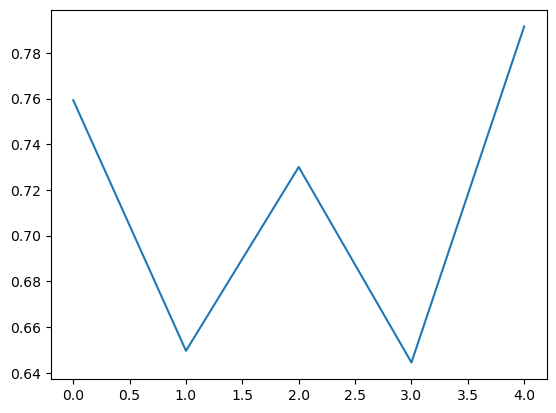

In [193]:
accuracies = []
for key,value in model_accuracies.items():
  accuracies.append(value)

plt.plot(accuracies)

In [194]:
accuracies.sort()
accuracies

[0.6445159602302459,
 0.6496153846153847,
 0.7300523286237572,
 0.7592490842490842,
 0.7915201465201465]

In [195]:
count = 0
for key,val in model_accuracies.items():
    best_model_param = key.best_params_
best_model_param

{'reg_lambda': 4,
 'reg_alpha': 1,
 'n_estimators': 151,
 'min_child_weight': 5,
 'max_depth': 201,
 'learning_rate': 0.9,
 'gamma': 4,
 'colsample_bytree': 0.8}

In [198]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn import metrics



xgb_classifier = XGBClassifier(
    **best_model_param
    # n_estimators=400,  
    # max_depth=4,         
    # learning_rate = 0.1,
    # reg_alpha=0.01,          
    # reg_lambda=1
)

xgb_classifier.fit(sampleTrain_dtm, y_train)

y_pred = xgb_classifier.predict(sampleTest_dtm)

accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

confusion_mat = metrics.confusion_matrix(y_test, y_pred)
print(confusion_mat)

cm_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_mat,display_labels=["0","1","2","3","4"])
cm_disp.plot()
print(confusion_mat)
print()
print("Precision",metrics.precision_score(y_test,y_pred))
print()
print("Recall",metrics.recall_score(y_test,y_pred))
print("F1 Score",metrics.f1_score(y_test,y_pred))

c:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Accuracy: 0.79
[[83  3 10  2  4]
 [ 4 77  8  0  5]
 [ 4  0 55  0 17]
 [ 0  0  4 86  9]
 [ 2  1 22  6 87]]


# DL Models

In [172]:
import numpy as np

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

from keras import Sequential
from keras.layers import Dense,SimpleRNN,Flatten,Embedding, LSTM
from sklearn.model_selection import train_test_split


# Tokenizer

In [268]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_cleaned["Letters"])

In [174]:
tokenizer.word_index

{'the': 1,
 'of': 2,
 'and': 3,
 'to': 4,
 'in': 5,
 'a': 6,
 'for': 7,
 'that': 8,
 'is': 9,
 'by': 10,
 'on': 11,
 'with': 12,
 'be': 13,
 'from': 14,
 'as': 15,
 'are': 16,
 'this': 17,
 'at': 18,
 'was': 19,
 'have': 20,
 'i': 21,
 'we': 22,
 'or': 23,
 'were': 24,
 'an': 25,
 'tobacco': 26,
 'smoking': 27,
 '1': 28,
 'you': 29,
 'not': 30,
 'it': 31,
 'has': 32,
 '2': 33,
 'been': 34,
 'which': 35,
 'he': 36,
 'will': 37,
 'new': 38,
 'these': 39,
 'may': 40,
 'cancer': 41,
 '‘the': 42,
 'but': 43,
 '3': 44,
 'no': 45,
 'smoke': 46,
 'your': 47,
 'cells': 48,
 'they': 49,
 'cigarette': 50,
 'te': 51,
 'more': 52,
 '4': 53,
 'can': 54,
 'one': 55,
 'than': 56,
 'our': 57,
 'would': 58,
 'other': 59,
 'all': 60,
 '8': 61,
 'research': 62,
 '10': 63,
 'health': 64,
 're': 65,
 'if': 66,
 'al': 67,
 'also': 68,
 'j': 69,
 'any': 70,
 'who': 71,
 'ae': 72,
 'ee': 73,
 '0': 74,
 'us': 75,
 'its': 76,
 'et': 77,
 'about': 78,
 'date': 79,
 'their': 80,
 'lung': 81,
 'some': 82,
 'dr': 83

In [175]:
# count no of sentences or rows
tokenizer.document_count

2441

In [290]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)


In [270]:
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [271]:
X_train_padded_sequences = pad_sequences(sequences=X_train_sequences,padding="post",maxlen=100)
X_test_padded_sequences = pad_sequences(sequences=X_test_sequences,padding="post",maxlen=100)

In [272]:
X_train_padded_sequences.shape,X_test_padded_sequences.shape

((1952, 100), (489, 100))

# Model Building DL

In [305]:

vocab_size = len(tokenizer.word_index) + 1
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=100))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=5, activation='softmax'))

In [306]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [307]:
model.fit(X_train_padded_sequences,y_train,epochs=20,validation_data=(X_test_padded_sequences,y_test))


Epoch 1/20


61/61 [==============================] - 16s 164ms/step - loss: 1.4833 - accuracy: 0.3253 - val_loss: 1.3985 - val_accuracy: 0.3885
Epoch 2/20
61/61 [==============================] - 8s 137ms/step - loss: 1.1385 - accuracy: 0.5364 - val_loss: 1.2253 - val_accuracy: 0.4908
Epoch 3/20
61/61 [==============================] - 8s 136ms/step - loss: 0.7840 - accuracy: 0.7157 - val_loss: 1.2804 - val_accuracy: 0.5256
Epoch 4/20
61/61 [==============================] - 8s 132ms/step - loss: 0.4805 - accuracy: 0.8525 - val_loss: 1.3016 - val_accuracy: 0.5603
Epoch 5/20
61/61 [==============================] - 10s 168ms/step - loss: 0.3390 - accuracy: 0.9042 - val_loss: 1.4935 - val_accuracy: 0.5460
Epoch 6/20
61/61 [==============================] - 8s 134ms/step - loss: 0.2716 - accuracy: 0.9206 - val_loss: 1.6571 - val_accuracy: 0.5562
Epoch 7/20
61/61 [==============================] - 10s 166ms/step - loss: 0.3490 - accuracy: 0.8940 - val_loss: 1.3219 - val_accuracy: 0.6094
Epoch 8/20
61/

In [ ]:
# Using LSTM we achieve highest accuracy of around 97%